In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
colors = ['#EB984E', '#F4D03F', '#52BE80', '#5DADE2', '#AF7AC5', '#EC7063', '#45B39D', '#5499C7', '#F1948A', '#48C9B0', '#BB8FCE', '#76D7C4', '#D2B4DE', '#85C1E9', '#FAD02E', '#E59866', '#1ABC9C', '#F39C12', '#A569BD', '#3498DB', '#E74C3C', '#58D68D']
font1 = {'family':'serif','color':"darkred",'size':20}
font2 = {'family':'serif','color':'black','size':15}
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
import shap
from sklearn.impute import SimpleImputer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score,make_scorer,confusion_matrix
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_curve, roc_auc_score,recall_score,f1_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.feature_selection import RFE
import random
import pickle
from sklearn.pipeline import Pipeline

In [16]:
with open('Top-Features.pkl','rb') as file:
    top_features = pickle.load(file)

In [17]:
def get_best_model(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    return best_model

In [18]:
def evaluate_model(model,X_test,y_true):
    y_pred = model.predict(X_test)
    print(classification_report(y_true,y_pred))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for {model.__class__.__name__} ')
    plt.show()

    y_proba = model.predict_proba(X_test)[:, 1]

  
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)

   
    roc_auc = roc_auc_score(y_true, y_proba)
    print(f"ROC AUC Score: {roc_auc:.2f}")

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curve for {model.__class__.__name__}')
    plt.legend(loc="lower right")
    plt.show()


def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_regressor(model,X_test,y_true):
    y_pred = model.predict(X_test)
    m = mape(y_true,y_pred)
    print(f'MAPE : {m}')

mape_scorer = make_scorer(mape, greater_is_better=False)

In [19]:
def get_parameter_grid(model_name):
    if model_name == 'XGBoost':
        param_grid = {
            'learning_rate': [0.1, 0.01],
            'max_depth': [5, 10,20],
            'n_estimators': [100, 200, 500]
        }
    elif model_name == 'RandomForest':
        param_grid = {
            'n_estimators': [100, 200, 500],
            'max_depth': [5, 10, 20],
            'min_samples_split': [2, 5, 10],
        }
    elif model_name == 'SVC':
        param_grid = {
            'C': [0.1, 1, 10],
            'gamma': [1, 0.1, 0.01],
            'kernel': ['rbf', 'linear']
        }
    elif model_name == 'LogisticRegression':
        param_grid = {
            'C': [0.1, 1, 10, 100],
            'penalty': ['l1', 'l2']
        }
    elif model_name == 'KNN':
        param_grid = {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    else:
        raise ValueError("Invalid model name.")
    
    return param_grid

In [20]:
def tune_model(model, param_grid, metric, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=metric, cv=3)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    return best_model

def tune_regressor(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=mape_scorer, cv=3)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    return best_model

In [21]:
def IQR_method(df, n, features):
    outlier_indices = []
    
    for column in features:
        Q1 = np.percentile(df[column], 25)
        Q3 = np.percentile(df[column], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        
        outlier_indices_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_indices_column)
    
    outlier_counts = Counter(outlier_indices)
    multiple_outliers = [index for index, count in outlier_counts.items() if count > n]
    
    print('Total number of outliers is:', len(outlier_indices))
    
    return multiple_outliers

In [105]:
df = pd.read_csv('training_data.csv')

In [106]:
df[df['Churn'] == 'Yes']

CustomerID Churn  MonthlyRevenue  MonthlyMinutes  TotalRecurringCharge  \
0         3000002   Yes           24.00           219.0                  22.0   
1         3000010   Yes           16.99            10.0                  17.0   
4         3000026   Yes           17.14             0.0                  17.0   
15        3000082   Yes          172.44          1978.0                 100.0   
18        3000122   Yes           24.49            42.0                  17.0   
...           ...   ...             ...             ...                   ...   
51031     3399874   Yes           33.63            28.0                  30.0   
51033     3399882   Yes           38.34           320.0                  30.0   
51041     3399946   Yes          117.49           384.0                  30.0   
51042     3399958   Yes             NaN             NaN                   NaN   
51044     3399978   Yes             NaN             NaN                   NaN   

       DirectorAssistedCalls  OverageMinutes  RoamingCalls  PercChangeMinutes  \
0                       0.25             0.0           0.0             -157.0   
1                       0.00             0.0           0.0               -4.0   
4                       0.00             0.0           0.0                0.0   
15                      0.00           362.0           0.0            -1007.0   
18                      0.00            10.0           0.0               81.0   
...                      ...             ...           ...                ...   
51031                   0.00             0.0           0.0                0.0   
51033                   0.99            21.0           0.0              -66.0   
51041                   0.00           250.0           0.0                0.0   
51042                    NaN             NaN           NaN                NaN   
51044                    NaN             NaN           NaN                NaN   

       PercChangeRevenues  ...  ReferralsMadeBySubscriber  IncomeGroup  \
0                   -19.0  ...                          0            4   
1                     0.0  ...                          0            5   
4                    -0.2  ...                          0            9   
15                  -72.5  ...                          0            6   
18                   29.9  ...                          0            9   
...                   ...  ...                        ...          ...   
51031                 0.0  ...                          0            0   
51033                -8.3  ...                          0            6   
51041                 0.0  ...                          0            2   
51042                 NaN  ...                          0            6   
51044                 NaN  ...                          0            7   

       OwnsMotorcycle  AdjustmentsToCreditRating  HandsetPrice  \
0                  No                          0            30   
1                  No                          0            30   
4                  No                          1            10   
15                 No                          0           150   
18                 No                          0            30   
...               ...                        ...           ...   
51031              No                          0            30   
51033              No                          0       Unknown   
51041              No                          0            30   
51042              No                          0            60   
51044              No                          1            80   

       MadeCallToRetentionTeam  CreditRating  PrizmCode    Occupation  \
0                          Yes     1-Highest   Suburban  Professional   
1                           No      4-Medium   Suburban  Professional   
4                           No     1-Highest      Other  Professional   
15                         Yes     1-Highest      Other  Professional   
18            

In [107]:
df.shape

(51047, 58)

## Exploring the Data (EDA)

In [108]:
df.head()

CustomerID Churn  MonthlyRevenue  MonthlyMinutes  TotalRecurringCharge  \
0     3000002   Yes           24.00           219.0                  22.0   
1     3000010   Yes           16.99            10.0                  17.0   
2     3000014    No           38.00             8.0                  38.0   
3     3000022    No           82.28          1312.0                  75.0   
4     3000026   Yes           17.14             0.0                  17.0   

   DirectorAssistedCalls  OverageMinutes  RoamingCalls  PercChangeMinutes  \
0                   0.25             0.0           0.0             -157.0   
1                   0.00             0.0           0.0               -4.0   
2                   0.00             0.0           0.0               -2.0   
3                   1.24             0.0           0.0              157.0   
4                   0.00             0.0           0.0                0.0   

   PercChangeRevenues  ...  ReferralsMadeBySubscriber  IncomeGroup  \
0               -19.0  ...                          0            4   
1                 0.0  ...                          0            5   
2                 0.0  ...                          0            6   
3                 8.1  ...                          0            6   
4                -0.2  ...                          0            9   

   OwnsMotorcycle  AdjustmentsToCreditRating  HandsetPrice  \
0              No                          0            30   
1              No                          0            30   
2              No                          0       Unknown   
3              No                          0            10   
4              No                          1            10   

   MadeCallToRetentionTeam  CreditRating  PrizmCode    Occupation  \
0                      Yes     1-Highest   Suburban  Professional   
1                       No      4-Medium   Suburban  Professional   
2                       No        3-Good       Town        Crafts   
3                       No      4-Medium      Other         Other   
4                       No     1-Highest      Other  Professional   

   MaritalStatus  
0             No  
1            Yes  
2            Yes  
3             No  
4            Yes  

[5 rows x 58 columns]

### Checking for Null Values

In [109]:
dropped_samples = df[df.isnull().any(axis=1)].copy()

In [110]:
df.isnull().sum() ### the data has some NULL values

CustomerID                     0
Churn                          0
MonthlyRevenue               156
MonthlyMinutes               156
TotalRecurringCharge         156
DirectorAssistedCalls        156
OverageMinutes               156
RoamingCalls                 156
PercChangeMinutes            367
PercChangeRevenues           367
DroppedCalls                   0
BlockedCalls                   0
UnansweredCalls                0
CustomerCareCalls              0
ThreewayCalls                  0
ReceivedCalls                  0
OutboundCalls                  0
InboundCalls                   0
PeakCallsInOut                 0
OffPeakCallsInOut              0
DroppedBlockedCalls            0
CallForwardingCalls            0
CallWaitingCalls               0
MonthsInService                0
UniqueSubs                     0
ActiveSubs                     0
ServiceArea                   24
Handsets                       1
HandsetModels                  1
CurrentEquipmentDays           1
AgeHH1    

#### The null values are insignificant compared to the total number of rows, so they are dropped, along with meaningless Customer ID 

In [111]:
df.dropna(inplace=True)
df.drop('CustomerID',axis=1,inplace=True)

In [112]:
# df_maj = df[df['MadeCallToRetentionTeam']=='No']
# df_min = df[df['MadeCallToRetentionTeam']=='Yes']
# df_min.shape
# df = pd.concat([df_maj.iloc[:1621],df_min])

In [113]:
df.shape

(49752, 57)

#### Analyzing the numerical features

In [114]:
numerical_feats = df.select_dtypes(include=['float64', 'int64']).columns

for feature in numerical_feats:
    print(f'\n************** {feature} **************\n')
    print(df[feature].value_counts())


************** MonthlyRevenue **************

MonthlyRevenue
29.99     1044
34.99      787
10.00      464
30.00      402
30.26      384
          ... 
180.98       1
15.29        1
206.99       1
262.06       1
534.93       1
Name: count, Length: 12504, dtype: int64

************** MonthlyMinutes **************

MonthlyMinutes
0.0       671
2.0       128
8.0       122
6.0       119
88.0      116
         ... 
3012.0      1
1958.0      1
1839.0      1
3017.0      1
2437.0      1
Name: count, Length: 2706, dtype: int64

************** TotalRecurringCharge **************

TotalRecurringCharge
30.0     7192
45.0     6505
60.0     4362
40.0     4321
50.0     4066
         ... 
186.0       1
171.0       1
360.0       1
165.0       1
212.0       1
Name: count, Length: 211, dtype: int64

************** DirectorAssistedCalls **************

DirectorAssistedCalls
0.00     23955
0.25      6635
0.50      3872
0.74      2706
0.99      1948
         ...  
18.32        1
32.17        1
17.82        

#### Analyzing the categorical features

In [115]:
categorical_feats = df.select_dtypes(include='object').columns
for feature in categorical_feats:
    print(f'\n************** {feature} **************\n')
    print(df[feature].value_counts())


************** Churn **************

Churn
No     35507
Yes    14245
Name: count, dtype: int64

************** ServiceArea **************

ServiceArea
NYCBRO917    1646
DALDAL214    1479
HOUHOU281    1471
NYCMAN917    1156
DALFTW817     771
             ... 
SANROM956       1
INDCRA765       1
SEWSUN509       1
ATLDBL478       1
NCRDNN910       1
Name: count, Length: 743, dtype: int64

************** ChildrenInHH **************

ChildrenInHH
No     37483
Yes    12269
Name: count, dtype: int64

************** HandsetRefurbished **************

HandsetRefurbished
No     42852
Yes     6900
Name: count, dtype: int64

************** HandsetWebCapable **************

HandsetWebCapable
Yes    44905
No      4847
Name: count, dtype: int64

************** TruckOwner **************

TruckOwner
No     40280
Yes     9472
Name: count, dtype: int64

************** RVOwner **************

RVOwner
No     45619
Yes     4133
Name: count, dtype: int64

************** Homeownership **************

Homeown

#### The HandSetPrice and the Marital Status Column have a lot of unknowns, which play a similar role as the NULL/NAN values, so they need to dealt with.

#### The Service Area can be changed into a more interpretable form that represents the states

In [116]:
df['ServiceArea'] = df['ServiceArea'].apply(lambda x:x[:2])

In [117]:
len(df['ServiceArea'].value_counts())

41

### Checking the data - Imbalance?

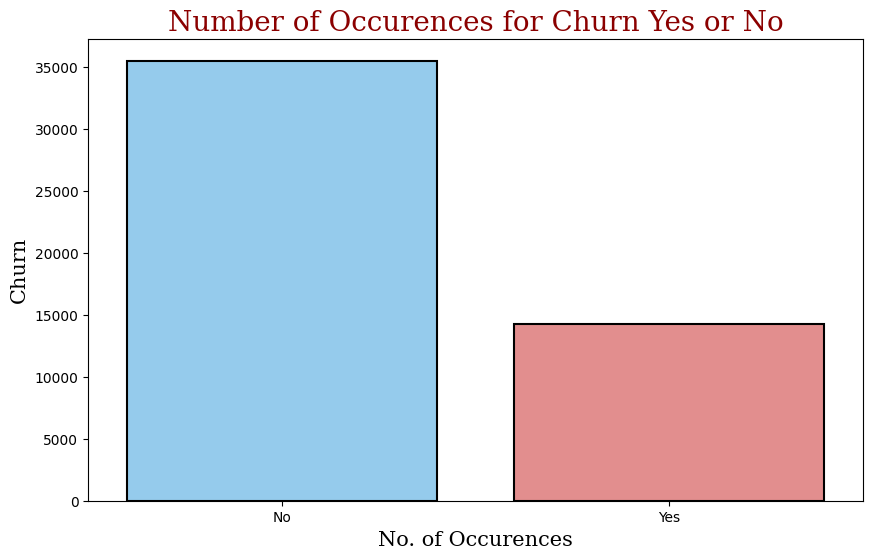

In [118]:
churn_counts = df['Churn'].value_counts()
plt.figure(figsize=(10,6))
sns.barplot(x=churn_counts.index,y=churn_counts.values,hue=churn_counts.index,palette=colors,edgecolor='black',linewidth=1.5)
plt.xlabel('No. of Occurences',fontdict=font2)
plt.ylabel('Churn',fontdict=font2)
plt.title('Number of Occurences for Churn Yes or No',fontdict=font1)
plt.show()

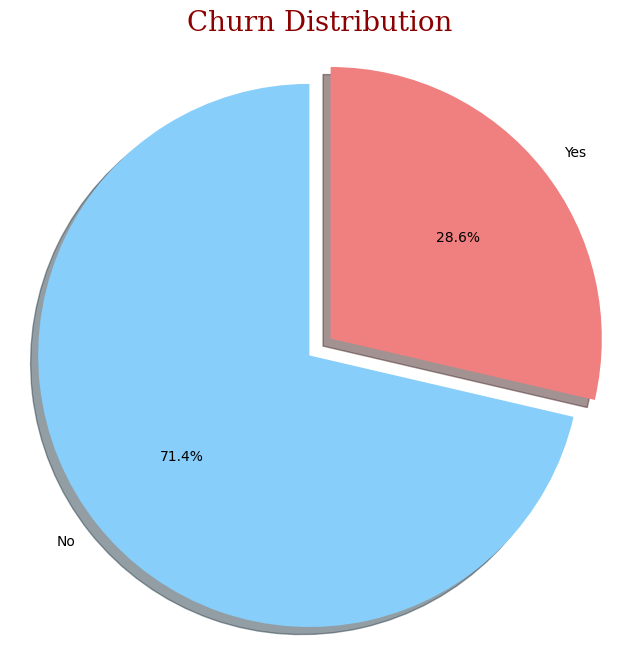

In [119]:
churn_counts = df['Churn'].value_counts()
labels = churn_counts.index
sizes = churn_counts.values
colors = ['lightskyblue','lightcoral']
explode = (0.1, 0) 

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90,
        explode=explode, shadow=True)
plt.title('Churn Distribution',fontdict=font1)

plt.axis('equal')  

plt.show()

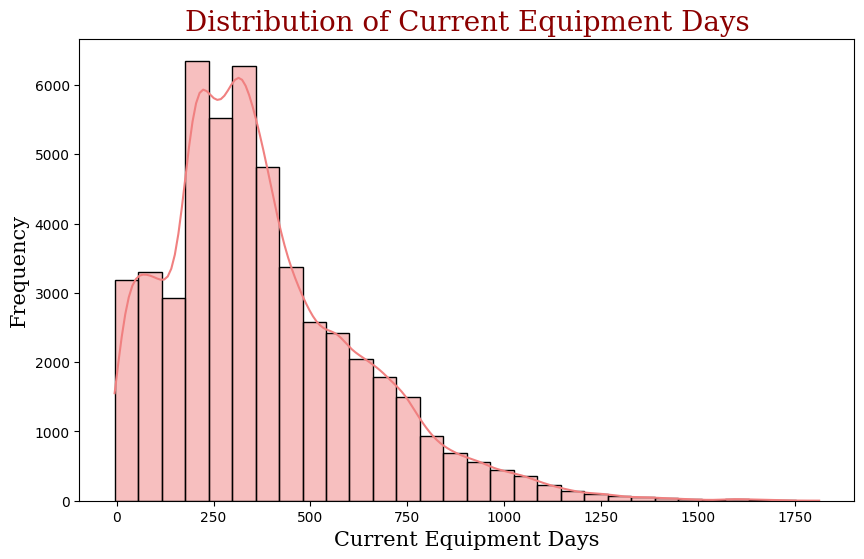

In [20]:
plt.figure(figsize=(10, 6))

sns.histplot(df['CurrentEquipmentDays'], bins=30, kde=True, color='lightcoral', edgecolor='black')


plt.xlabel('Current Equipment Days',fontdict=font2)
plt.ylabel('Frequency',fontdict=font2)
plt.title('Distribution of Current Equipment Days',fontdict=font1)


plt.show()

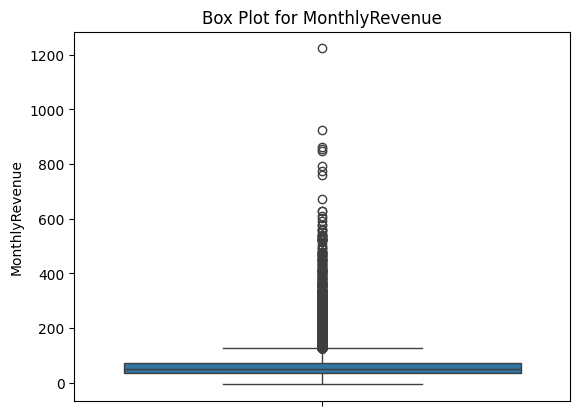

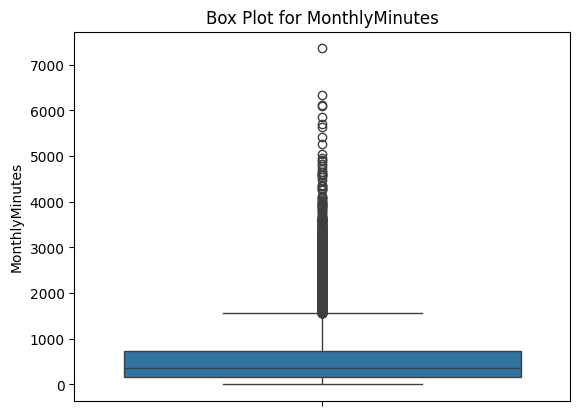

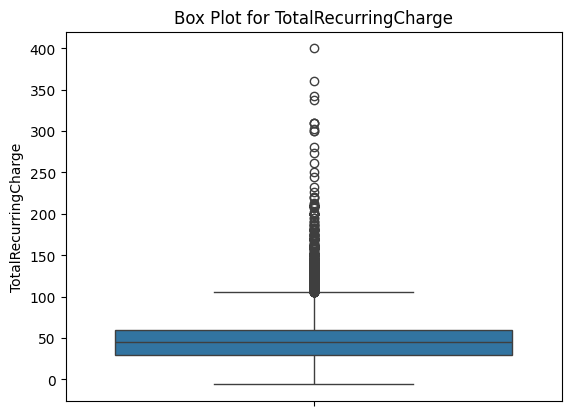

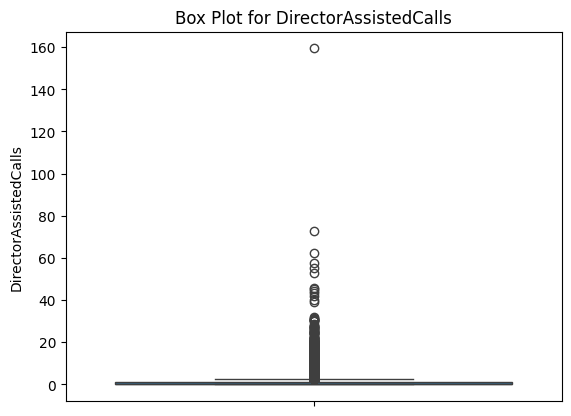

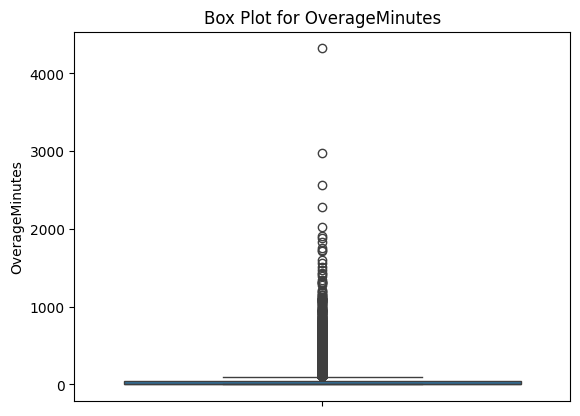

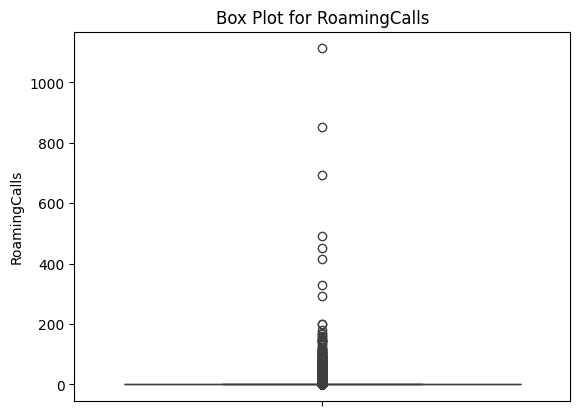

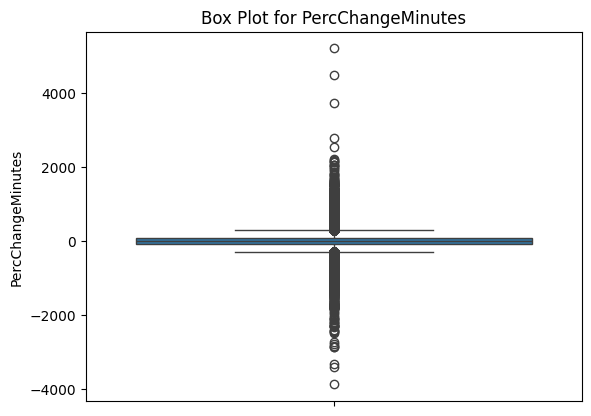

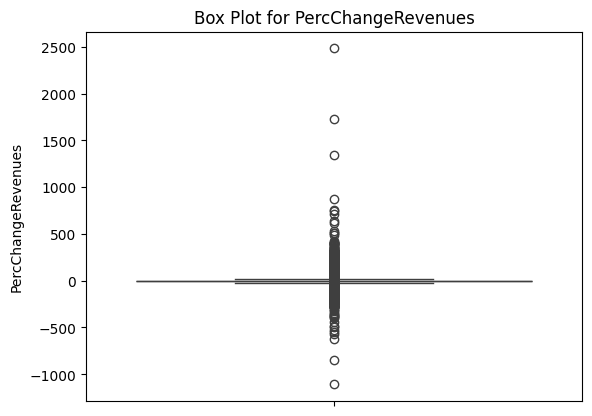

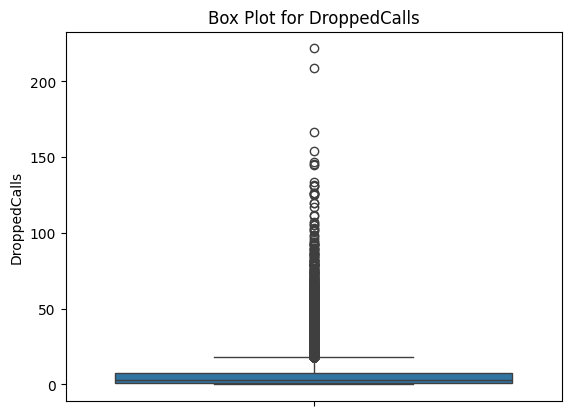

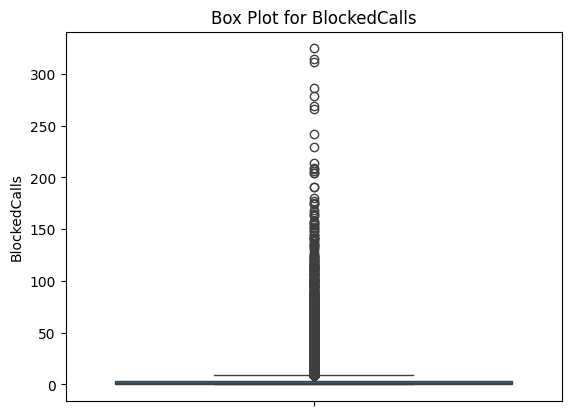

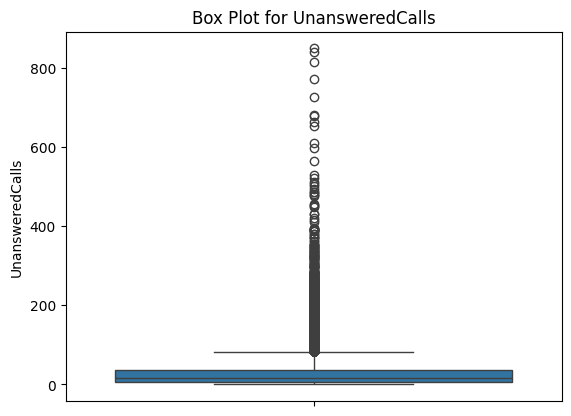

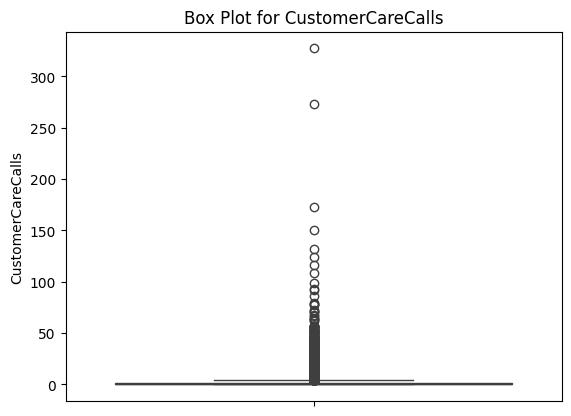

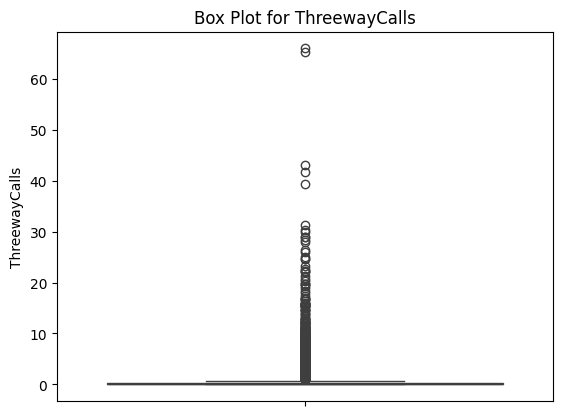

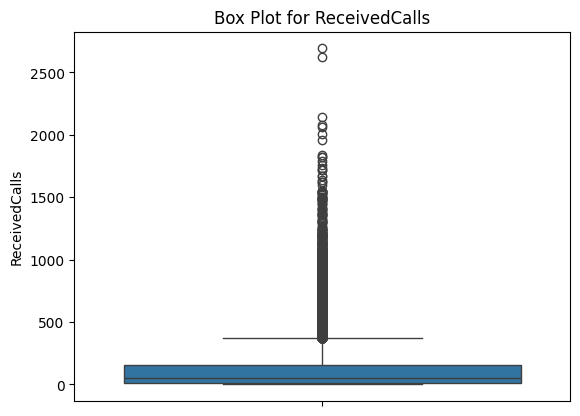

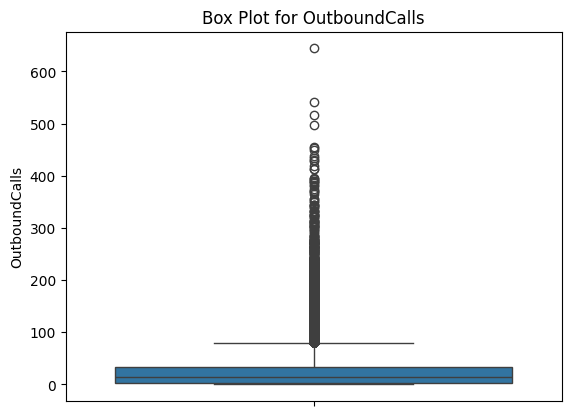

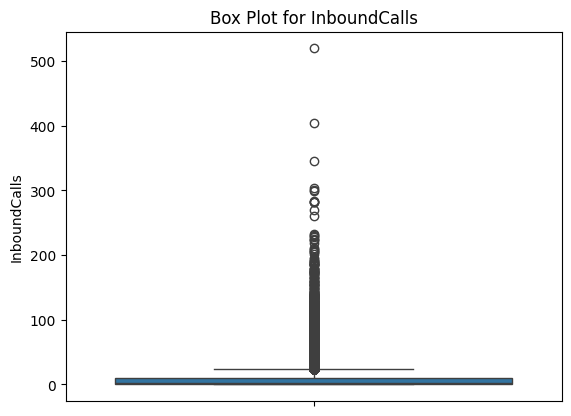

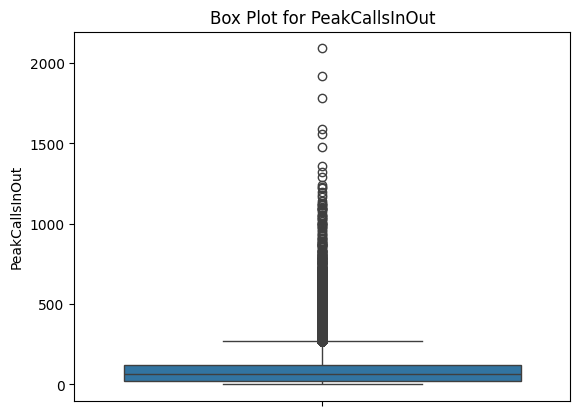

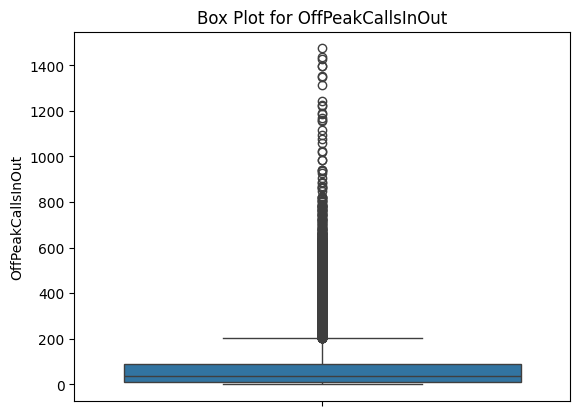

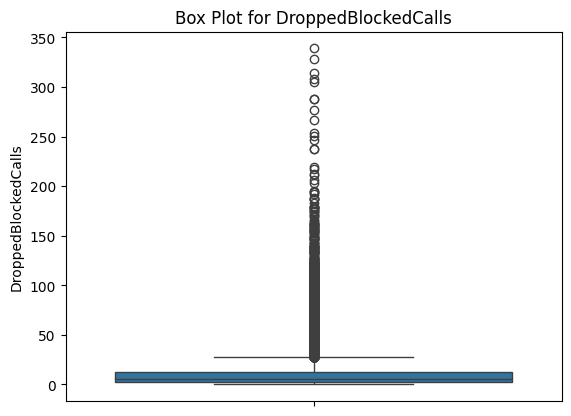

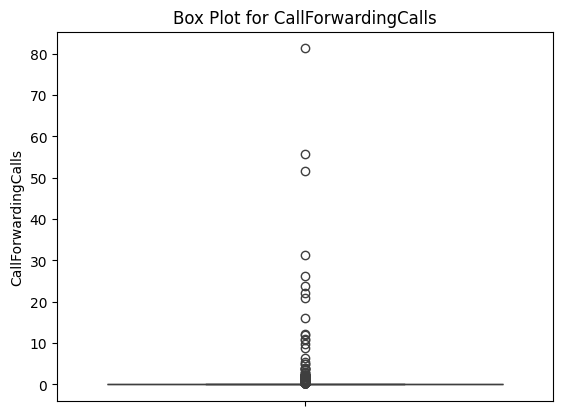

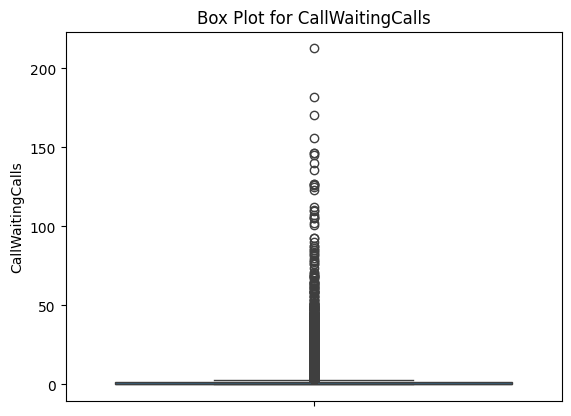

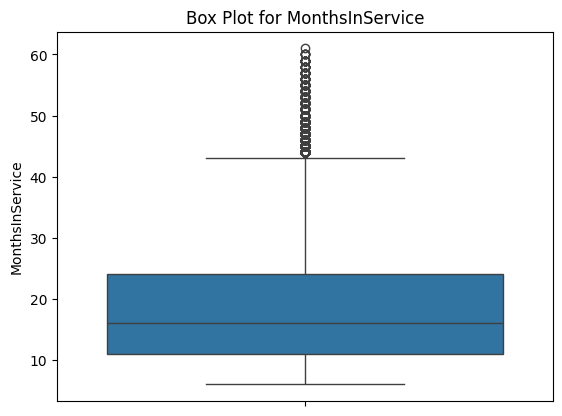

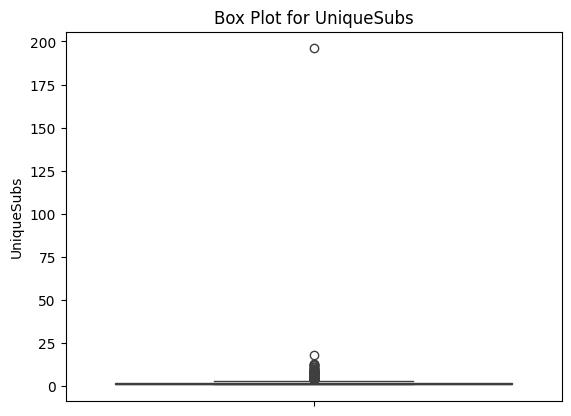

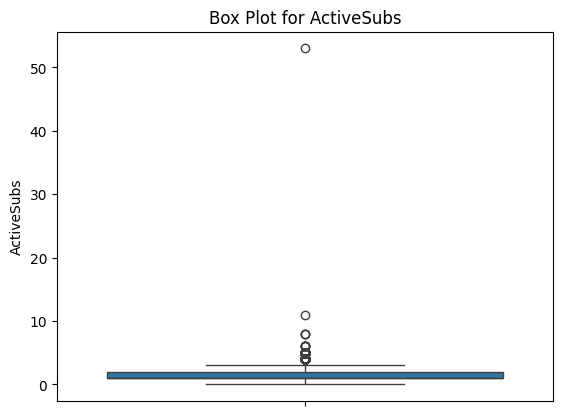

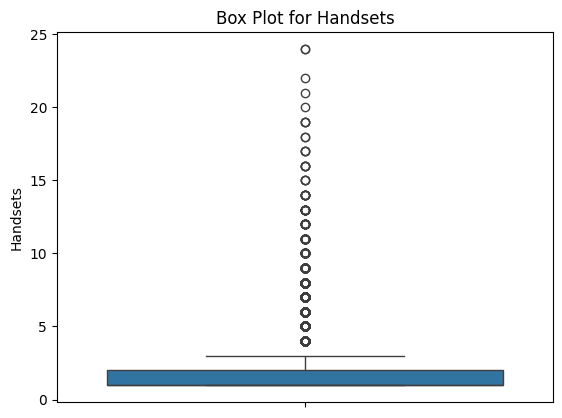

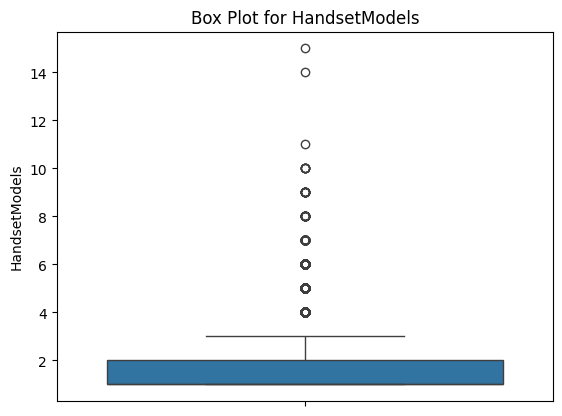

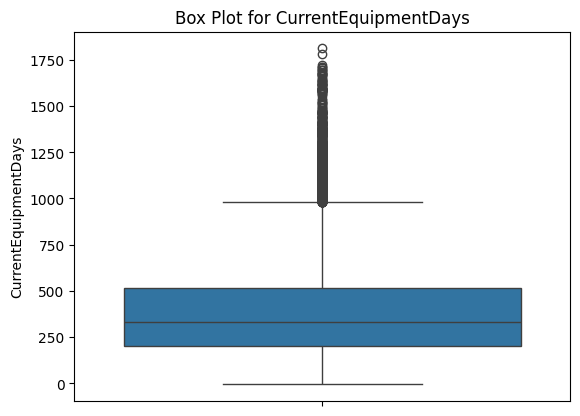

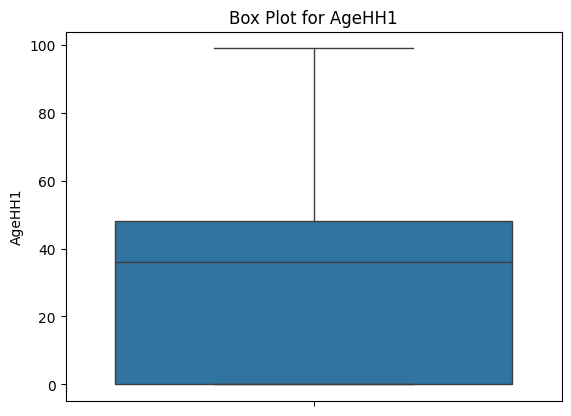

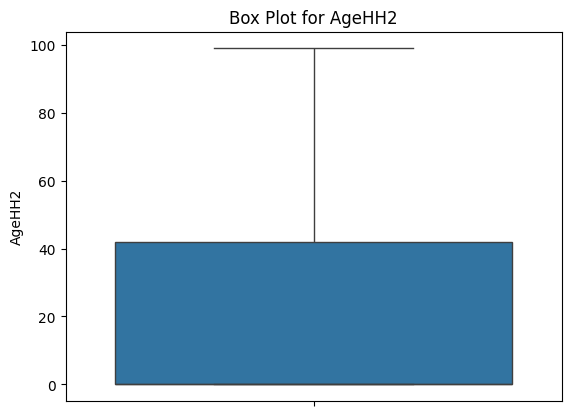

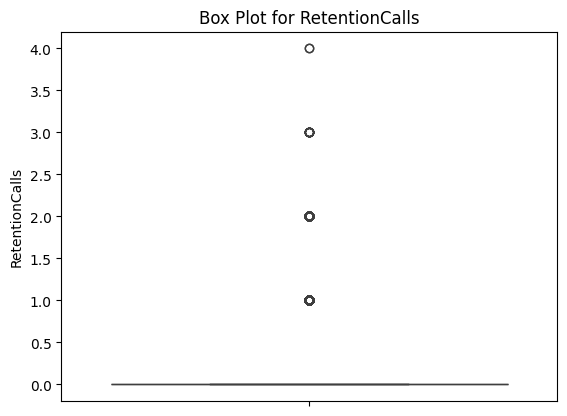

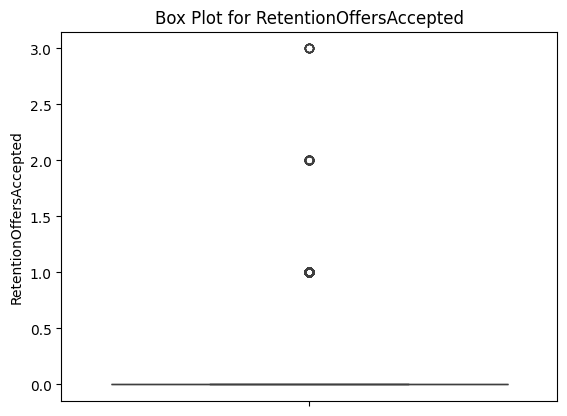

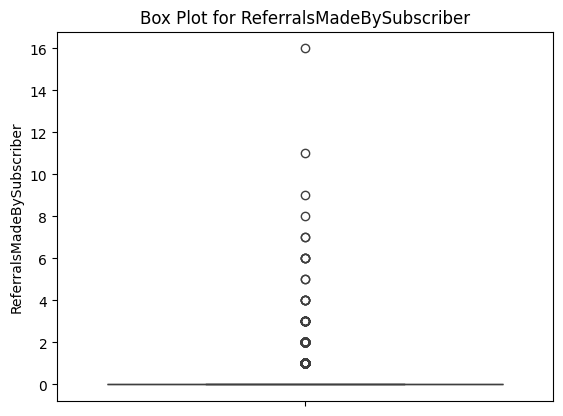

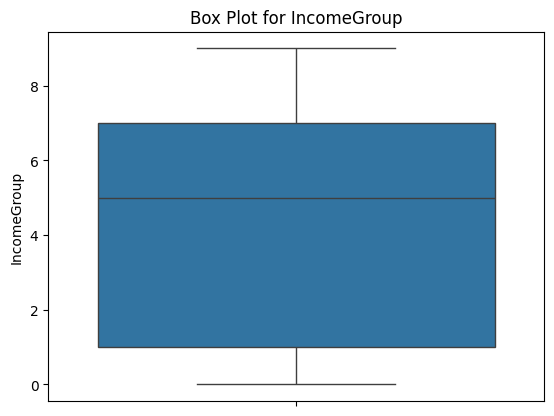

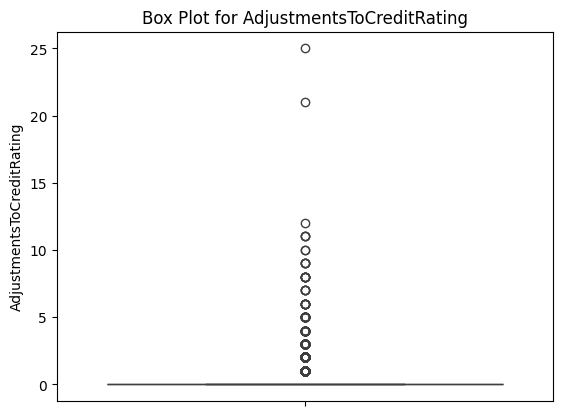

In [72]:
for feat in numerical_feats:
    sns.boxplot(data=df, y=feat)
    plt.title(f'Box Plot for {feat}')
    plt.show()

In [ ]:
numerical_feats

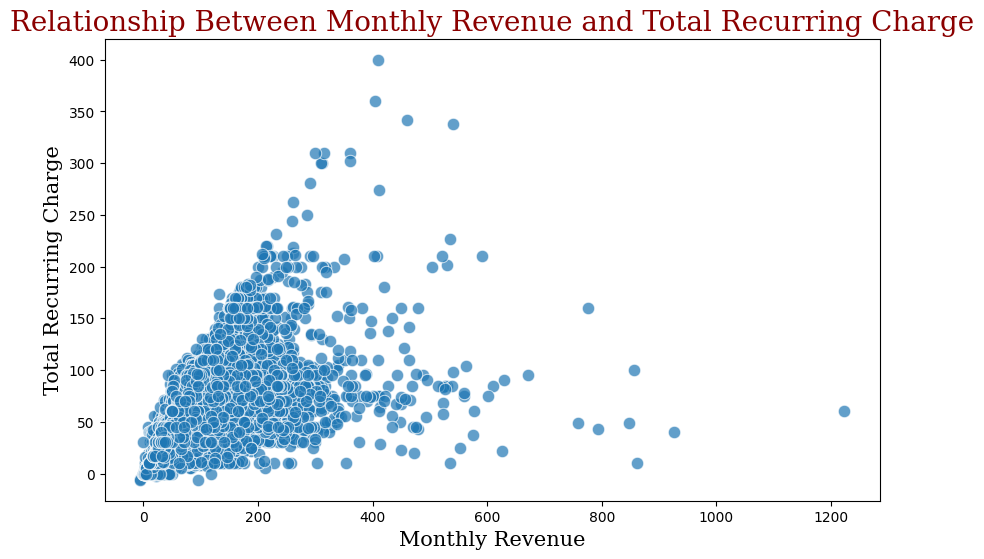

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='MonthlyRevenue', y='TotalRecurringCharge', alpha=0.7, s=80)
plt.xlabel('Monthly Revenue',fontdict=font2)
plt.ylabel('Total Recurring Charge',fontdict=font2)
plt.title('Relationship Between Monthly Revenue and Total Recurring Charge',fontdict=font1)
plt.show()

#### The data is clearly imbalanced, with around three times less cases of customers churning

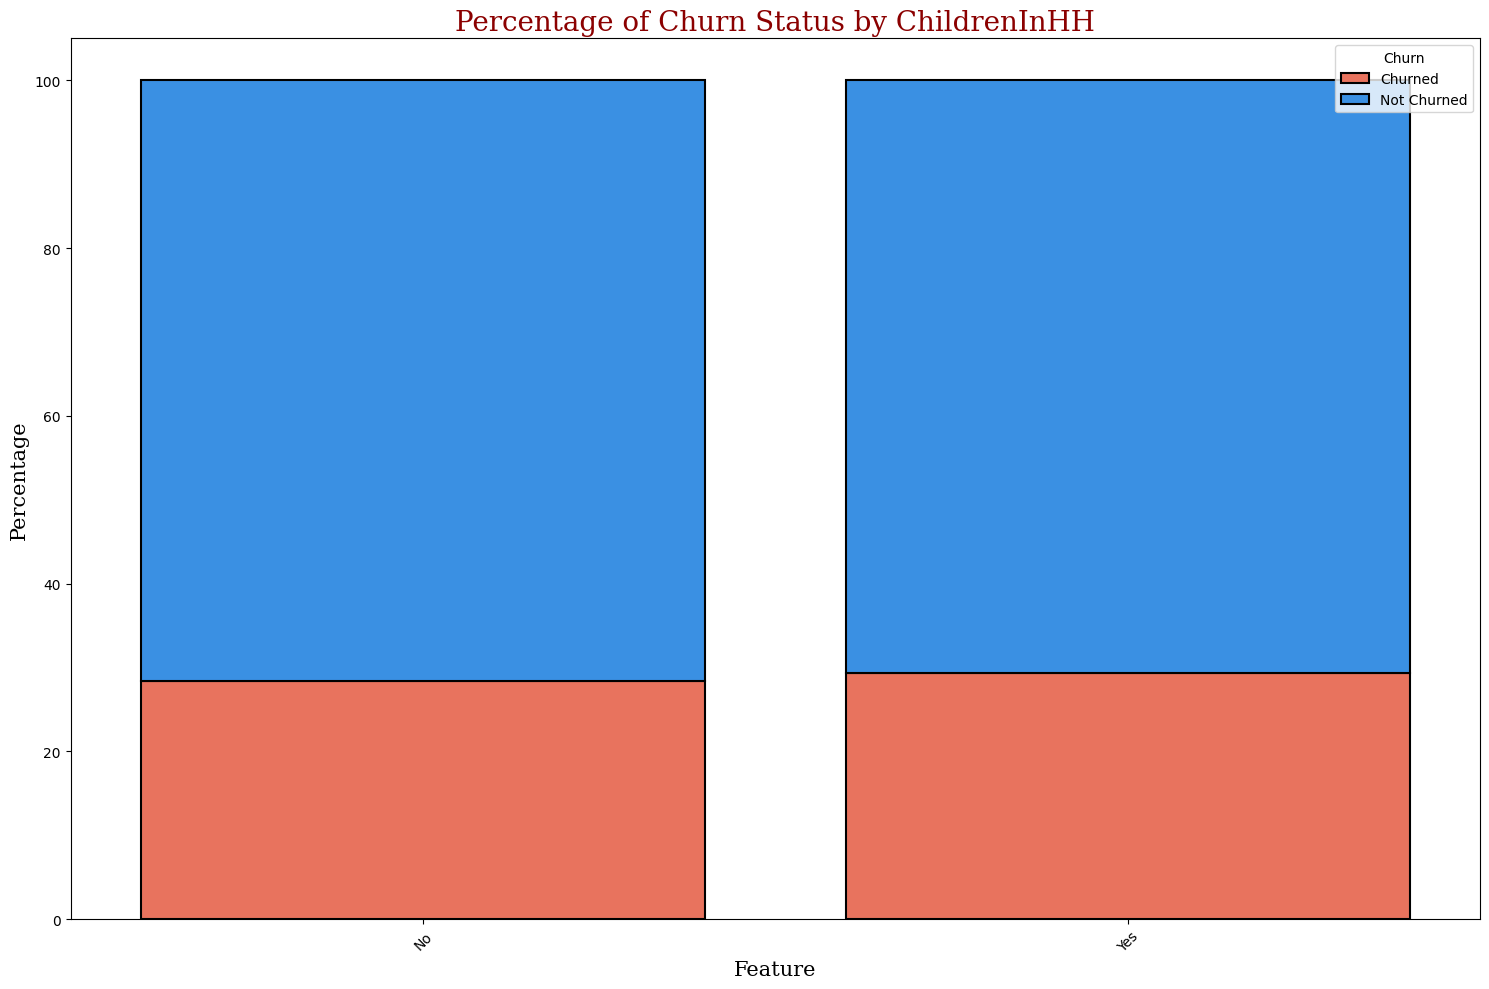

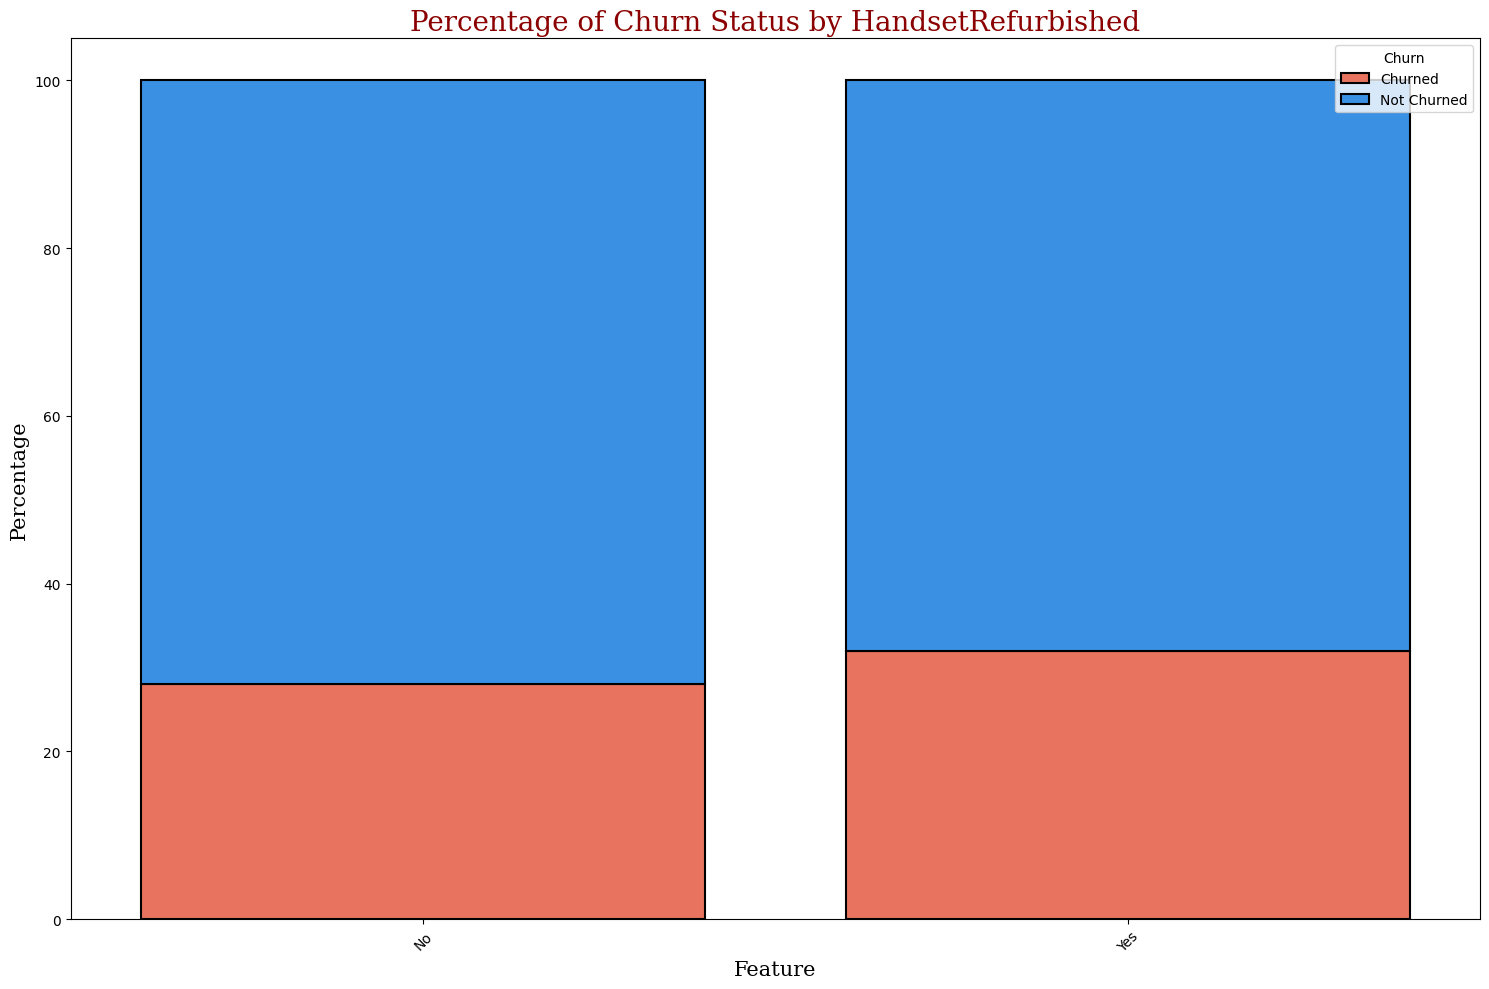

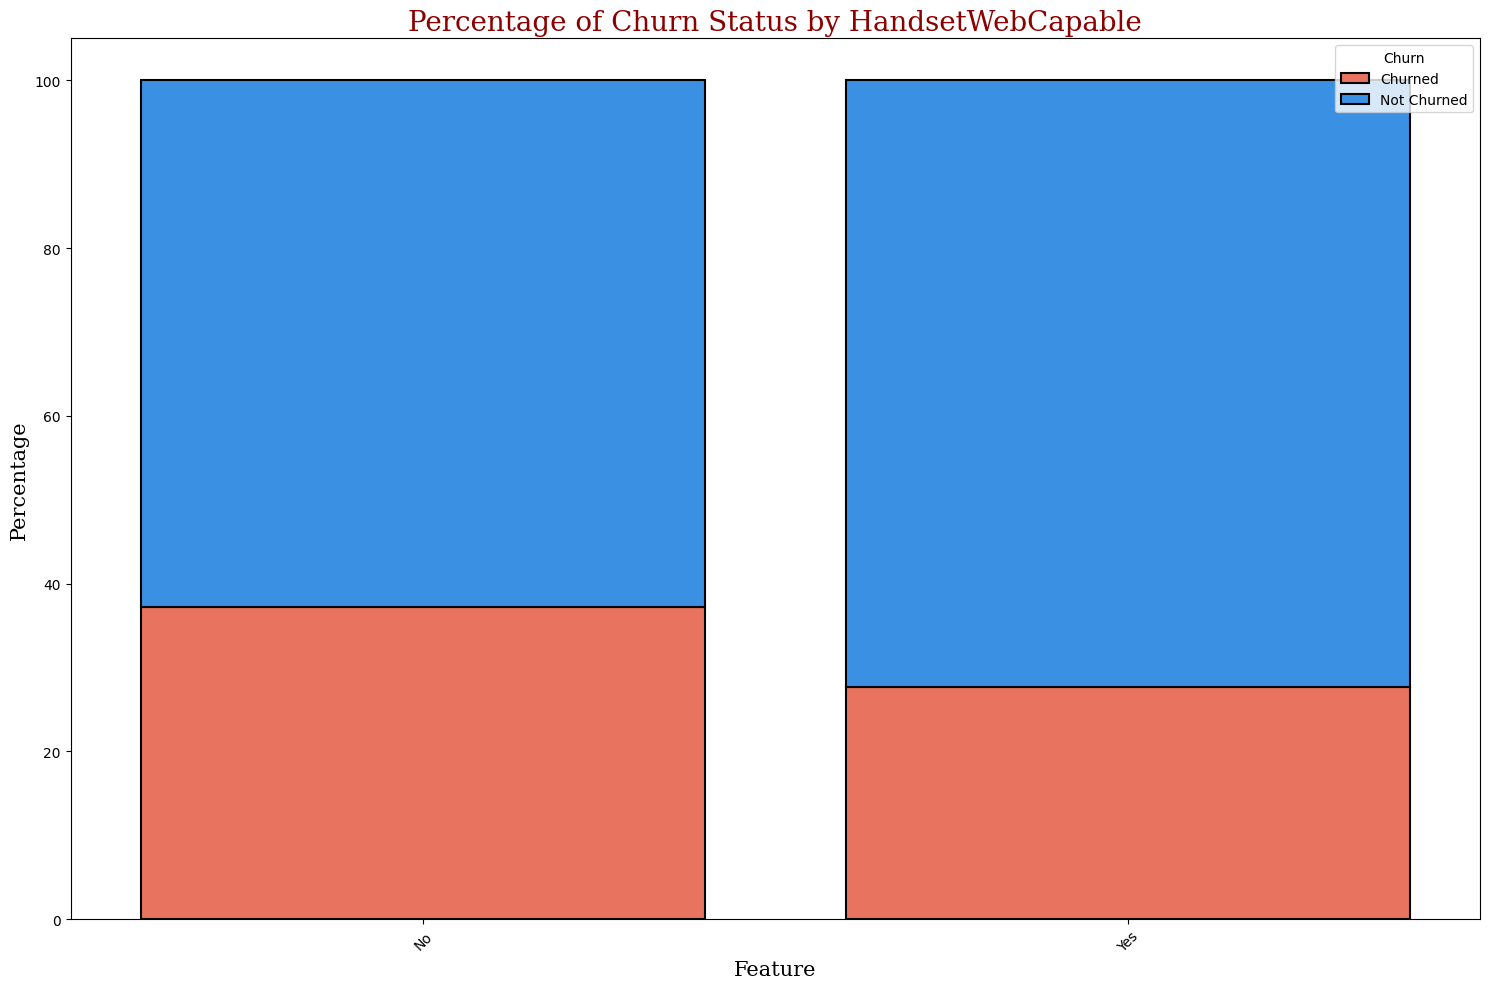

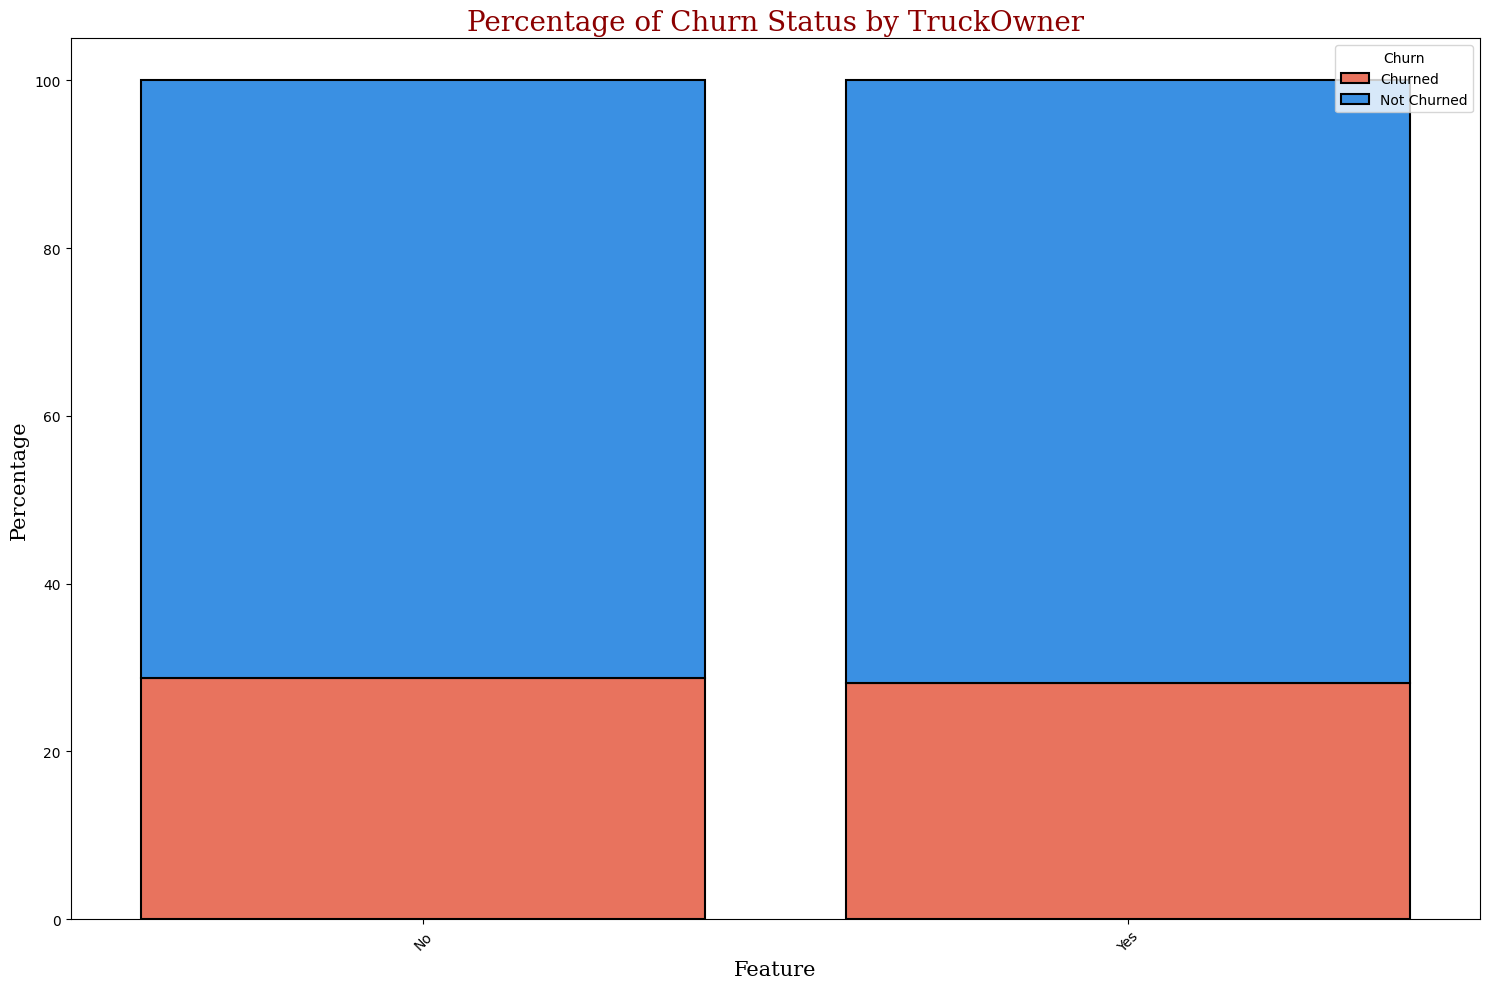

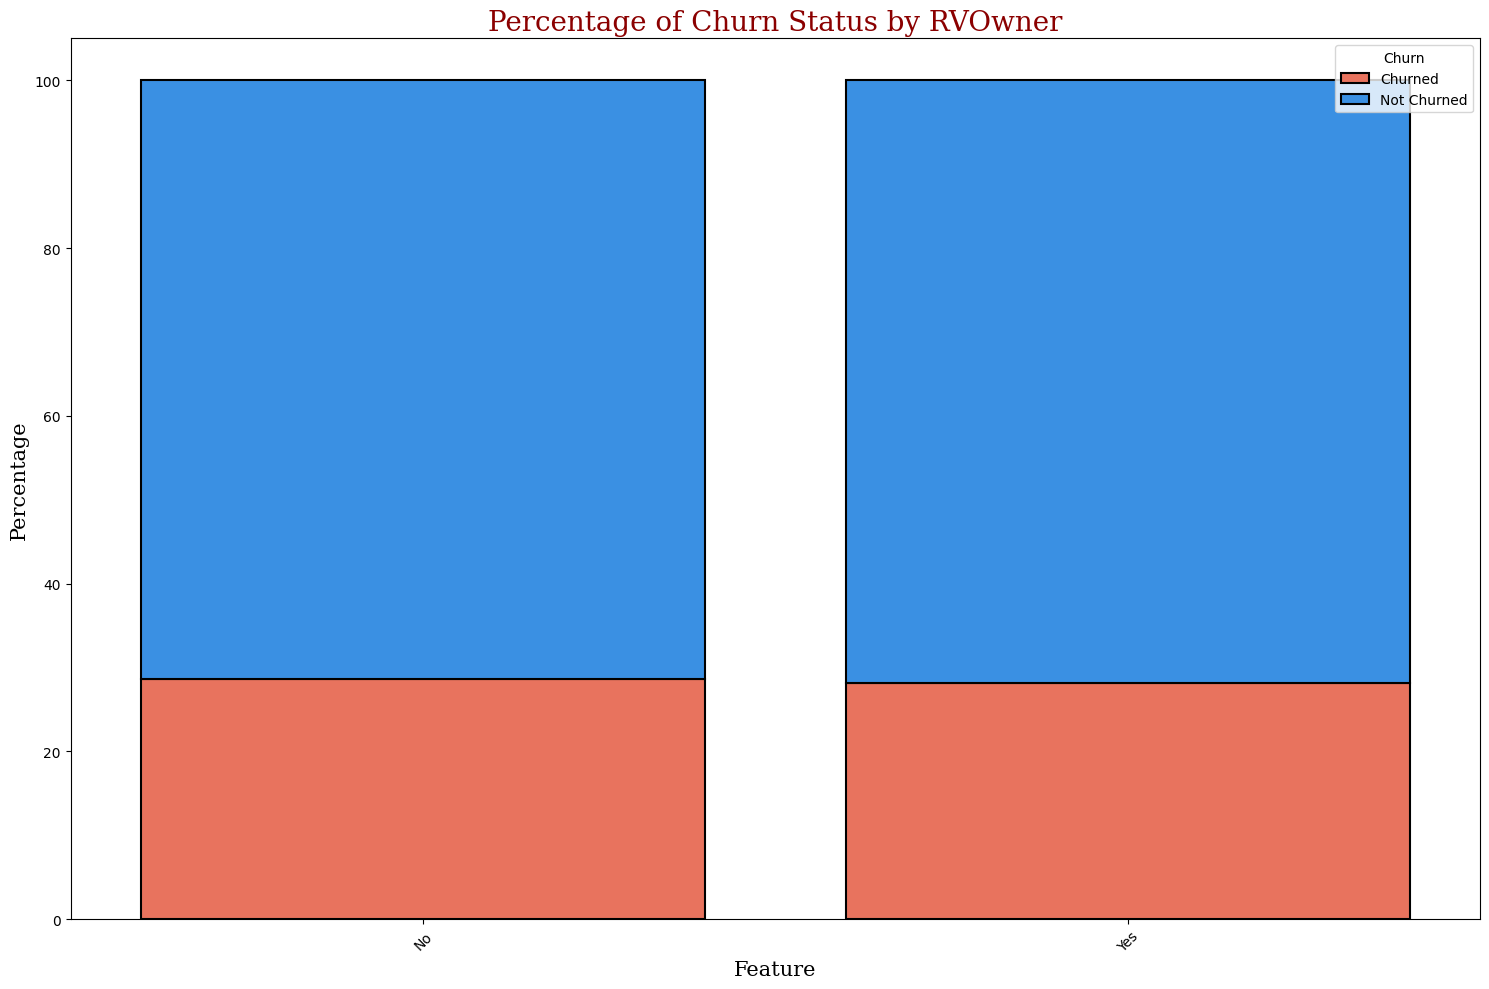

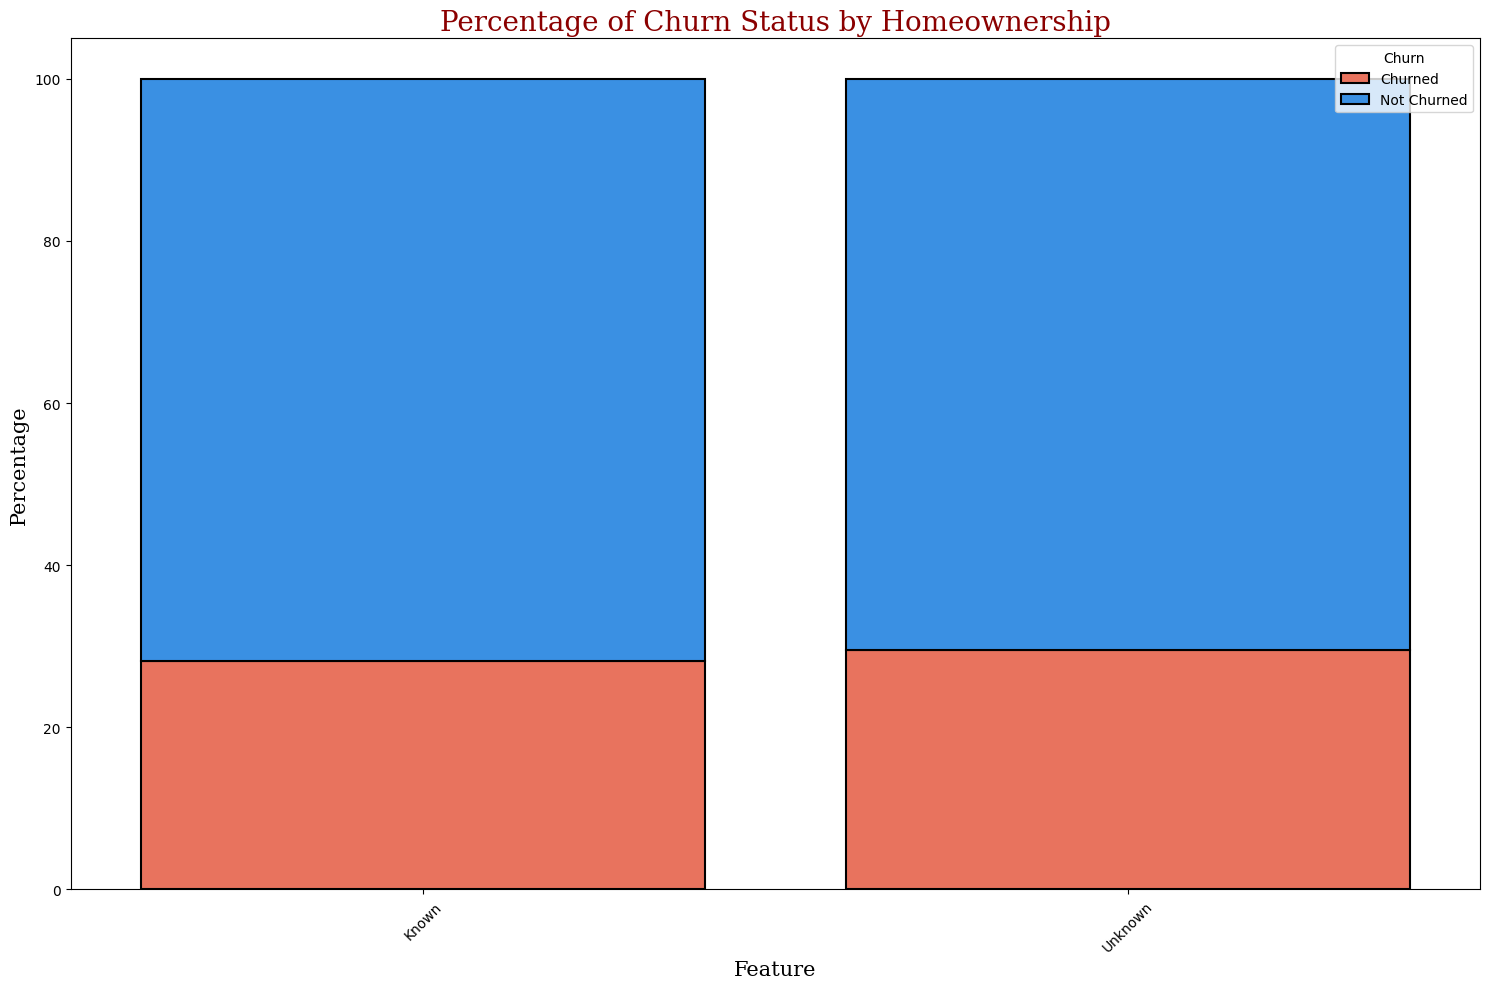

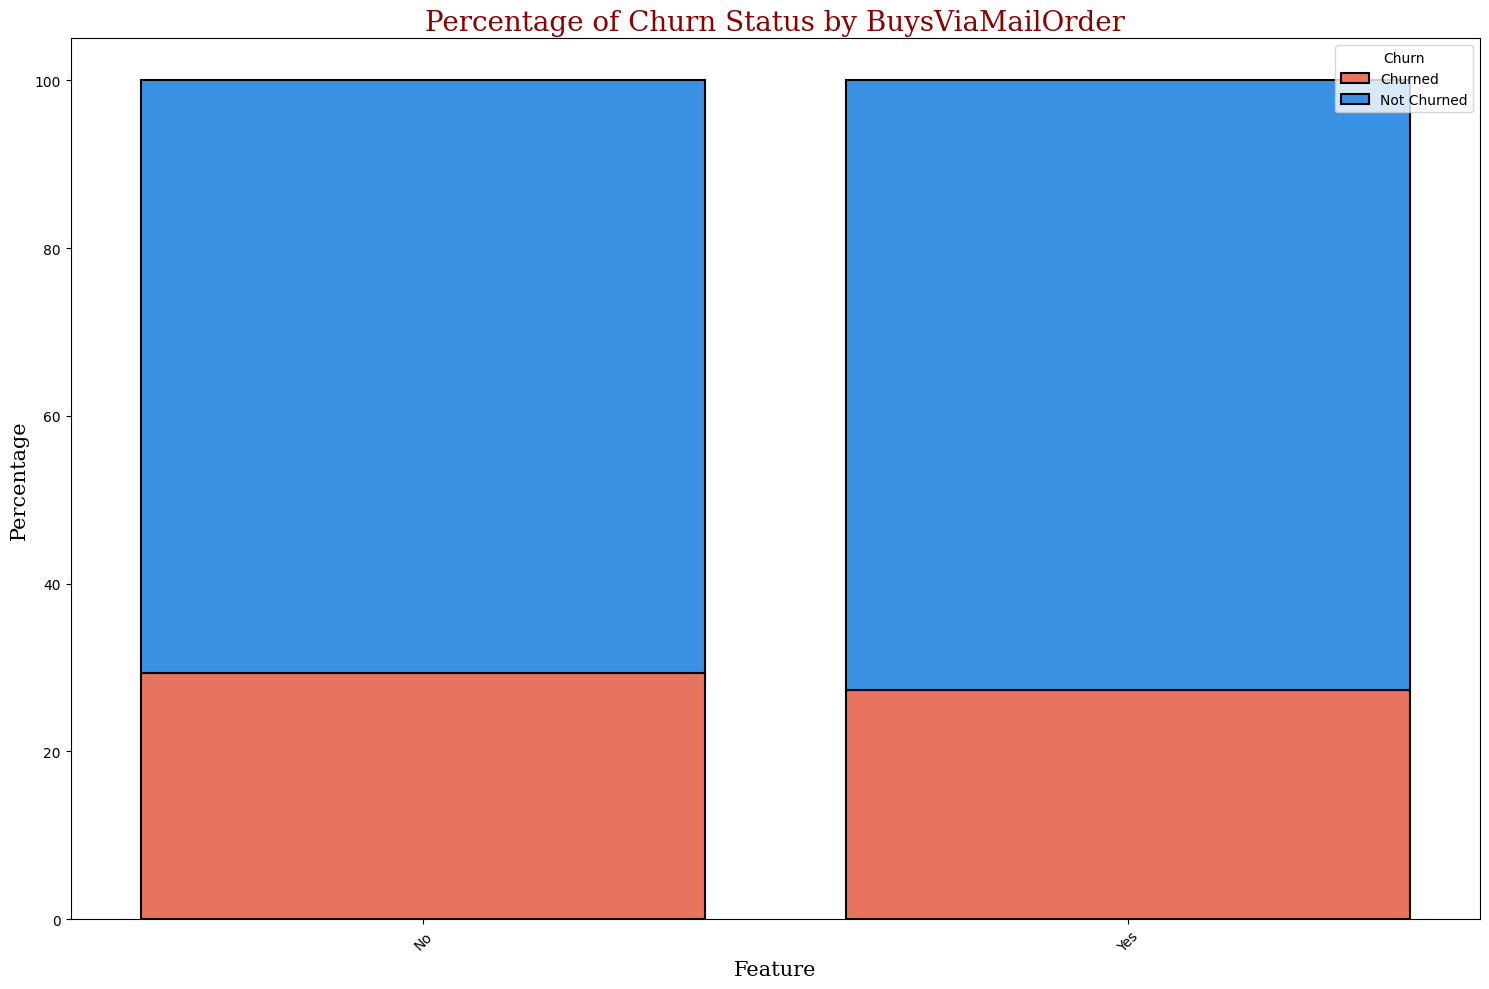

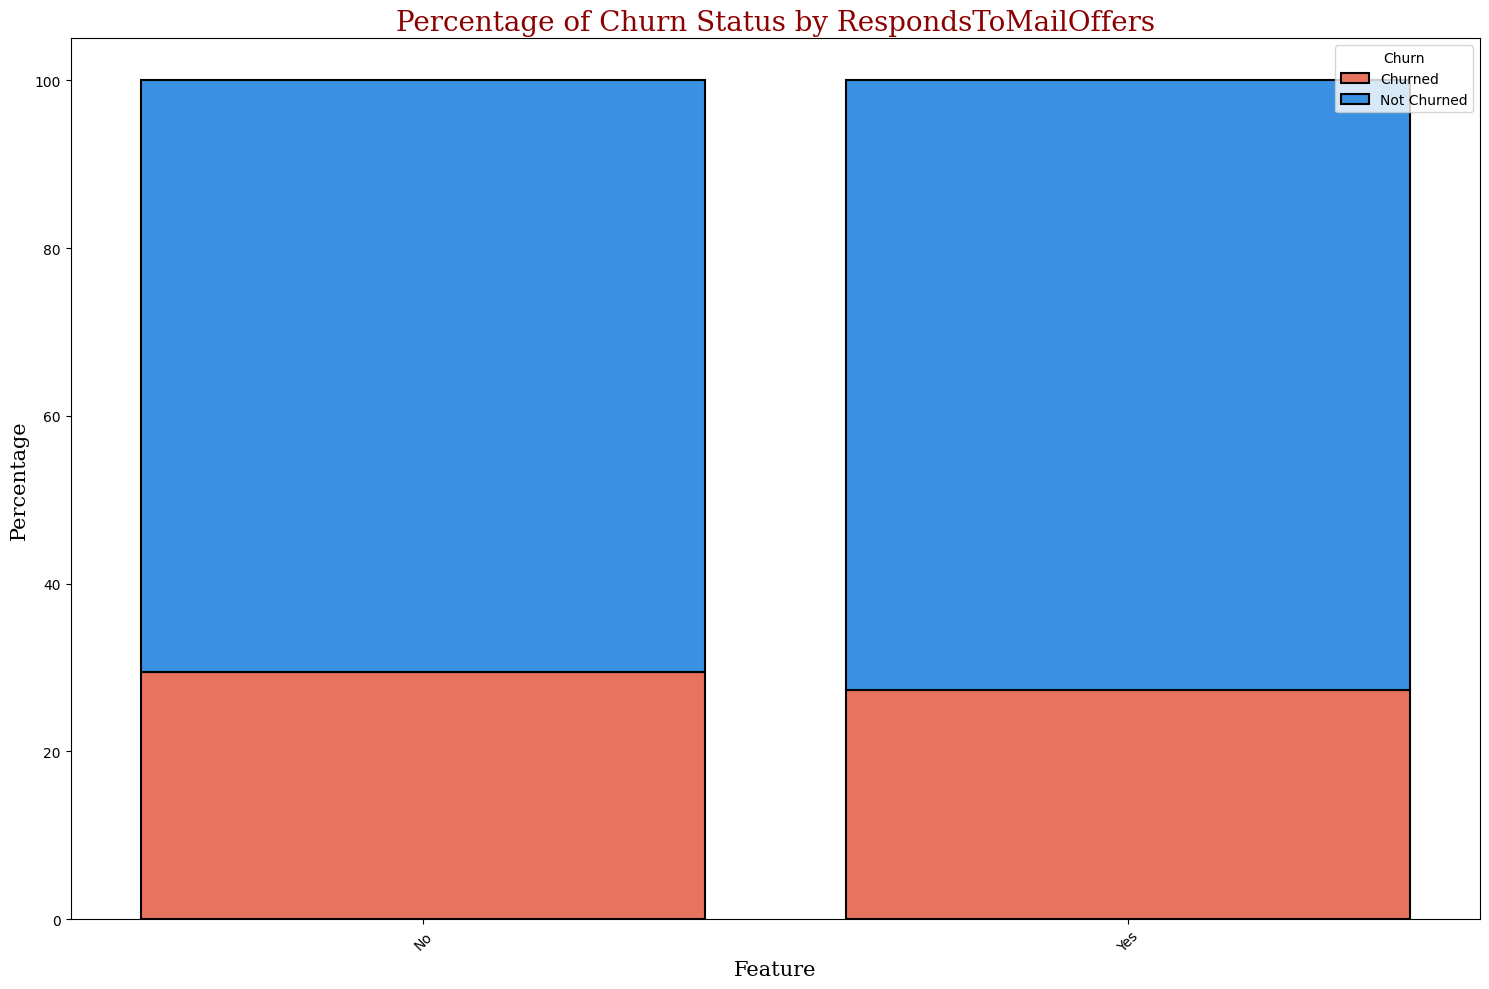

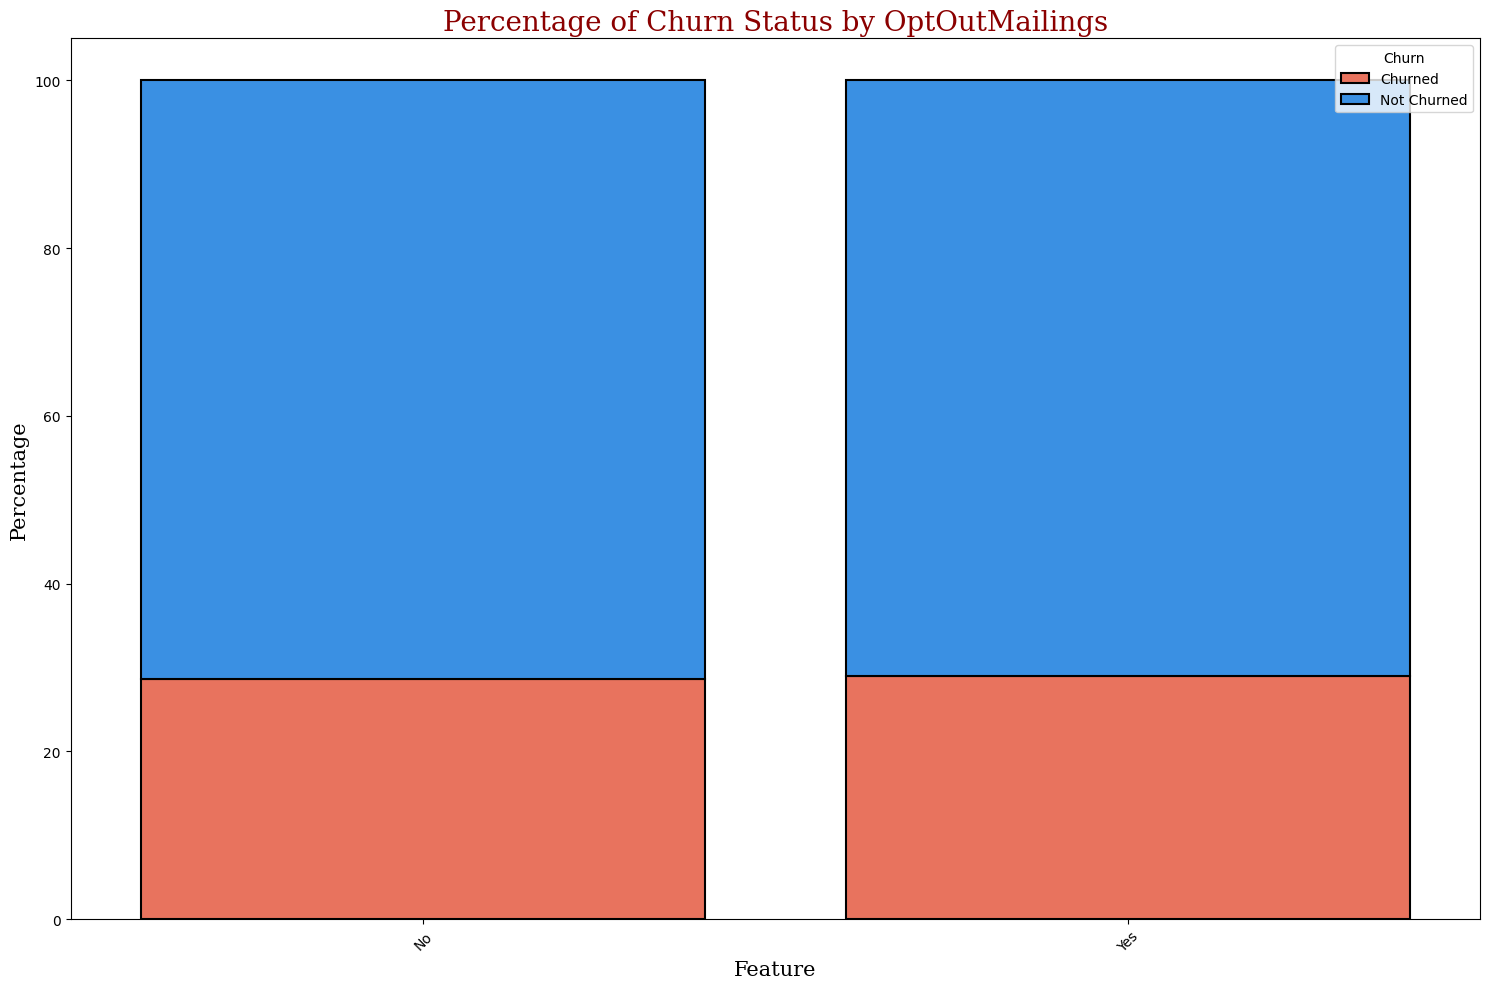

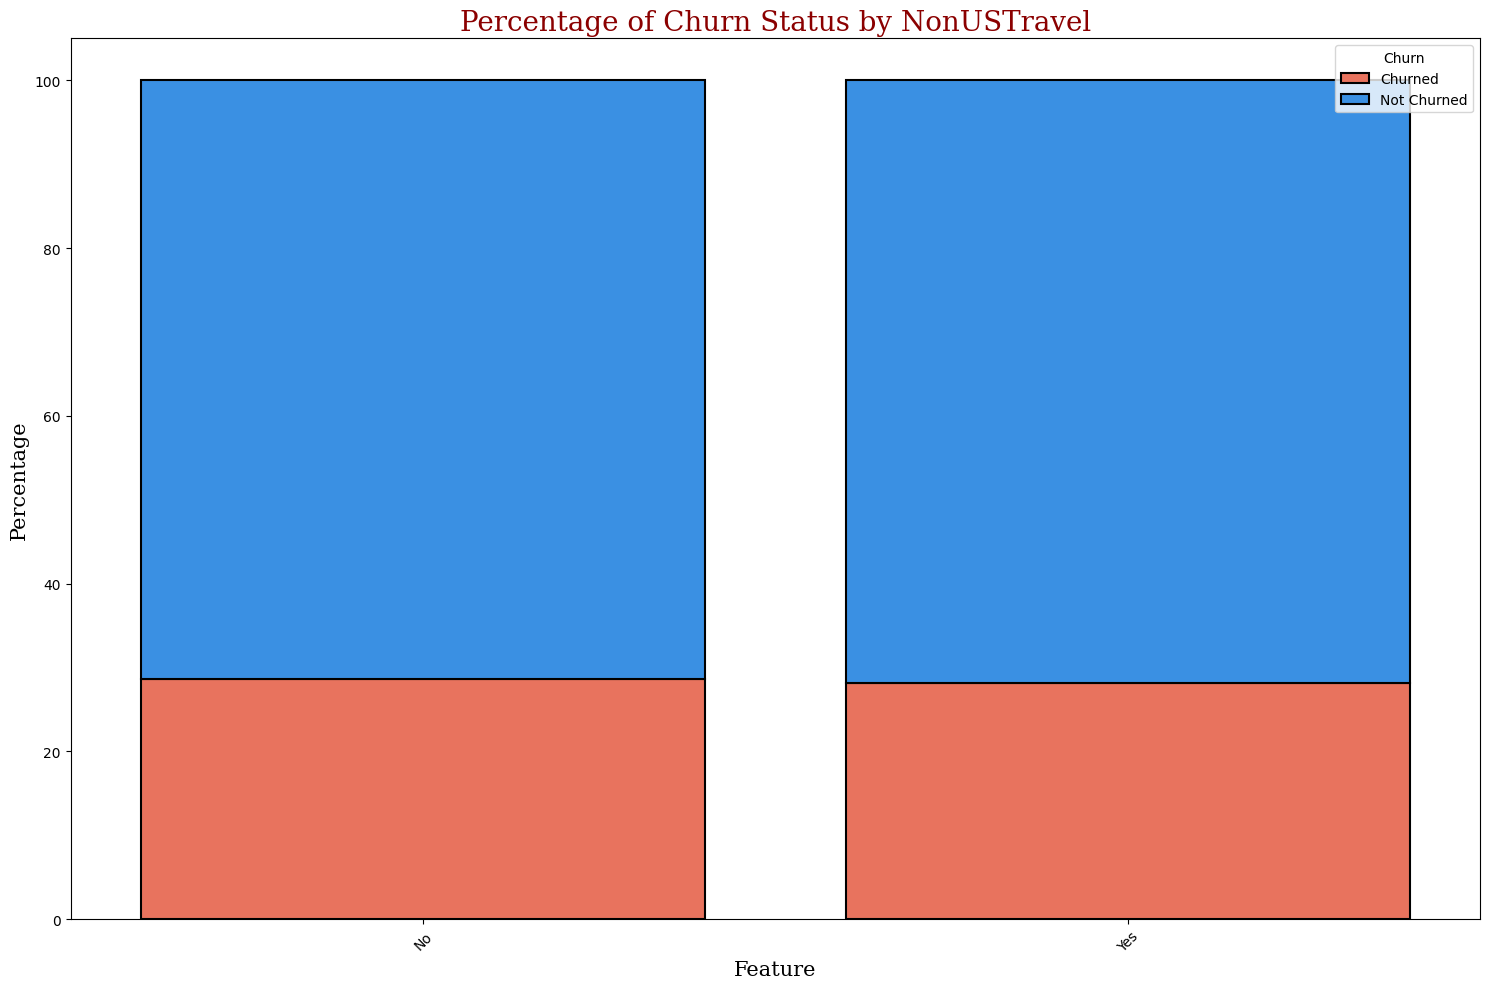

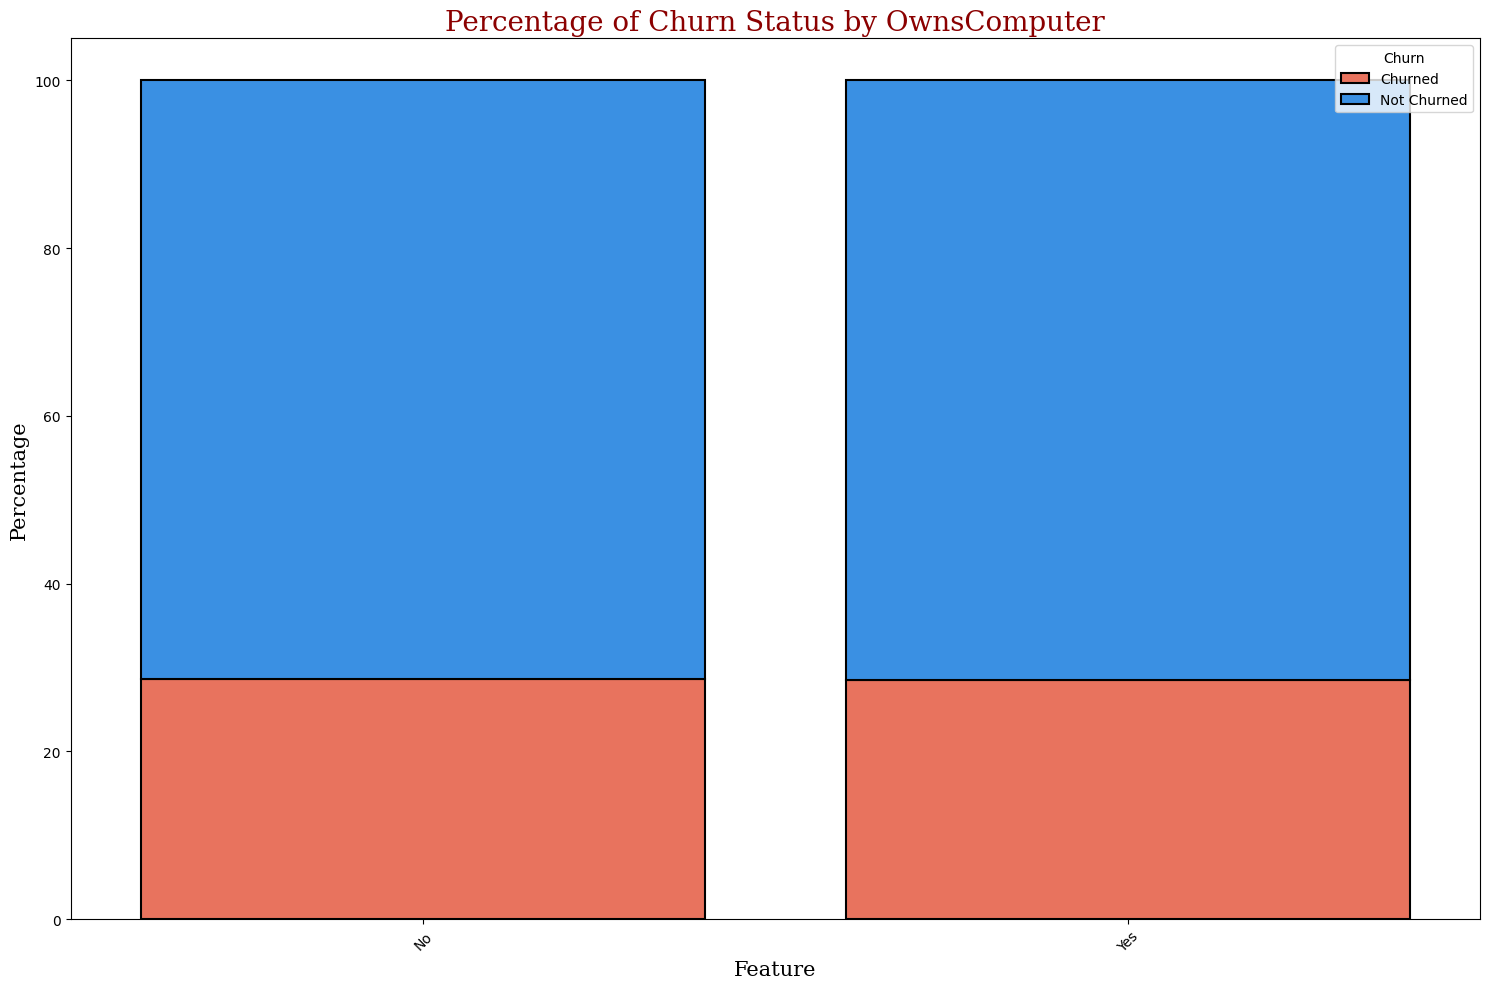

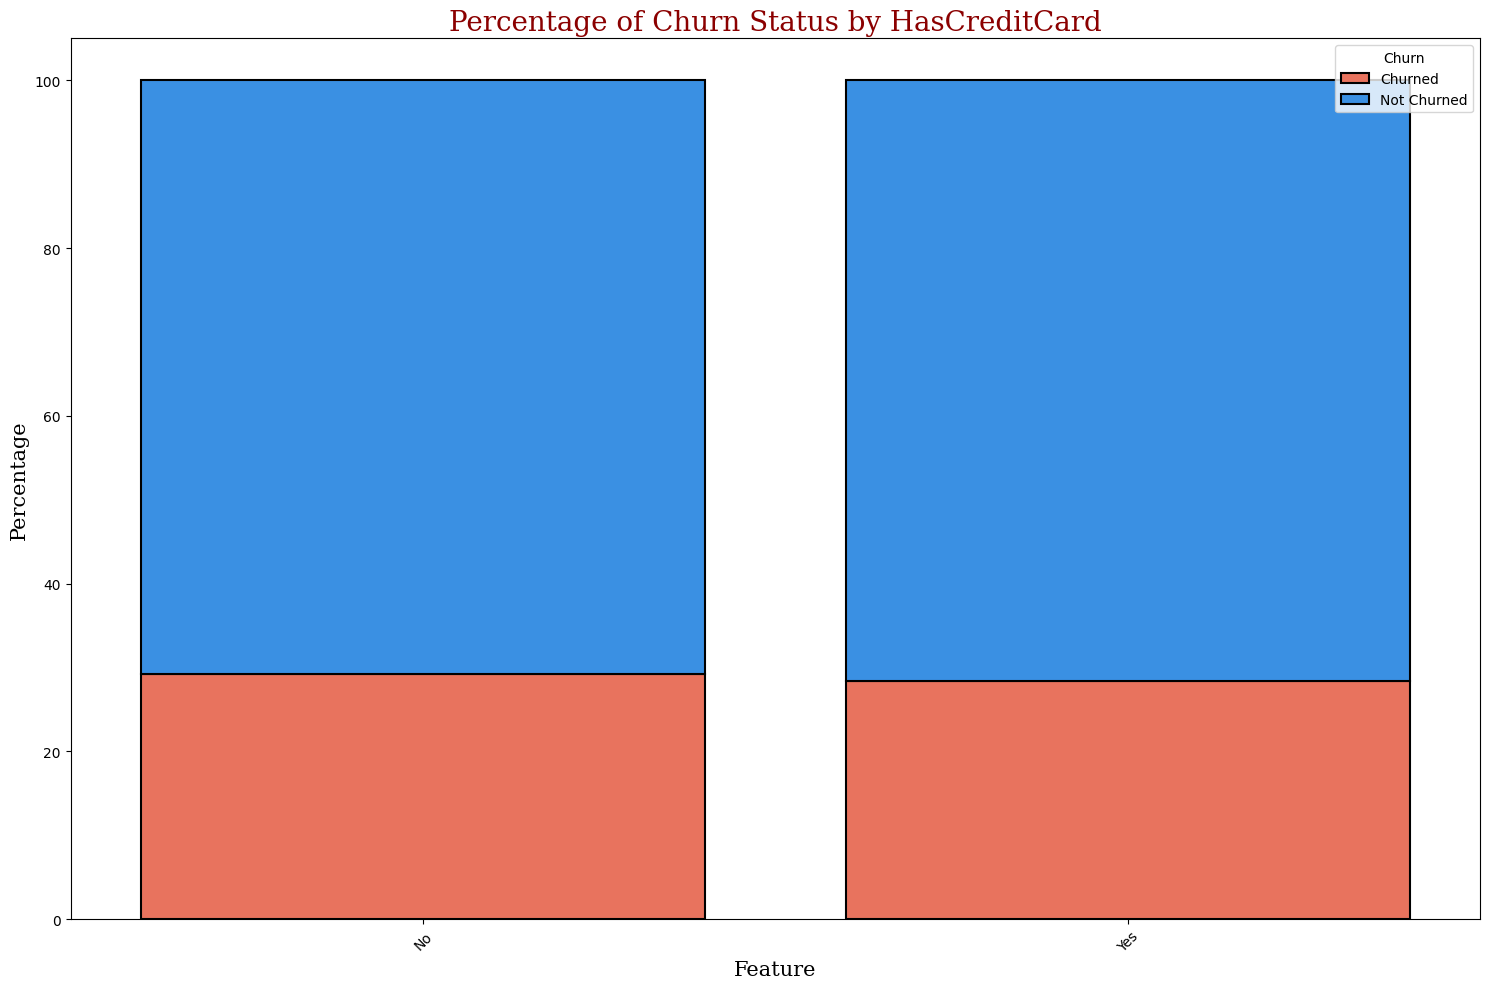

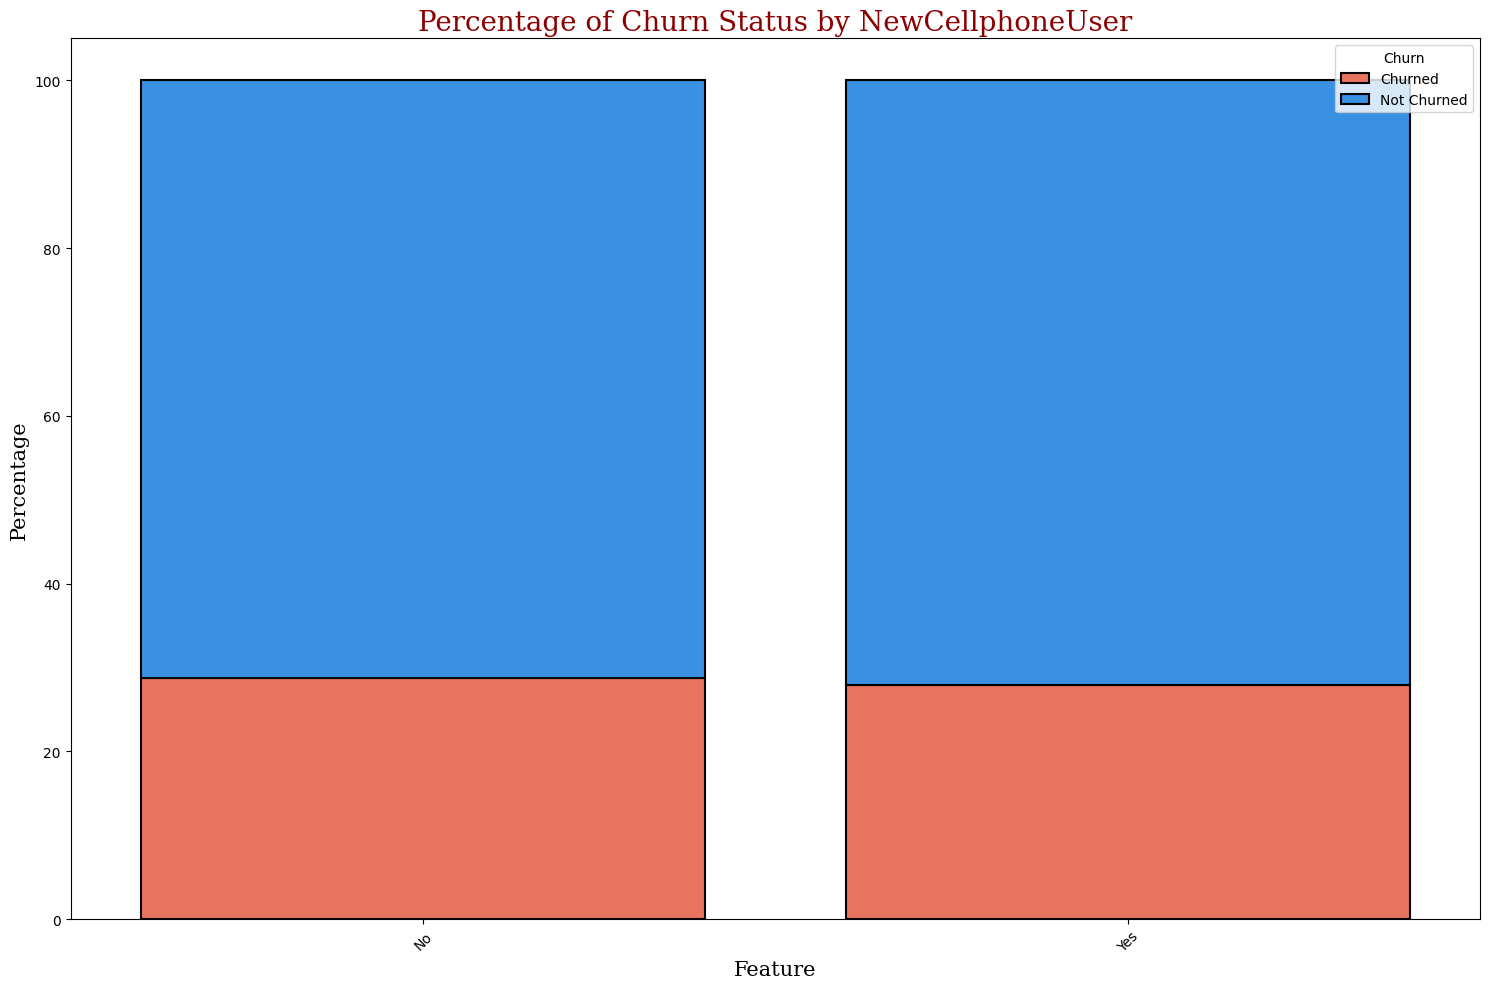

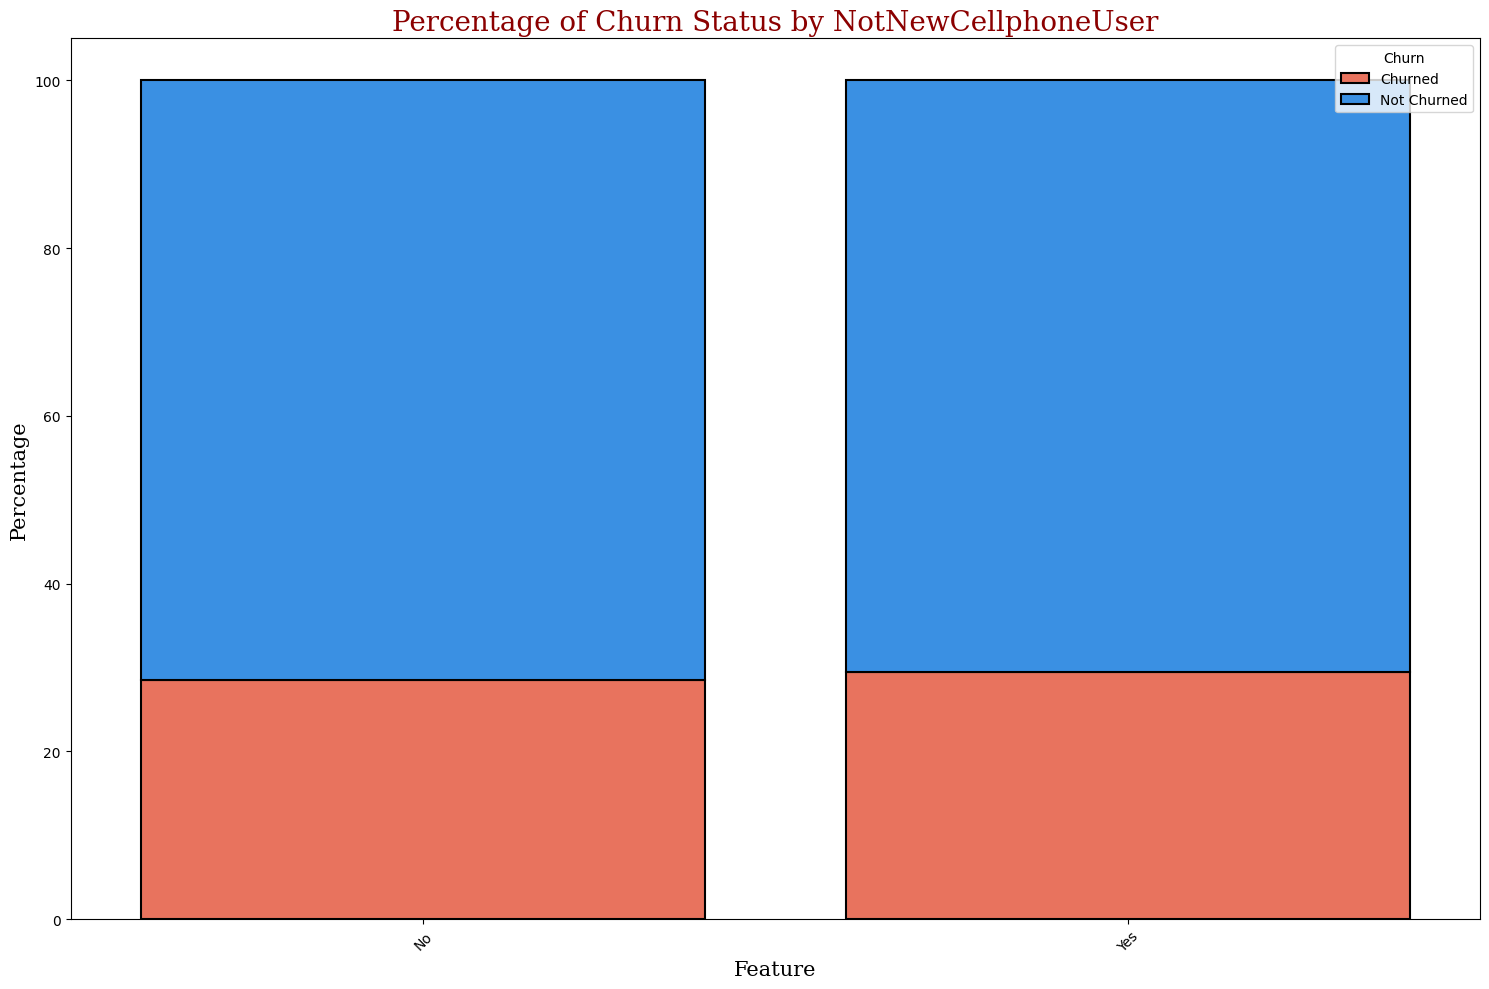

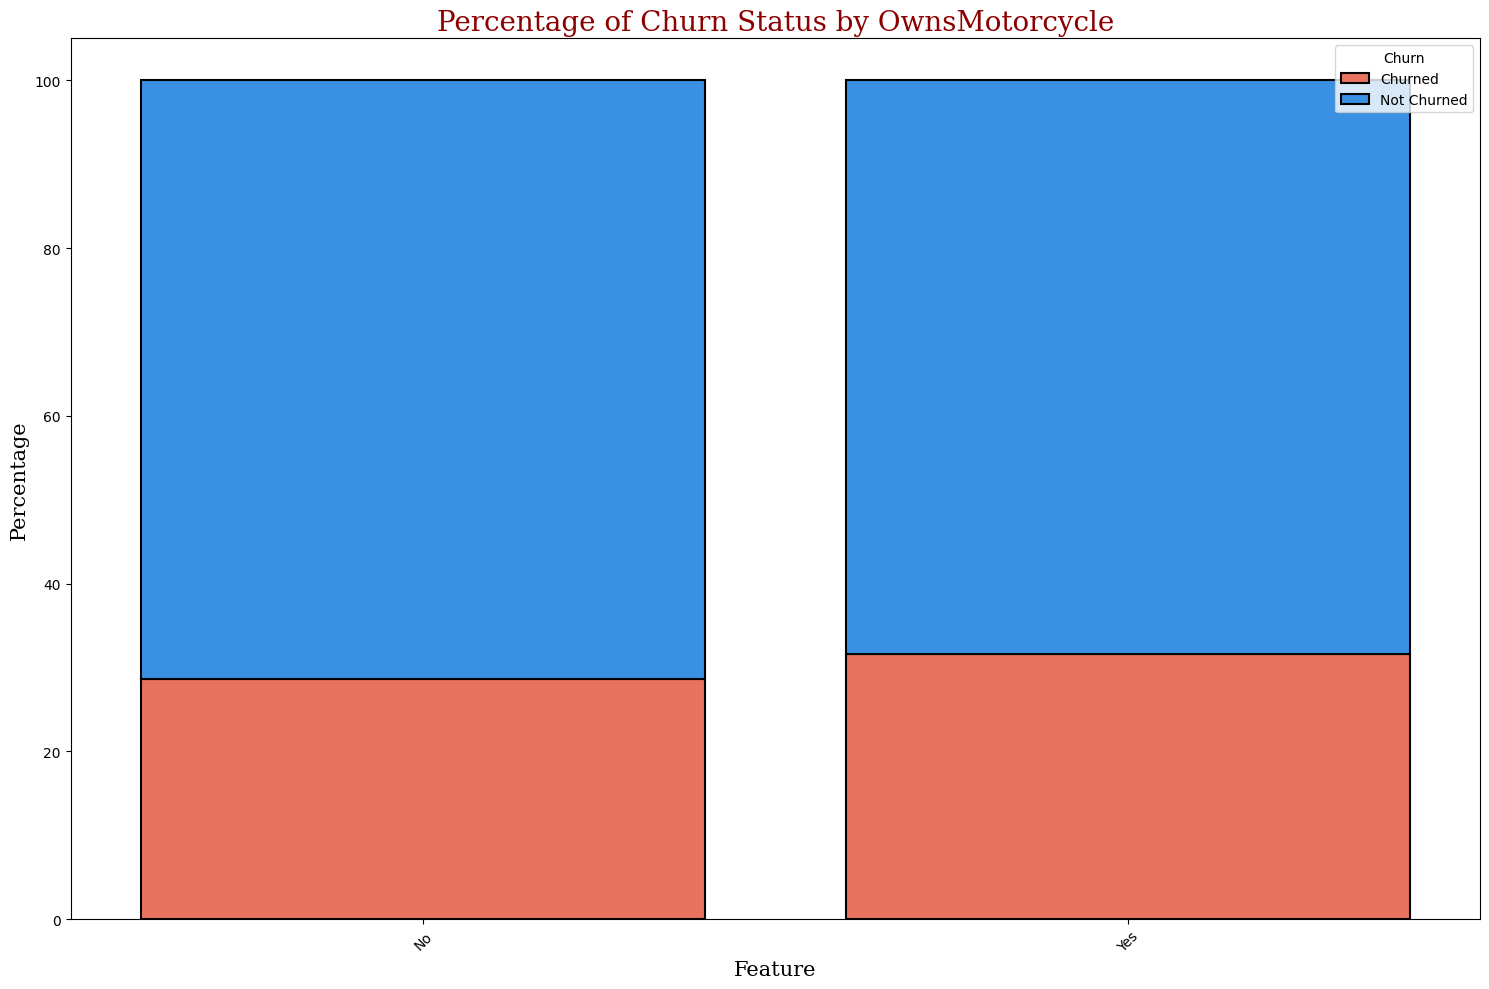

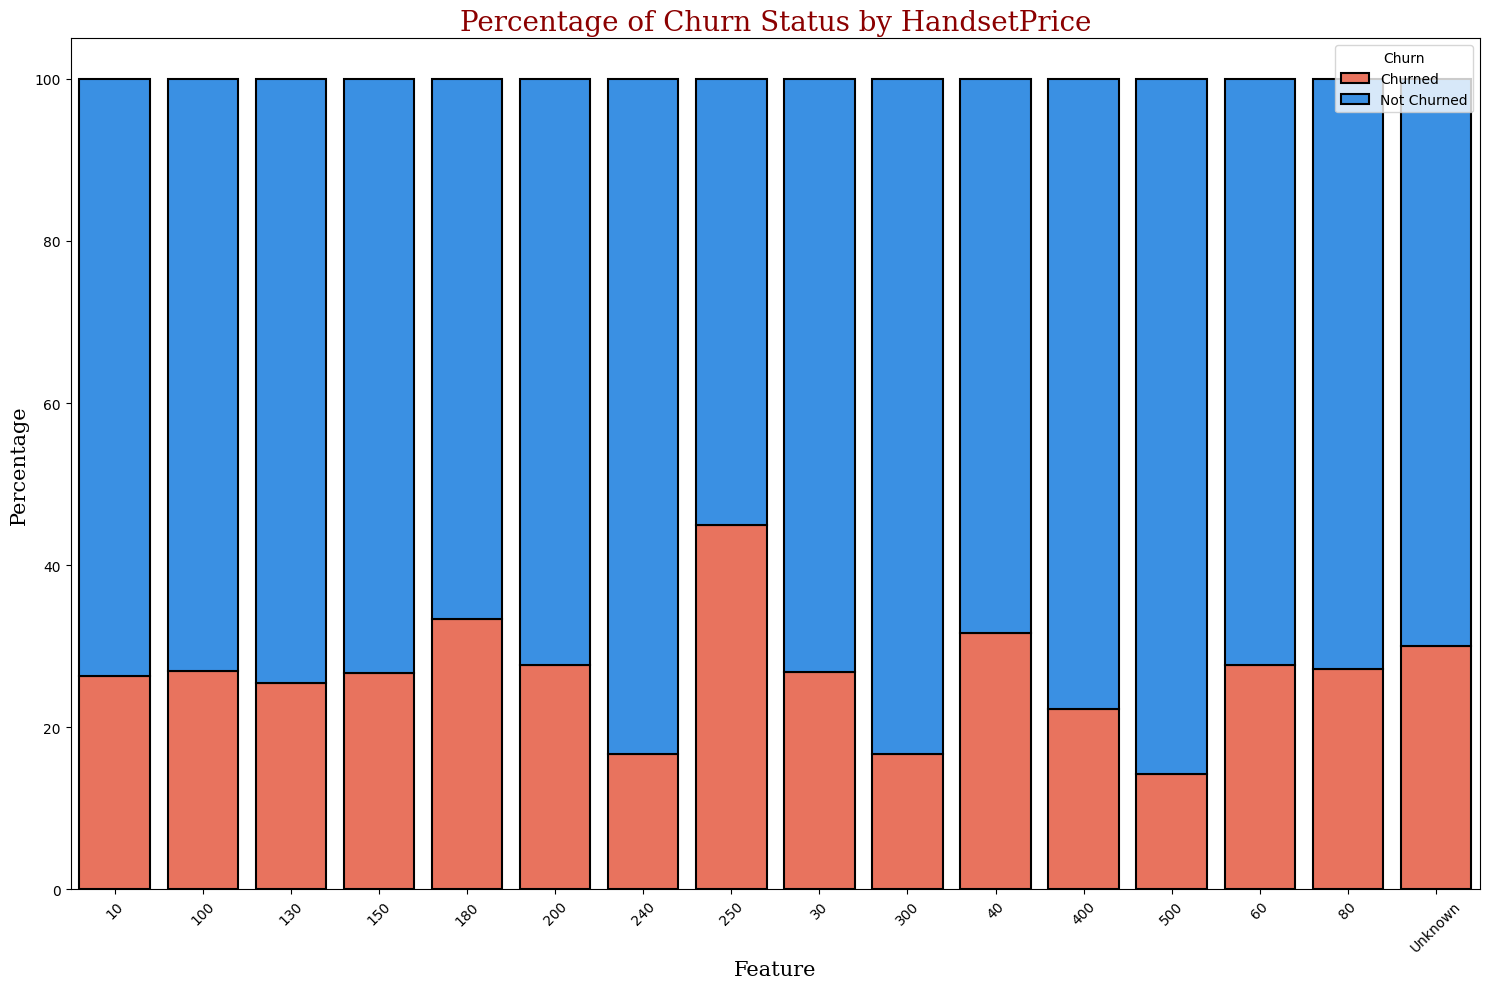

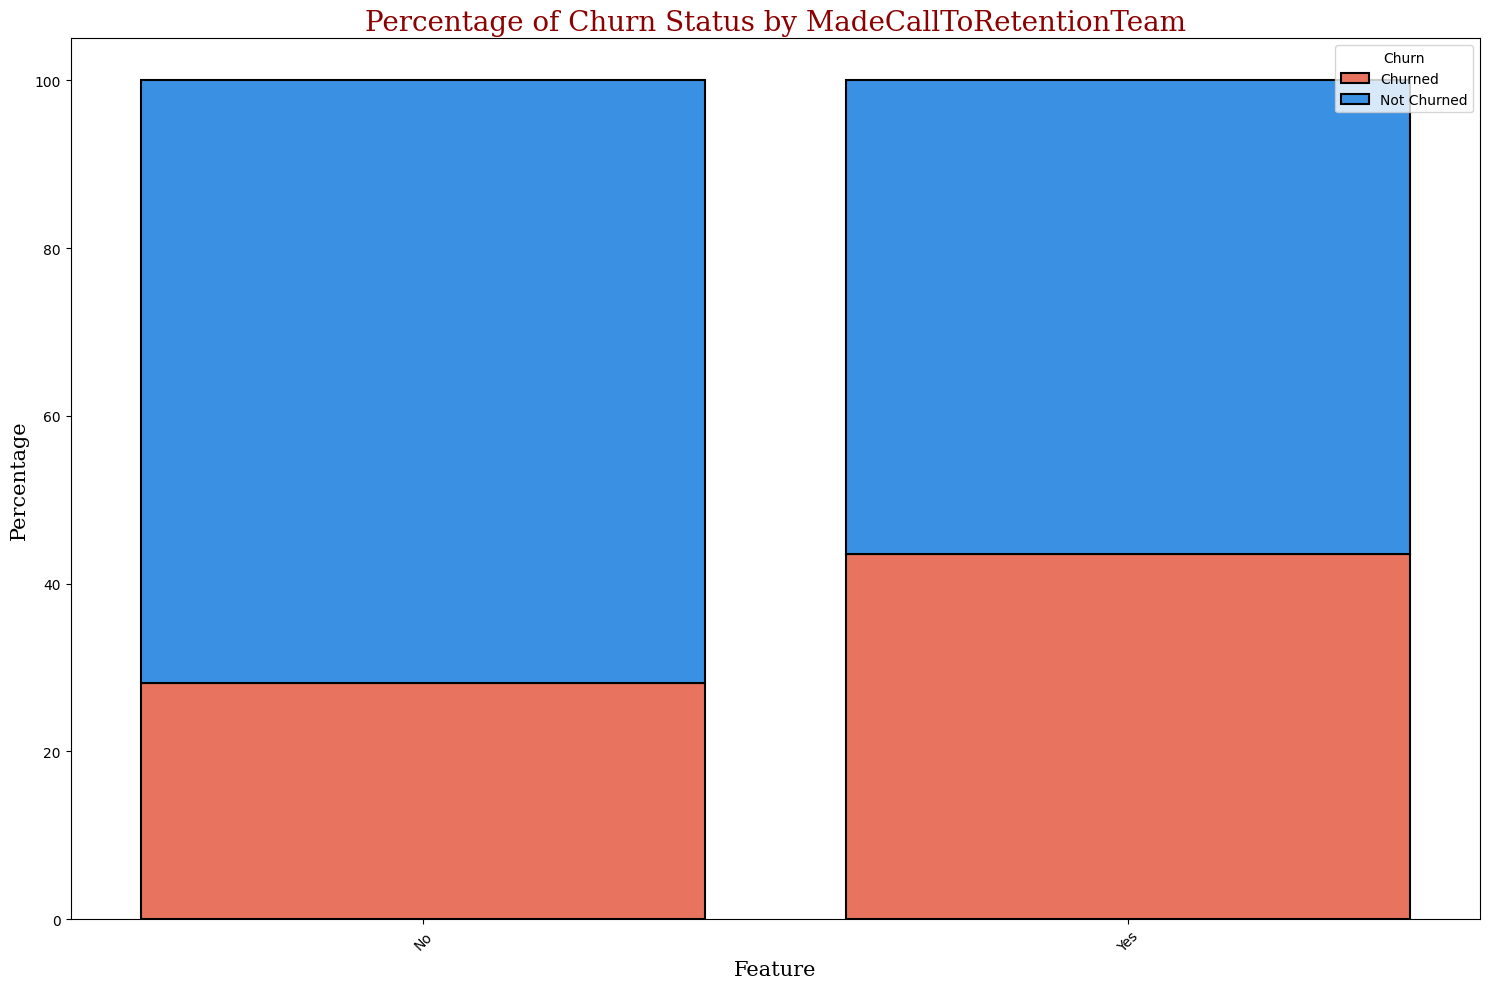

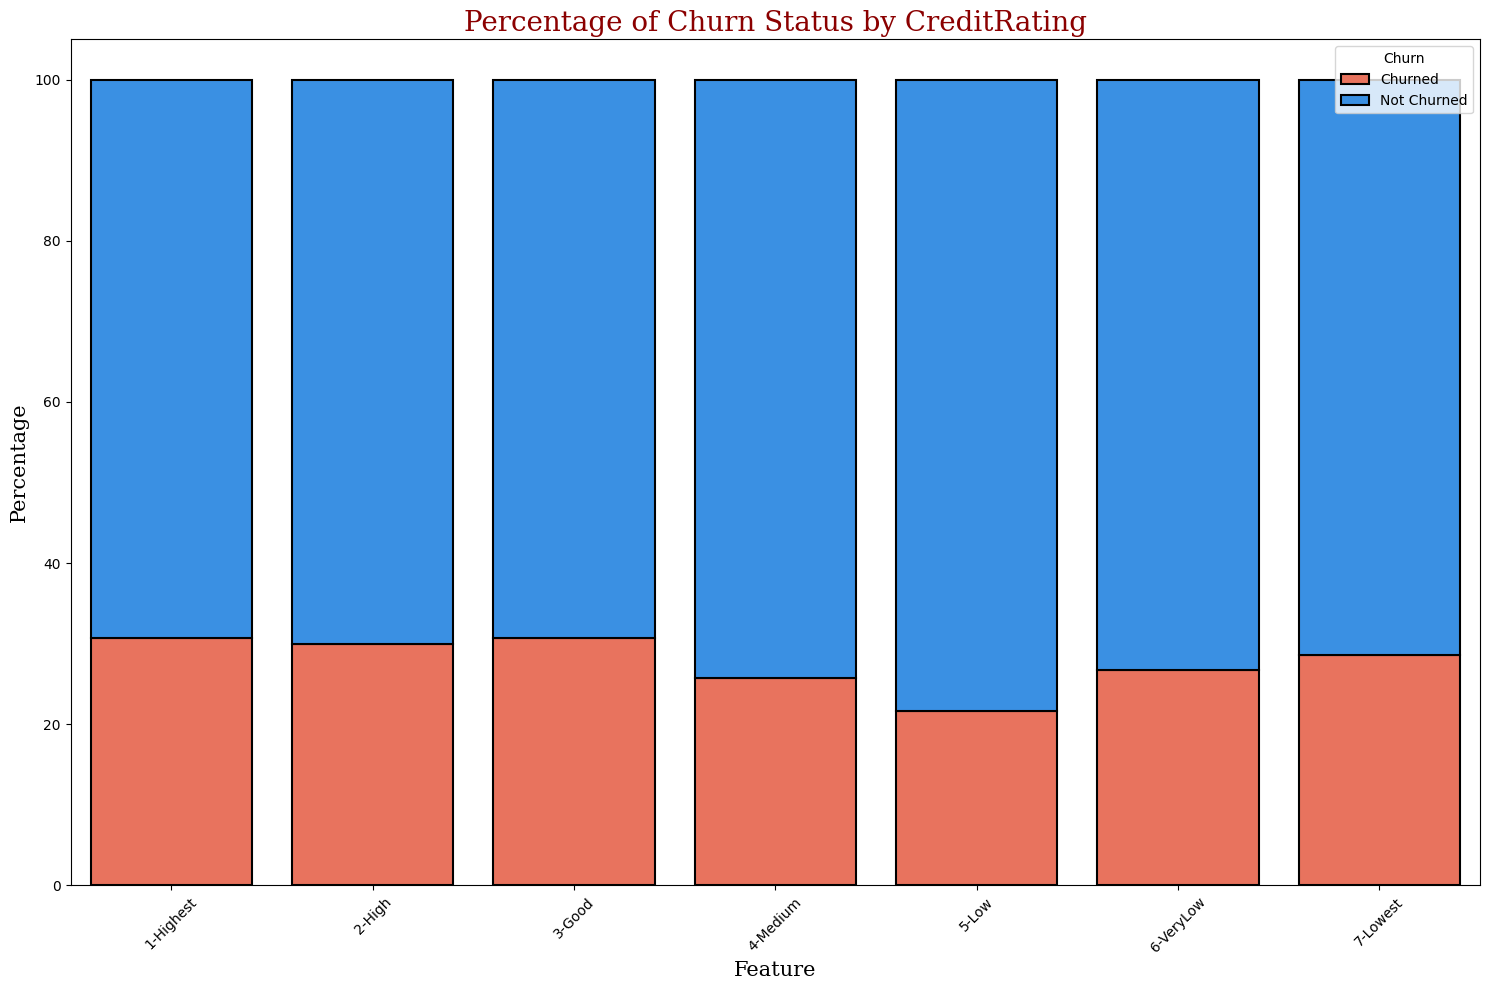

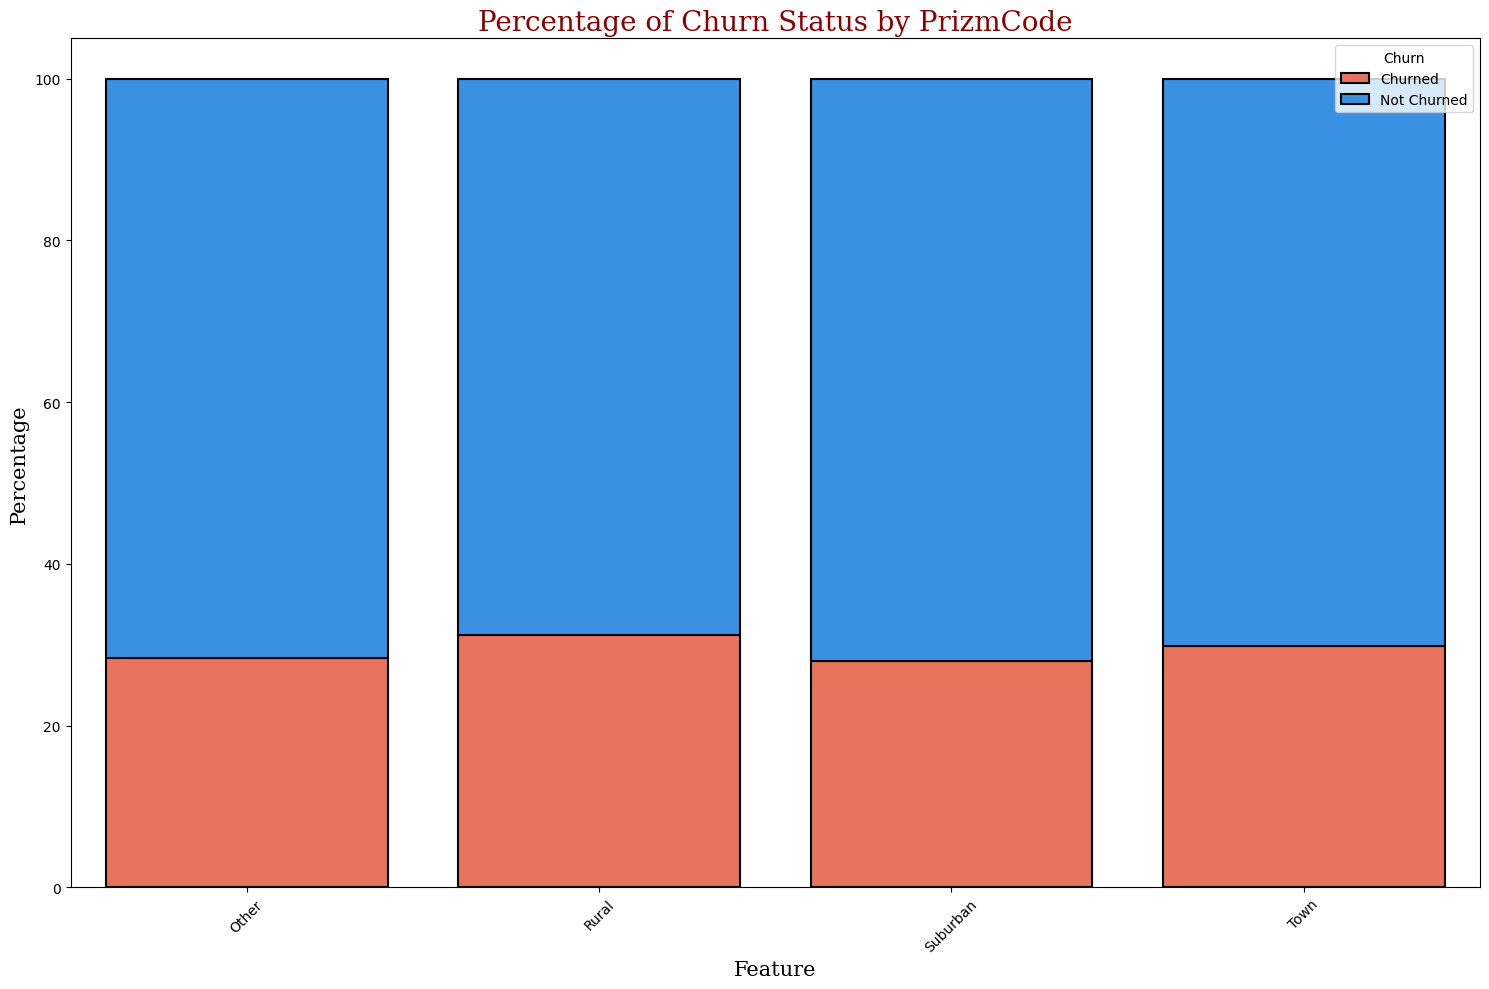

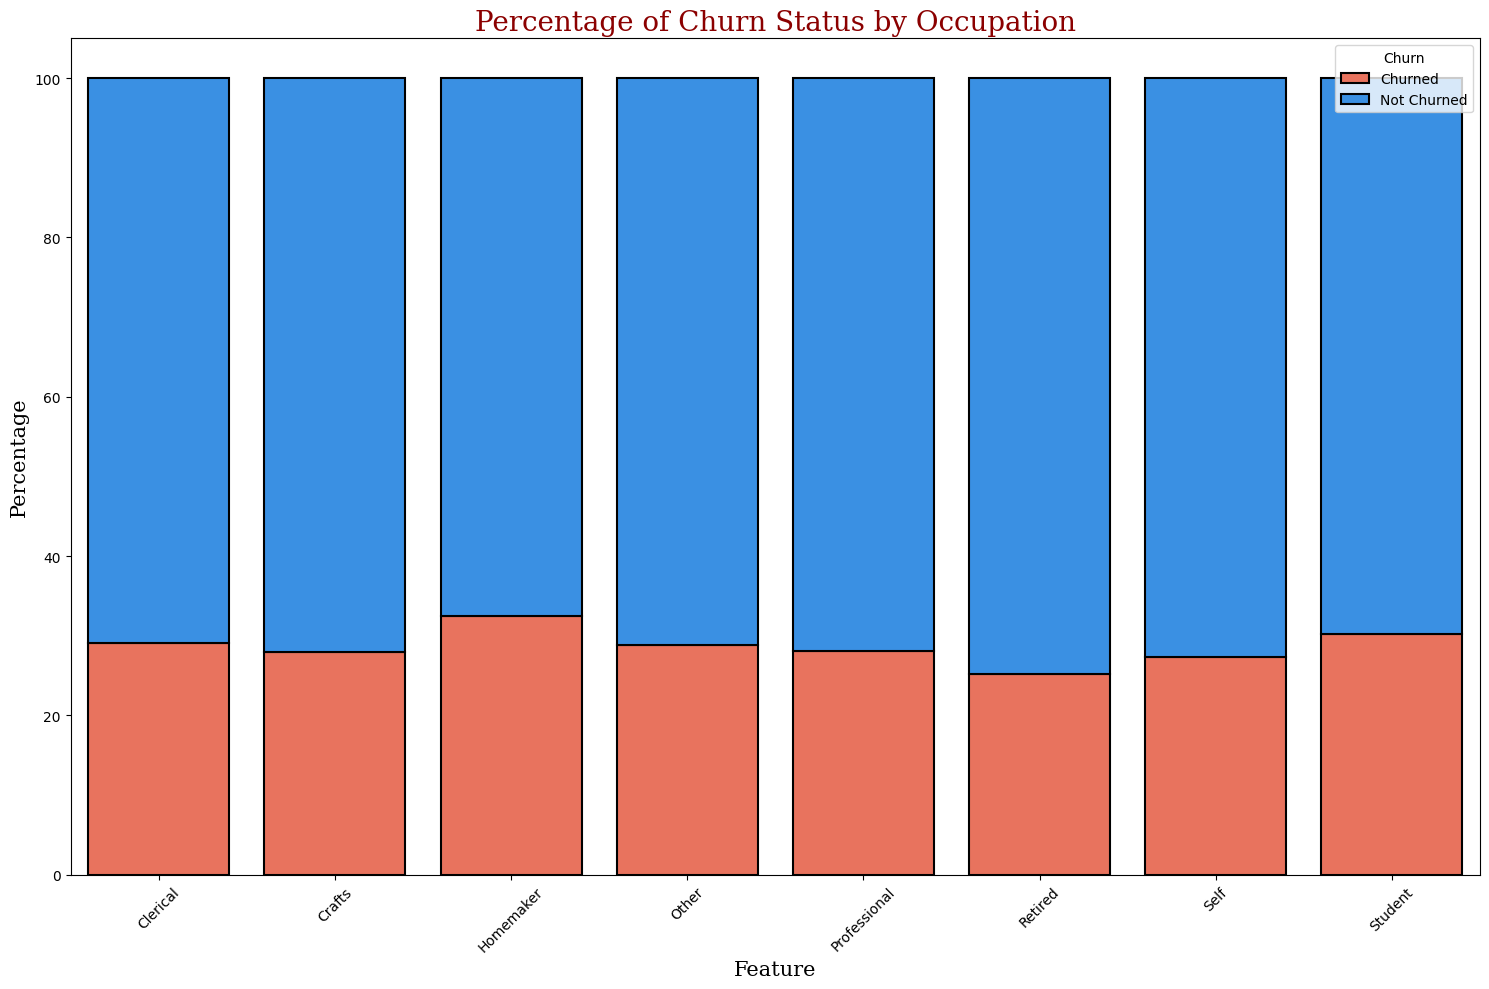

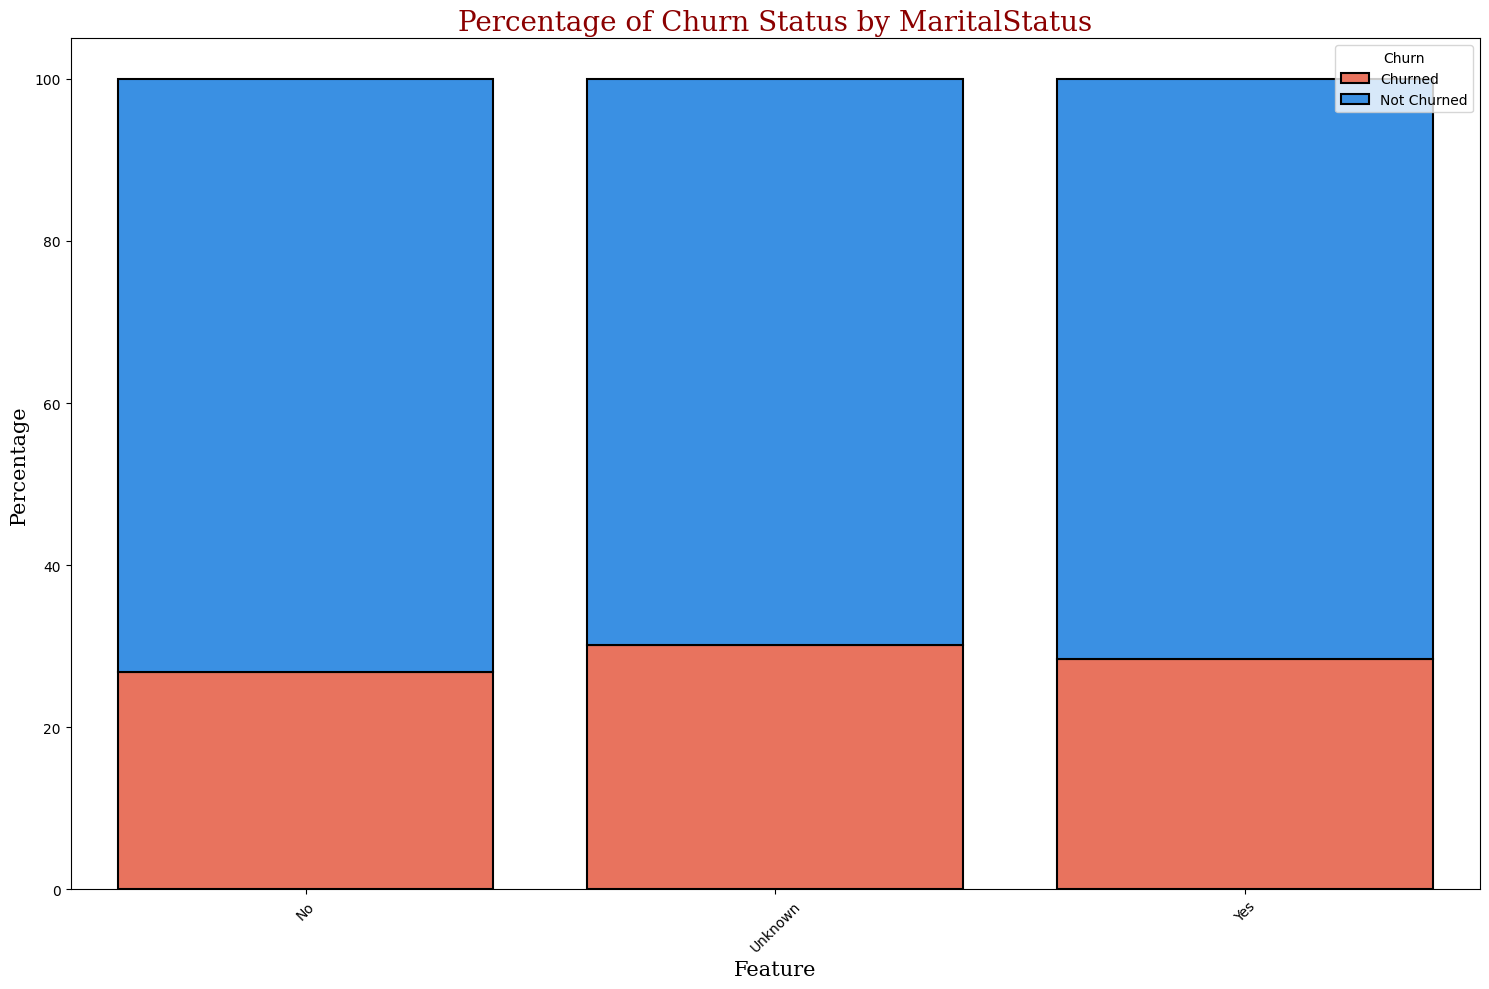

In [25]:
for feature in categorical_feats[2:] : 

    counts_df = df.groupby([feature, 'Churn']).size().unstack(fill_value=0)
    counts_df

    counts_df['Total'] = counts_df.sum(axis=1)
    percentage_df = counts_df[['Yes', 'No']].div(counts_df['Total'], axis=0) * 100
    percentage_df = percentage_df.reset_index()
    percentage_df.columns.name = None  
    percentage_df

    plt.figure(figsize=(15,10))

    sns.barplot(x=feature, y='Yes', data=percentage_df, color='#FF6347',
                label='Churned', edgecolor='black', linewidth=1.5)

    sns.barplot(x=feature, y='No', data=percentage_df, color='#1E90FF',
                bottom=percentage_df['Yes'], label='Not Churned',
                edgecolor='black', linewidth=1.5)

    plt.xlabel(f'Feature', fontdict=font2)
    plt.ylabel('Percentage', fontdict=font2)
    plt.title(f'Percentage of Churn Status by {feature}', fontdict=font1)
    plt.xticks(rotation=45)
    plt.legend(title='Churn', loc='upper right')
    plt.tight_layout()
    plt.show()  

In [ ]:
numerical_feats[1:4]

## Analysing numerical feature relations with churning - is there a visible relation?

<Figure size 768x576 with 0 Axes>

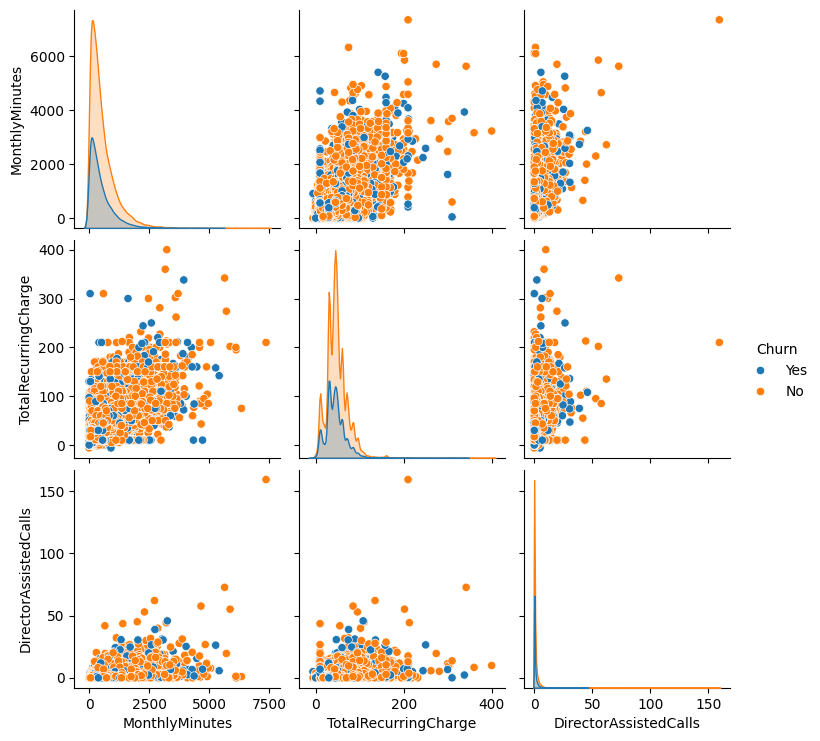

In [26]:
plt.figure(dpi=120)
sns.pairplot(df, hue='Churn', vars=numerical_feats[1:4])
plt.show()

In [ ]:
plt.figure(dpi=120)
sns.pairplot(df, hue='Churn', vars=numerical_feats[5:8], palette=[colors[-6],colors[-2]])
plt.show()

In [ ]:
plt.figure(dpi=120)
sns.pairplot(df, hue='Churn', vars=numerical_feats[9:12], palette=[colors[-6],colors[-2]])
plt.show()

In [ ]:
plt.figure(dpi=120)
sns.pairplot(df, hue='Churn', vars=numerical_feats[13:16], palette=[colors[-6],colors[-2]])
plt.show()

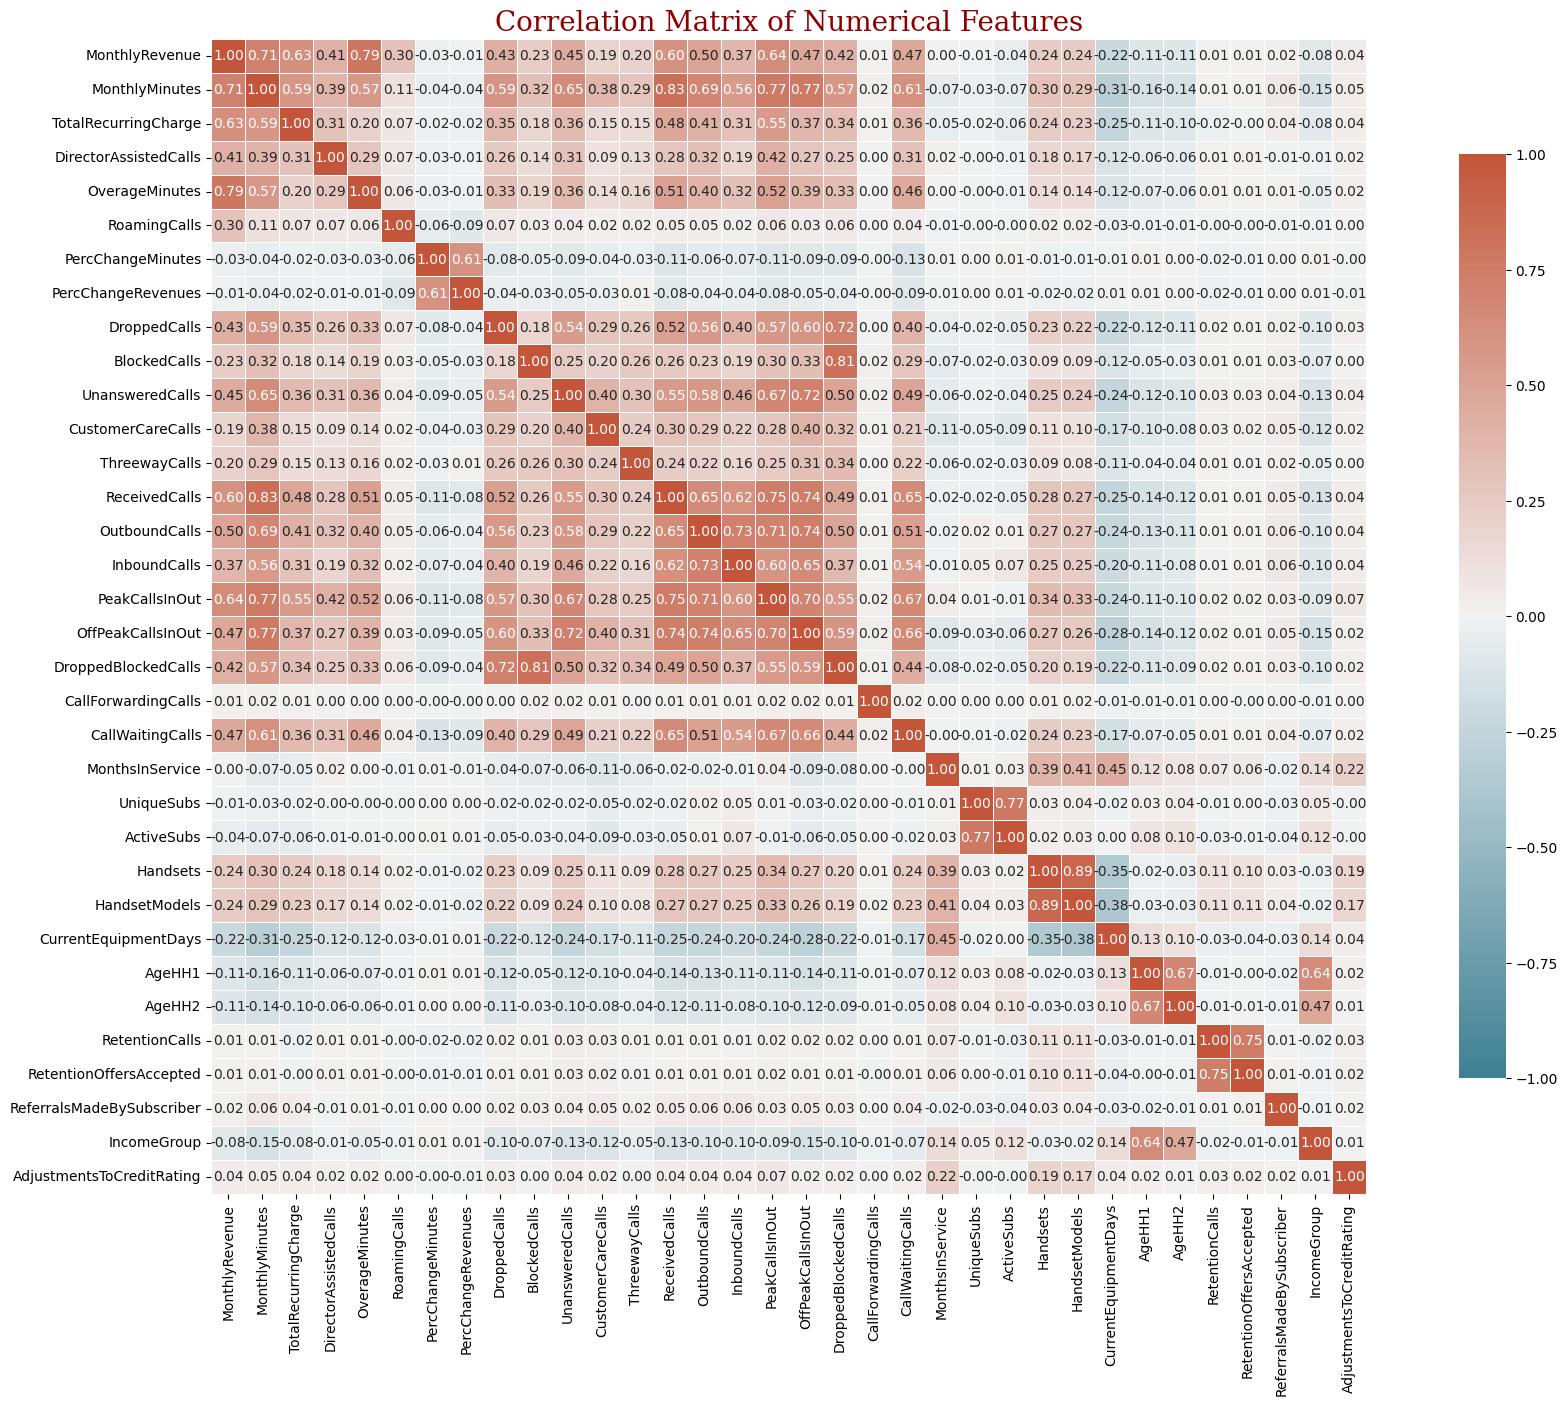

In [27]:
corr_matrix = df[numerical_feats].corr()
plt.figure(figsize=(24,15))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=cmap, vmin=-1, vmax=1,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numerical Features', fontdict=font1)
plt.show()

### It seems at first glance, there is not much overt relation between the features and the target, both through the pair plots and the correlation heatmap

#### It seems like these columns need some work :
#### AgeHH1, AgeHH2, contain a lot of 0 ages, which does not make sense
#### Marital status , HandsetPrice have a lot of unknowns
#### HouseOwnership seems like a redundant column

# Preprocessing

### We need to encode the categorical variables for the models, most are binary but some have more advanced ordering to them

In [120]:
df['Churn'] = df['Churn'].apply(lambda x:1 if x=='Yes' else 0)

In [121]:
categorical_feats

Index(['Churn', 'ServiceArea', 'ChildrenInHH', 'HandsetRefurbished',
       'HandsetWebCapable', 'TruckOwner', 'RVOwner', 'Homeownership',
       'BuysViaMailOrder', 'RespondsToMailOffers', 'OptOutMailings',
       'NonUSTravel', 'OwnsComputer', 'HasCreditCard', 'NewCellphoneUser',
       'NotNewCellphoneUser', 'OwnsMotorcycle', 'HandsetPrice',
       'MadeCallToRetentionTeam', 'CreditRating', 'PrizmCode', 'Occupation',
       'MaritalStatus'],
      dtype='object')

In [122]:
predictor_features = categorical_feats.delete([0,1,-1,-6])

In [123]:
for feature in predictor_features[:-3]:
    df[feature] = df[feature].apply (lambda x:1 if x=='Yes' else 0)

In [124]:
for feature in predictor_features[-3:]:
 print(df[feature].value_counts().index)

Index(['2-High', '1-Highest', '3-Good', '5-Low', '4-Medium', '7-Lowest',
       '6-VeryLow'],
      dtype='object', name='CreditRating')
Index(['Other', 'Suburban', 'Town', 'Rural'], dtype='object', name='PrizmCode')
Index(['Other', 'Professional', 'Crafts', 'Clerical', 'Self', 'Retired',
       'Student', 'Homemaker'],
      dtype='object', name='Occupation')


### Adding custom ordering to ordinal encoding 

In [35]:
predictor_features[-3:]

Index(['CreditRating', 'PrizmCode', 'Occupation'], dtype='object')

In [125]:
preprocessor=ColumnTransformer(transformers=[
    ('ordinal', OrdinalEncoder(categories=[['7-Lowest','6-VeryLow','5-Low','4-Medium','3-Good','2-High', '1-Highest'],
                                           ['Town', 'Rural','Other', 'Suburban'],
                                            ['Student', 'Homemaker', 'Retired', 'Crafts', 'Clerical', 'Self', 'Professional', 'Other']
                                           ]
                                            ), ['CreditRating', 'PrizmCode', 'Occupation'])
],
                              remainder='passthrough'
)

In [34]:
df_transformed = preprocessor.fit_transform(df)

In [38]:
all_features = preprocessor.get_feature_names_out()
actual_feature_names = [name.split('__')[-1] for name in all_features]
df_transformed = pd.DataFrame(df_transformed,columns=actual_feature_names)

In [39]:
df_transformed

CreditRating PrizmCode Occupation Churn MonthlyRevenue MonthlyMinutes  \
0              6.0       3.0        6.0     1           24.0          219.0   
1              3.0       3.0        6.0     1          16.99           10.0   
2              4.0       0.0        3.0     0           38.0            8.0   
3              3.0       2.0        7.0     0          82.28         1312.0   
4              6.0       2.0        6.0     1          17.14            0.0   
...            ...       ...        ...   ...            ...            ...   
49747          5.0       2.0        6.0     0            0.0           76.0   
49748          4.0       2.0        7.0     0          31.92           63.0   
49749          6.0       2.0        6.0     0          71.99          724.0   
49750          2.0       2.0        6.0     1         117.49          384.0   
49751          4.0       2.0        7.0     0          95.17         1745.0   

      TotalRecurringCharge DirectorAssistedCalls OverageMinutes RoamingCalls  \
0                     22.0                  0.25            0.0          0.0   
1                     17.0                   0.0            0.0          0.0   
2                     38.0                   0.0            0.0          0.0   
3                     75.0                  1.24            0.0          0.0   
4                     17.0                   0.0            0.0          0.0   
...                    ...                   ...            ...          ...   
49747                 30.0                   0.0            0.0          0.0   
49748                 17.0                   0.0           43.0          0.0   
49749                 70.0                   0.0            4.0          0.9   
49750                 30.0                   0.0          250.0          0.0   
49751                 85.0                  0.99           45.0          4.7   

       ... RetentionOffersAccepted NewCellphoneUser NotNewCellphoneUser  \
0      ...                       0                0                   0   
1      ...                       0                1                   0   
2      ...                       0                1                   0   
3      ...                       0                1                   0   
4      ...                       0                0                   1   
...    ...                     ...              ...                 ...   
49747  ...                       0                0                   0   
49748  ...                       0                0                   0   
49749  ...                       0                0                   0   
49750  ...                       0                0                   0   
49751  ...                       0                0                   0   

      ReferralsMadeBySubscriber IncomeGroup OwnsMotorcycle  \
0                             0           4              0   
1                             0           5              0   
2                             0           6              0   
3                             0           6              0   
4                             0           9              0   
...                         ...         ...            ...   
49747                         0           4              0   
49748                         0           3              0   
49749                         0           7              0   
49750                         0           2              0   
49751                         0           9              0   

      AdjustmentsToCreditRating HandsetPrice MadeCallToRetentionTeam  \
0                             0           30                       1   
1                             0           30                       0   
2                             0      Unknown                       0   
3                             0           10                       0   
4                             1           10                       0   
...               

In [31]:
features_df = df_transformed.copy()

#### This was some experimental transformation/processing I did , but it did not improve the performance of the models much, infact , keeping the outliers improves the churn positive prediction, which makes sense because most of the samples were not churn, so some feature values for positive churn might be detected as outliers

In [43]:
# outlier_rows = IQR_method(features_df,10,numerical_feats[1:])

In [44]:
# features_df = features_df.drop(outlier_rows,axis=0)

In [45]:
# features_df['Churn'].value_counts()

In [46]:
# X_marital = features_df[features_df['MaritalStatus']!='Unknown'].drop(['Churn','Homeownership','MaritalStatus','HandsetPrice','ServiceArea'],axis=1).astype(float)
# y_marital = features_df[features_df['MaritalStatus']!='Unknown']['MaritalStatus'].apply(lambda x:1 if x=='Yes' else 0)

In [47]:
# X_train_marital,X_test_marital,y_train_marital,y_test_marital = train_test_split(X_marital,y_marital,test_size=0.1,random_state=1)

In [48]:
# undersampler = RandomUnderSampler(sampling_strategy='auto',random_state=1)

In [49]:

# X_train_marital,y_train_marital = undersampler.fit_resample(X_train_marital,y_train_marital)

In [50]:
# from xgboost import XGBClassifier
# xgb = XGBClassifier()
# xgb.fit(X_train_marital,y_train_marital)

In [51]:
# evaluate_model(xgb,X_test_marital,y_test_marital)

In [52]:
# n_estimators = [100, 300, 700, 1000]
# subsample = [0.3,0.5,0.7,1.0]
# max_depth = [2,4,10,20]
# xgb_grid = dict(n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)
# xgb_model = tune_model(xgb,xgb_grid,'recall_macro',X_train_marital,y_train_marital)

In [53]:
# evaluate_model(xgb_model,X_test_marital,y_test_marital)

In [54]:
# marital_status = xgb.predict(features_df[features_df['MaritalStatus']=='Unknown'].drop(['Churn','Homeownership','MaritalStatus','HandsetPrice','ServiceArea'],axis=1).astype(float))
# marital_status = np.array(marital_status).reshape(-1,)
# marital_status

In [55]:
# features_df.loc[features_df[features_df['MaritalStatus']=='Unknown'].index,'MaritalStatus'] = marital_status

In [56]:
# X_price = features_df[features_df['HandsetPrice']!='Unknown'].drop(['Churn','Homeownership','HandsetPrice','MaritalStatus','ServiceArea'],axis=1).astype(float)   
# y_price = features_df[features_df['HandsetPrice']!='Unknown']['HandsetPrice'].astype(int)          

In [57]:
# X_train_price,X_test_price,y_train_price,y_test_price = train_test_split(X_price,y_price,test_size=0.1,random_state=1)

In [58]:
# y_train_price.value_counts()

In [59]:
# from xgboost import XGBRegressor
# xgb = XGBRegressor()
# xgb.fit(X_train_price,y_train_price)

In [60]:
# xgb_regressor = tune_regressor(xgb,xgb_grid,X_train_price,y_train_price)

In [61]:
# evaluate_regressor(xgb,X_test_price,y_test_price)

In [62]:
# price = xgb.predict(features_df[features_df['HandsetPrice']=='Unknown'].drop(['Churn','Homeownership','MaritalStatus','HandsetPrice','ServiceArea'],axis=1).astype(float))
# price = np.array(price).reshape(-1,)
# price = abs(price)
# price.max()

In [63]:
# features_df.loc[features_df[features_df['HandsetPrice']=='Unknown'].index,'HandsetPrice'] = price

In [64]:
# features_df['MaritalStatus'].replace('Yes',1,inplace=True)
# features_df['MaritalStatus'].replace('No',0,inplace=True)

In [126]:
y = df['Churn'].astype(np.int64)
df.drop('Churn',axis=1,inplace=True)

In [127]:
X = df.drop(['ServiceArea','Homeownership','MaritalStatus','HandsetPrice'],axis=1)

In [128]:
features_before_transformer = X.columns

In [129]:
features_before_split = df.columns

In [61]:
with open('Feats.pkl','wb') as f:
    pickle.dump(features_before_transformer,f)

In [62]:
with open('PreFeats.pkl','wb') as f:
    pickle.dump(features_before_split,f)

In [130]:
X

MonthlyRevenue  MonthlyMinutes  TotalRecurringCharge  \
0               24.00           219.0                  22.0   
1               16.99            10.0                  17.0   
2               38.00             8.0                  38.0   
3               82.28          1312.0                  75.0   
4               17.14             0.0                  17.0   
...               ...             ...                   ...   
51035            0.00            76.0                  30.0   
51037           31.92            63.0                  17.0   
51040           71.99           724.0                  70.0   
51041          117.49           384.0                  30.0   
51043           95.17          1745.0                  85.0   

       DirectorAssistedCalls  OverageMinutes  RoamingCalls  PercChangeMinutes  \
0                       0.25             0.0           0.0             -157.0   
1                       0.00             0.0           0.0               -4.0   
2                       0.00             0.0           0.0               -2.0   
3                       1.24             0.0           0.0              157.0   
4                       0.00             0.0           0.0                0.0   
...                      ...             ...           ...                ...   
51035                   0.00             0.0           0.0                0.0   
51037                   0.00            43.0           0.0              -38.0   
51040                   0.00             4.0           0.9              -40.0   
51041                   0.00           250.0           0.0                0.0   
51043                   0.99            45.0           4.7              122.0   

       PercChangeRevenues  DroppedCalls  BlockedCalls  ...  NewCellphoneUser  \
0                   -19.0           0.7           0.7  ...                 0   
1                     0.0           0.3           0.0  ...                 1   
2                     0.0           0.0           0.0  ...                 1   
3                     8.1          52.0           7.7  ...                 1   
4                    -0.2           0.0           0.0  ...                 0   
...                   ...           ...           ...  ...               ...   
51035                 0.0           5.7           1.0  ...                 0   
51037               -13.2           0.7           0.0  ...                 0   
51040                -2.0          14.3           1.0  ...                 0   
51041                 0.0           4.0           1.0  ...                 0   
51043                15.9          16.7           0.7  ...                 0   

       NotNewCellphoneUser  ReferralsMadeBySubscriber  IncomeGroup  \
0                        0                          0            4   
1                        0                          0            5   
2                        0                          0            6   
3                        0                          0            6   
4                        1                          0            9   
...                    ...                        ...          ...   
51035                    0                          0            4   
51037                    0                          0            3   
51040                    0                          0            7   
51041                    0                          0            2   
51043                    0                          0            9   

       OwnsMotorcycle  AdjustmentsToCreditRating  MadeCallToRetentionTeam  \
0                   0                          0                        1   
1                   0                          0                        0   
2                   0                          0                        0   
3                   0                          0                        0   
4                   0                          1                        0   
...          

In [131]:
X_transformed = preprocessor.fit_transform(X)

In [132]:
X_transformed

array([[6., 3., 6., ..., 0., 0., 1.],
       [3., 3., 6., ..., 0., 0., 0.],
       [4., 0., 3., ..., 0., 0., 0.],
       ...,
       [6., 2., 6., ..., 0., 0., 0.],
       [2., 2., 6., ..., 0., 0., 0.],
       [4., 2., 7., ..., 0., 1., 0.]])

In [133]:
all_features = preprocessor.get_feature_names_out()
actual_feature_names = [name.split('__')[-1] for name in all_features]
X = pd.DataFrame(X_transformed,columns=actual_feature_names)

In [72]:
with open('PostFeats.pkl','wb') as f:
    pickle.dump(actual_feature_names,f)

In [70]:
len(actual_feature_names)

52

In [71]:
with open ('Transformer.pkl','wb') as f :
    pickle.dump(preprocessor,f)

### Histograms to Understand feature distribution - Skewness?

In [ ]:
for col in numerical_feats[1:]:
    sns.histplot(X[col])
    plt.title(f'Hisplot for {col}')
    plt.show()

### It is very apparent the most numerical features are significantly skewed, which is going to impact model performance

# Model Training and Evaluation

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler

In [134]:
X_train,X_test , y_train,y_test = train_test_split(X,y,test_size=0.1,stratify=y,random_state=1)

In [135]:
X_train.columns

Index(['CreditRating', 'PrizmCode', 'Occupation', 'MonthlyRevenue',
       'MonthlyMinutes', 'TotalRecurringCharge', 'DirectorAssistedCalls',
       'OverageMinutes', 'RoamingCalls', 'PercChangeMinutes',
       'PercChangeRevenues', 'DroppedCalls', 'BlockedCalls', 'UnansweredCalls',
       'CustomerCareCalls', 'ThreewayCalls', 'ReceivedCalls', 'OutboundCalls',
       'InboundCalls', 'PeakCallsInOut', 'OffPeakCallsInOut',
       'DroppedBlockedCalls', 'CallForwardingCalls', 'CallWaitingCalls',
       'MonthsInService', 'UniqueSubs', 'ActiveSubs', 'Handsets',
       'HandsetModels', 'CurrentEquipmentDays', 'AgeHH1', 'AgeHH2',
       'ChildrenInHH', 'HandsetRefurbished', 'HandsetWebCapable', 'TruckOwner',
       'RVOwner', 'BuysViaMailOrder', 'RespondsToMailOffers', 'OptOutMailings',
       'NonUSTravel', 'OwnsComputer', 'HasCreditCard', 'RetentionCalls',
       'RetentionOffersAccepted', 'NewCellphoneUser', 'NotNewCellphoneUser',
       'ReferralsMadeBySubscriber', 'IncomeGroup', 'OwnsMo

In [136]:
X_train

CreditRating  PrizmCode  Occupation  MonthlyRevenue  MonthlyMinutes  \
17063           2.0        2.0         7.0           56.25           770.0   
7359            5.0        2.0         7.0           31.73           128.0   
35270           5.0        3.0         6.0           30.18            50.0   
24956           5.0        1.0         7.0           20.21             1.0   
18409           2.0        2.0         7.0           33.05           360.0   
...             ...        ...         ...             ...             ...   
25012           4.0        0.0         7.0           38.22           240.0   
38872           5.0        0.0         7.0           35.48           336.0   
23390           2.0        2.0         7.0           85.70           338.0   
13012           5.0        0.0         7.0          102.97          2110.0   
33107           5.0        2.0         7.0           30.26           268.0   

       TotalRecurringCharge  DirectorAssistedCalls  OverageMinutes  \
17063                  50.0                   3.96             0.0   
7359                   30.0                   0.00             0.0   
35270                  40.0                   0.00             0.0   
24956                  30.0                   0.00             0.0   
18409                  17.0                   0.00            50.0   
...                     ...                    ...             ...   
25012                  30.0                   5.94             0.0   
38872                  45.0                   0.50             0.0   
23390                  52.0                   0.25             8.0   
13012                 110.0                   1.49             0.0   
33107                  40.0                   0.00             0.0   

       RoamingCalls  PercChangeMinutes  ...  HasCreditCard  RetentionCalls  \
17063           0.0              286.0  ...            1.0             0.0   
7359            1.3               54.0  ...            1.0             0.0   
35270           0.2              -29.0  ...            1.0             0.0   
24956           0.3               -1.0  ...            1.0             0.0   
18409           0.0             -360.0  ...            0.0             0.0   
...             ...                ...  ...            ...             ...   
25012           0.0               -8.0  ...            1.0             0.0   
38872           0.0              -73.0  ...            1.0             0.0   
23390           0.0              138.0  ...            0.0             0.0   
13012           0.0              235.0  ...            1.0             0.0   
33107           0.0              -42.0  ...            0.0             0.0   

       RetentionOffersAccepted  NewCellphoneUser  NotNewCellphoneUser  \
17063                      0.0               0.0                  0.0   
7359                       0.0               0.0                  0.0   
35270                      0.0               0.0                  0.0   
24956                      0.0               0.0                  0.0   
18409                      0.0               1.0                  0.0   
...                        ...               ...                  ...   
25012                      0.0               0.0                  0.0   
38872                      0.0               1.0                  0.0   
23390                      0.0               1.0                  0.0   
13012                      0.0               0.0                  0.0   
33107                      0.0               0.0                  0.0   

       ReferralsMadeBySubscriber  IncomeGroup  OwnsMotorcycle  \
17063                        0.0          7.0             0.0   
7359                         0.0          7.0             0.0   
35270                        0.0          5.0             0.0   
24956                        0.0          6.0             1.0   
18409                        0.0          0.0             0.0   
...                      

In [87]:
features_df[features_df['TotalRecurringCharge'] < 0]

NameError: name 'features_df' is not defined

### Undersampling to make the training set balanced

#### SMOTE is avoided here to avoid introduction of aritificial samples in an already weakly correlated data

In [137]:
undersampler = RandomUnderSampler(sampling_strategy='auto',random_state=0)

In [138]:
X_train,y_train = undersampler.fit_resample(X_train,y_train)

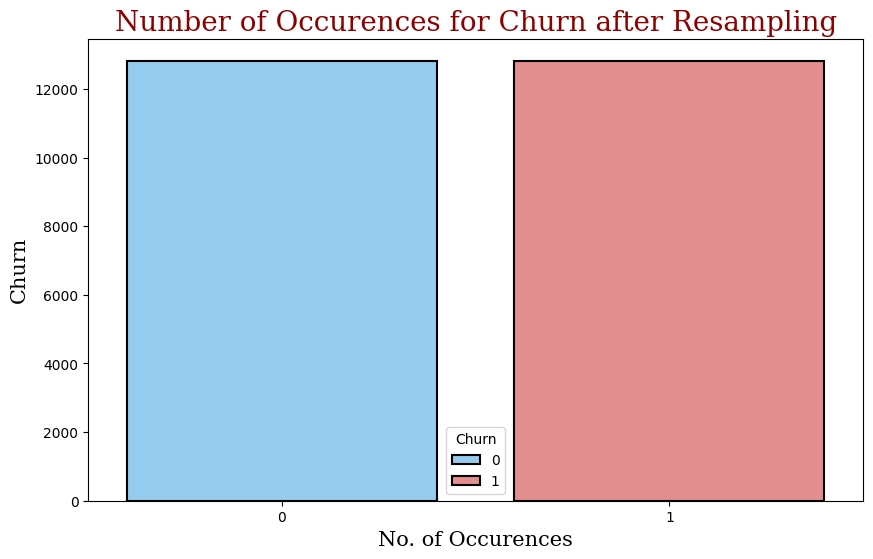

In [139]:
churn_counts = y_train.value_counts()
plt.figure(figsize=(10,6))
sns.barplot(x=churn_counts.index,y=churn_counts.values,hue=churn_counts.index,palette=colors,edgecolor='black',linewidth=1.5)
plt.xlabel('No. of Occurences',fontdict=font2)
plt.ylabel('Churn',fontdict=font2)
plt.title('Number of Occurences for Churn after Resampling',fontdict=font1)
plt.show()

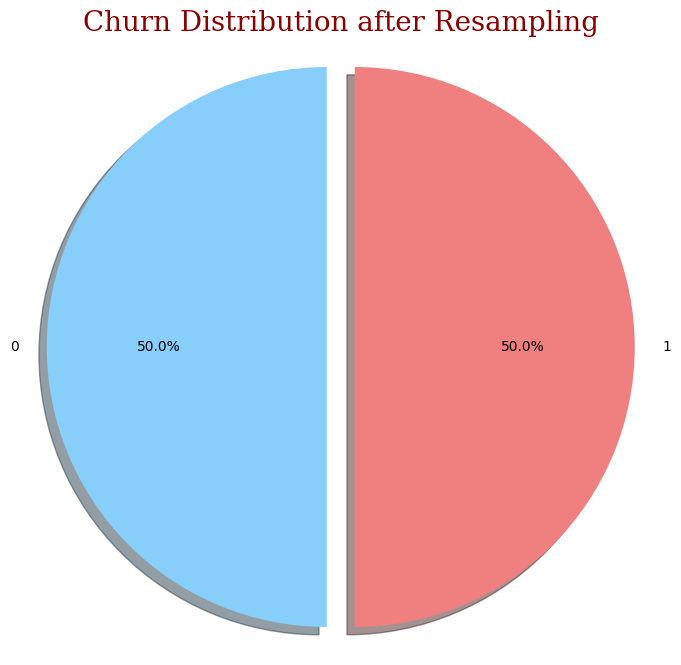

In [91]:
churn_counts = y_train.value_counts()
labels = churn_counts.index
sizes = churn_counts.values
colors = ['lightskyblue','lightcoral']
explode = (0.1, 0) 

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90,
        explode=explode, shadow=True)
plt.title('Churn Distribution after Resampling',fontdict=font1)

plt.axis('equal')  

plt.show()

In [92]:
X_test_transform = preprocessor.transform(X_test)

ValueError: Found unknown categories [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0] in column 0 during transform

In [68]:
X_test_transform

array([[2., 2., 7., ..., 0., 0., 0.],
       [5., 1., 7., ..., 0., 0., 0.],
       [6., 2., 6., ..., 0., 0., 0.],
       ...,
       [6., 3., 7., ..., 0., 0., 0.],
       [5., 2., 7., ..., 0., 0., 0.],
       [4., 3., 7., ..., 0., 0., 0.]])

## XGBoost (XGB)

In [140]:
xgb_model = XGBClassifier()

In [141]:
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [84]:
with open('XGB-All.pkl','wb') as f:
    pickle.dump(xgb_model,f)

In [80]:
y_train.value_counts()

Churn
0    12820
1    12820
Name: count, dtype: int64

In [142]:
y_pred = xgb_model.predict(X_test)

In [143]:
from sklearn.metrics import precision_score

              precision    recall  f1-score   support

           0       0.81      0.63      0.71      3551
           1       0.41      0.64      0.50      1425

    accuracy                           0.63      4976
   macro avg       0.61      0.63      0.60      4976
weighted avg       0.70      0.63      0.65      4976



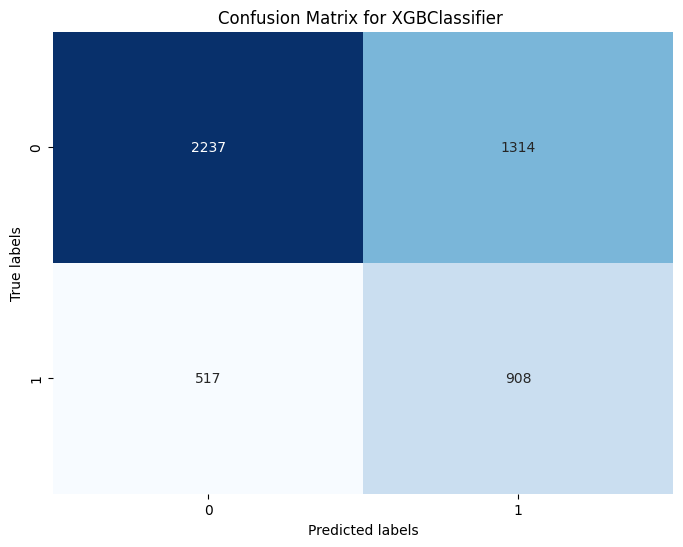

ROC AUC Score: 0.68


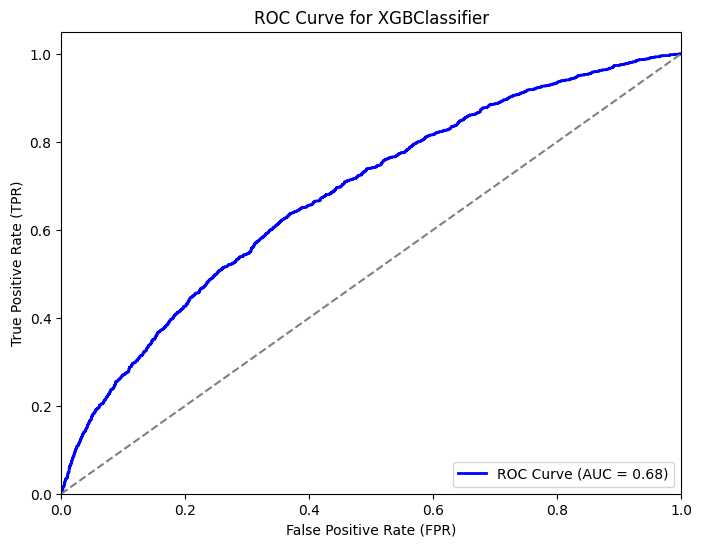

In [144]:
evaluate_model(xgb_model,X_test,y_test)

## Support Vector Classifier (SVC)

In [72]:
svc_model = SVC(probability=False)

In [73]:
svc_model.fit(X_train,y_train)

SVC()

In [74]:
y_pred = svc_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.78      0.57      0.66      3551
           1       0.36      0.60      0.45      1425

    accuracy                           0.58      4976
   macro avg       0.57      0.58      0.55      4976
weighted avg       0.66      0.58      0.60      4976



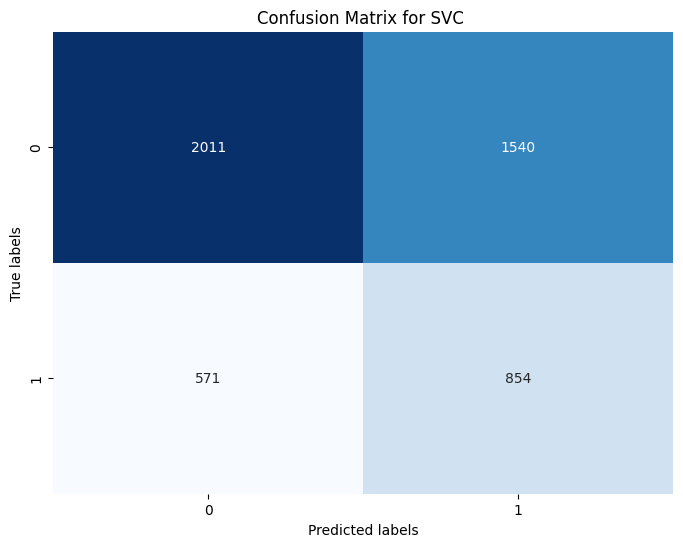

AttributeError: This 'SVC' has no attribute 'predict_proba'

In [75]:
evaluate_model(svc_model,X_test,y_test)

## Logistic Regression (LR)

In [76]:
lr_model = LogisticRegression(max_iter=5000)
lr_model.fit(X_train,y_train)

c:\Users\maab9\anaconda3\envs\churn\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=5000)

              precision    recall  f1-score   support

           0       0.78      0.60      0.68      3551
           1       0.36      0.57      0.44      1425

    accuracy                           0.59      4976
   macro avg       0.57      0.58      0.56      4976
weighted avg       0.66      0.59      0.61      4976



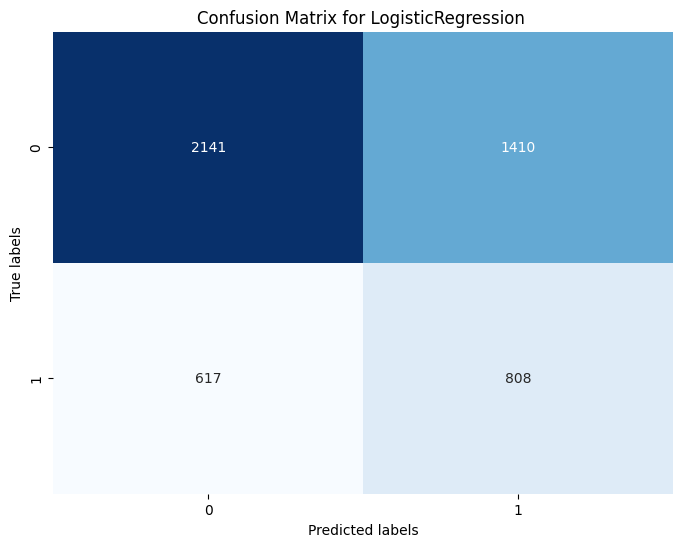

ROC AUC Score: 0.62


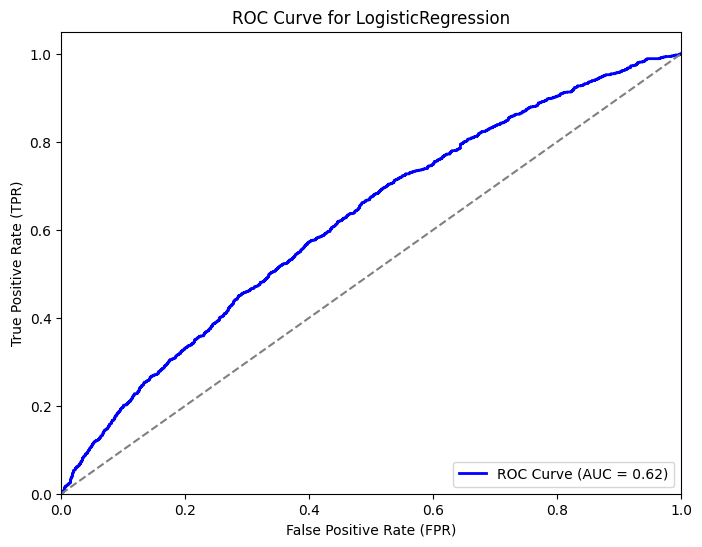

In [77]:
evaluate_model(lr_model,X_test,y_test)

### Neural Network (ANN/MLP)

In [148]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[xgb_top_features])
X_test_scaled = scaler.transform(X_test[xgb_top_features])

In [138]:
X_test_scaled,X_val,y_test_scaled,y_val = train_test_split(X_test_scaled,y_test,test_size=0.5)

In [139]:
nn_model = Sequential([
    
    Dense(60, activation='relu', name='L1', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.1),
    Dense(30, activation='relu', name='L2', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.1),
    Dense(15, activation='relu', name='L3', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.1),
    Dense(2, activation='linear', name='L4')
])

nn_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=['accuracy']
)

history = nn_model.fit(
    X_train_scaled, y_train,
    epochs=100, validation_data=(X_val,y_val))

Epoch 1/100


802/802 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5078 - loss: 1.4433 - val_accuracy: 0.5434 - val_loss: 1.2168
Epoch 2/100
802/802 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5497 - loss: 1.1690 - val_accuracy: 0.5257 - val_loss: 1.0382
Epoch 3/100
802/802 ━━━━━━━━━━━━━━━━━━━━ 1s 987us/step - accuracy: 0.5572 - loss: 0.9989 - val_accuracy: 0.5430 - val_loss: 0.9096
Epoch 4/100
802/802 ━━━━━━━━━━━━━━━━━━━━ 1s 938us/step - accuracy: 0.5658 - loss: 0.8841 - val_accuracy: 0.5671 - val_loss: 0.8197
Epoch 5/100
802/802 ━━━━━━━━━━━━━━━━━━━━ 1s 967us/step - accuracy: 0.5713 - loss: 0.8080 - val_accuracy: 0.5824 - val_loss: 0.7634
Epoch 6/100
802/802 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5682 - loss: 0.7585 - val_accuracy: 0.5752 - val_loss: 0.7333
Epoch 7/100
802/802 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5681 - loss: 0.7310 - val_accuracy: 0.5864 - val_loss: 0.7106
Epoch 8/100
802/802 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5682 - loss: 0.7131 - val_accuracy: 

In [149]:
y_pred = nn_model.predict(X_test_scaled)
predictions=tf.nn.softmax(y_pred).numpy()
preds = np.argmax(predictions,axis=1)

 81/156 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step


In [151]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.77      0.57      0.66      3551
           1       0.35      0.57      0.43      1425

    accuracy                           0.57      4976
   macro avg       0.56      0.57      0.54      4976
weighted avg       0.65      0.57      0.59      4976



123/156 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
ROC AUC Score: 0.57


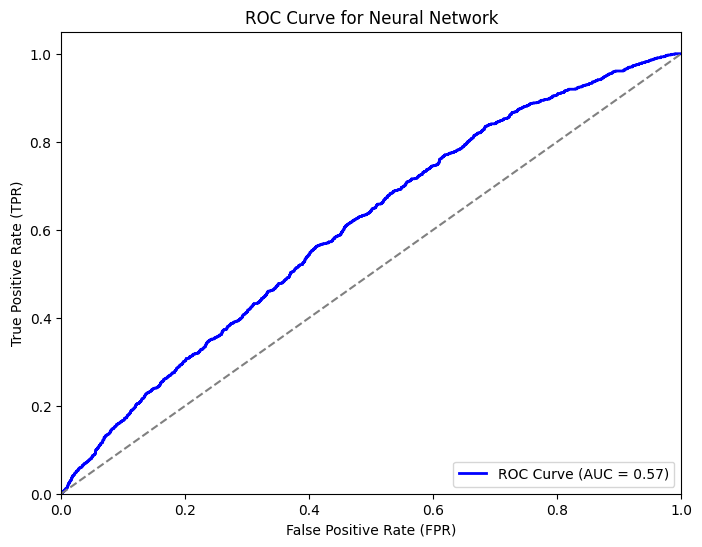

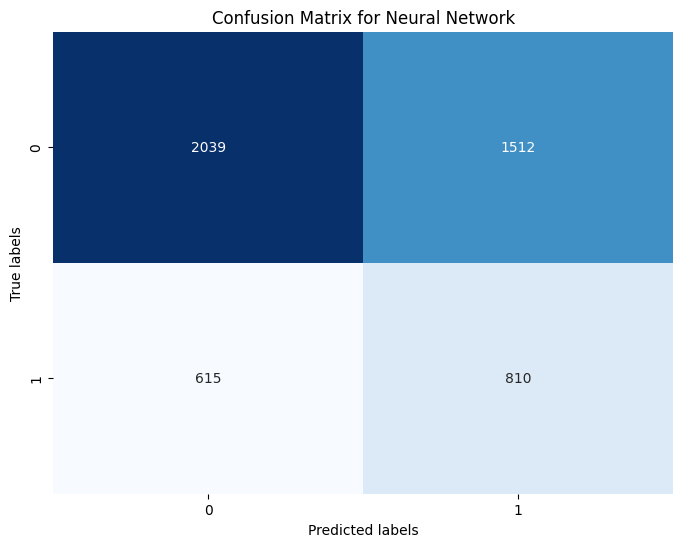

In [153]:
y_pred = nn_model.predict(X_test_scaled)
y_pred = tf.nn.softmax(y_pred).numpy()

fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, 1])


roc_auc = roc_auc_score(y_test, preds)
print(f"ROC AUC Score: {roc_auc:.2f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(f'ROC Curve for Neural Network')
plt.legend(loc="lower right")
plt.show()

y_pred = np.argmax(y_pred,axis=1)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix for Neural Network')
plt.show()


## K Nearest Neighbors (KNN)

In [84]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()

In [85]:
knn_model.fit(X_train,y_train)

KNeighborsClassifier()

              precision    recall  f1-score   support

           0       0.75      0.58      0.66      3551
           1       0.34      0.52      0.41      1425

    accuracy                           0.57      4976
   macro avg       0.54      0.55      0.53      4976
weighted avg       0.63      0.57      0.59      4976



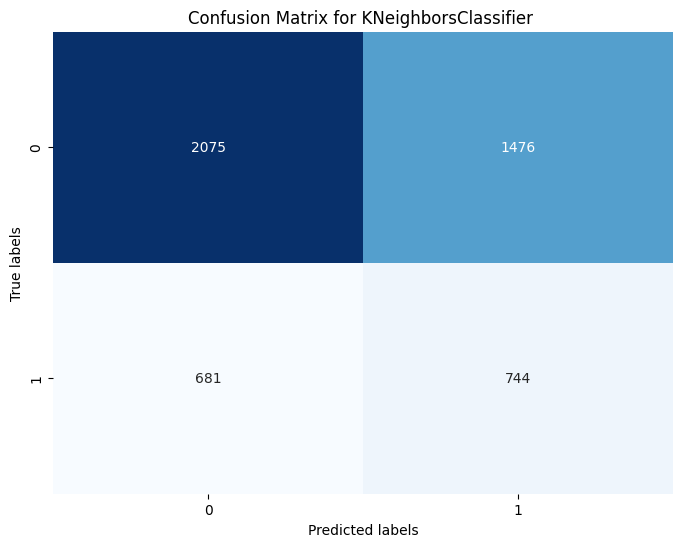

ROC AUC Score: 0.57


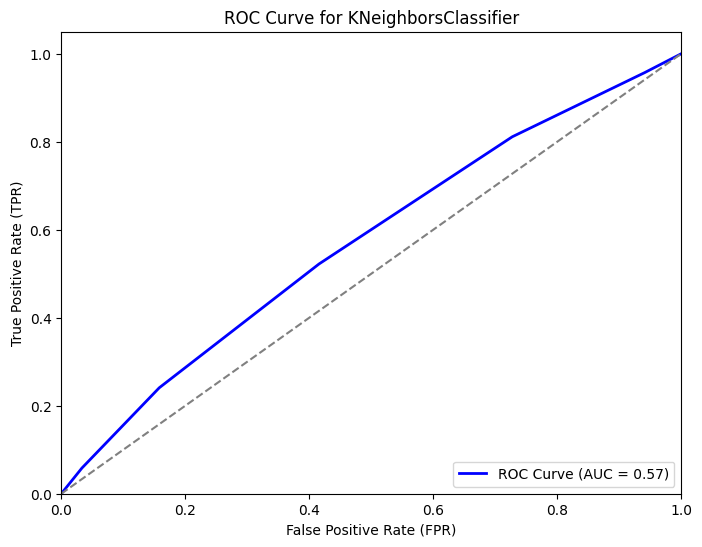

In [86]:
evaluate_model(knn_model,X_test,y_test)

## Random Forest (RF)

              precision    recall  f1-score   support

           0       0.80      0.62      0.70      3551
           1       0.39      0.60      0.47      1425

    accuracy                           0.62      4976
   macro avg       0.59      0.61      0.59      4976
weighted avg       0.68      0.62      0.63      4976



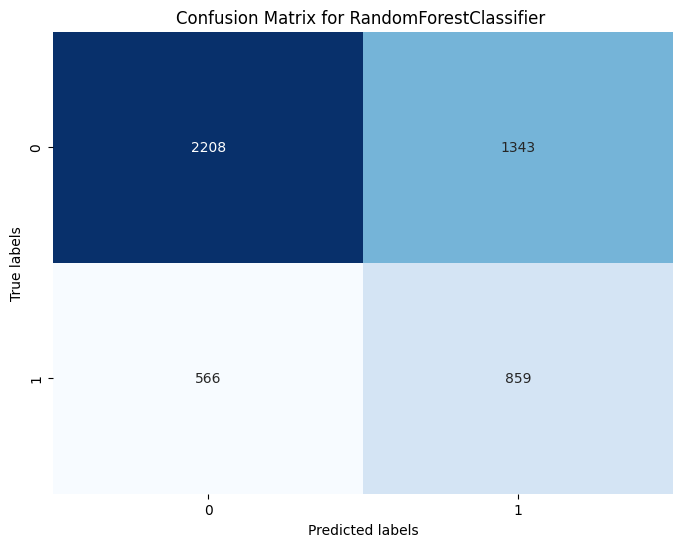

ROC AUC Score: 0.66


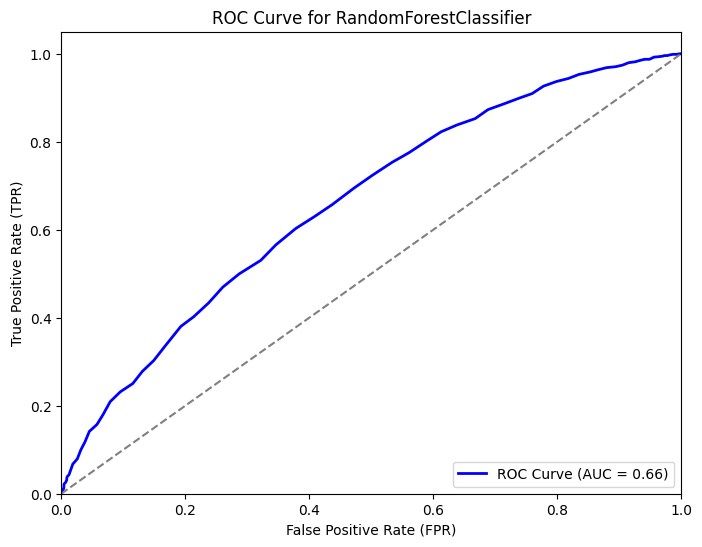

In [87]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train,y_train)
evaluate_model(rf_model,X_test,y_test)


## Resampling using SMOTE

In [47]:
smote = SMOTE(random_state=1)
X_train_smote , y_train_smote = smote.fit_resample(X_train,y_train)

In [50]:
xgb_model.fit(X_train_smote,y_train_smote)
rf_model.fit(X_train_smote,y_train_smote)
knn_model.fit(X_train_smote,y_train_smote)
lr_model.fit(X_train_smote,y_train_smote)

c:\Users\maab9\anaconda3\envs\churn\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=5000)

              precision    recall  f1-score   support

           0       0.74      0.93      0.83      3551
           1       0.53      0.19      0.28      1425

    accuracy                           0.72      4976
   macro avg       0.63      0.56      0.55      4976
weighted avg       0.68      0.72      0.67      4976



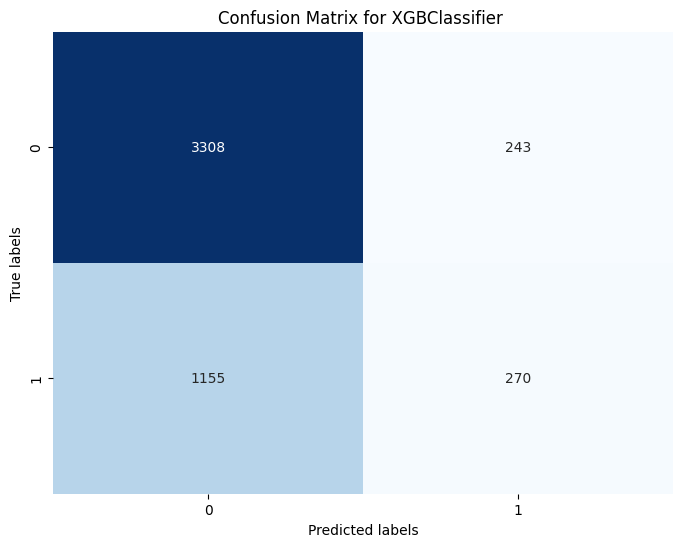

ROC AUC Score: 0.68


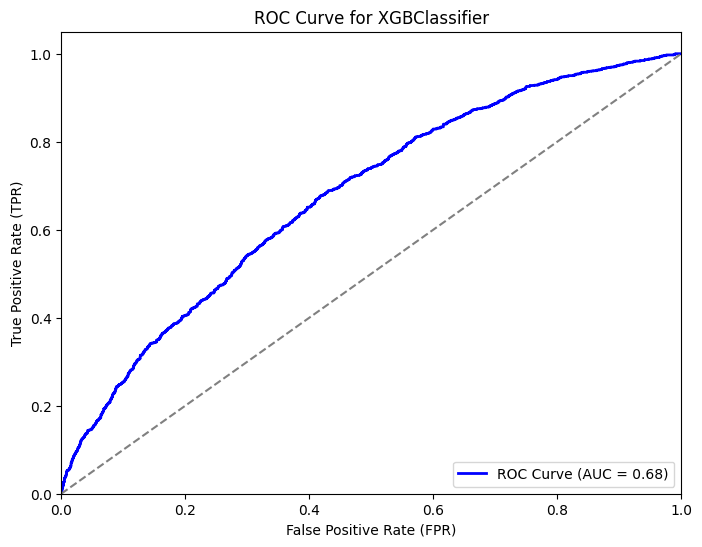

              precision    recall  f1-score   support

           0       0.73      0.96      0.83      3551
           1       0.51      0.09      0.16      1425

    accuracy                           0.72      4976
   macro avg       0.62      0.53      0.49      4976
weighted avg       0.67      0.72      0.64      4976



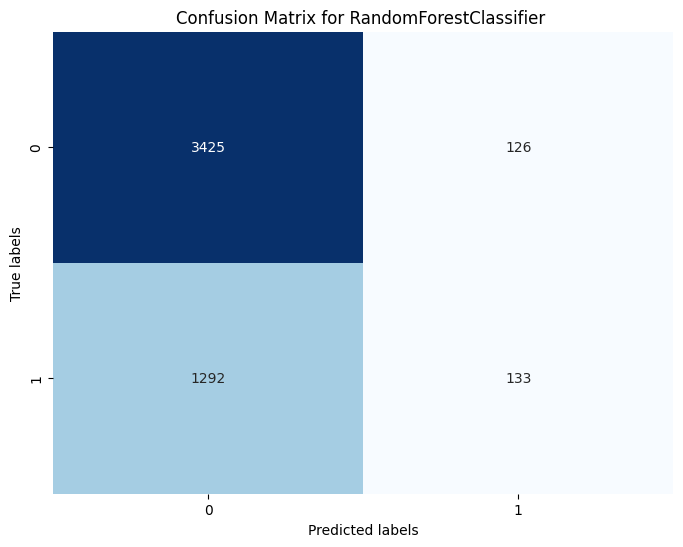

ROC AUC Score: 0.66


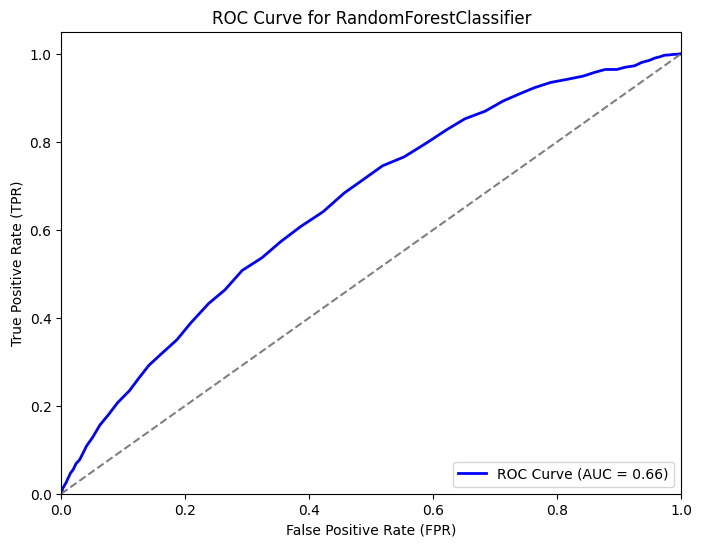

              precision    recall  f1-score   support

           0       0.75      0.57      0.65      3551
           1       0.33      0.53      0.41      1425

    accuracy                           0.56      4976
   macro avg       0.54      0.55      0.53      4976
weighted avg       0.63      0.56      0.58      4976



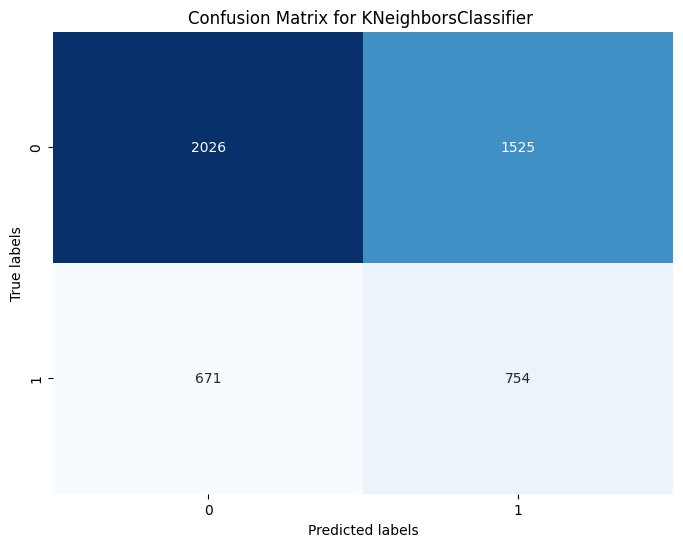

ROC AUC Score: 0.56


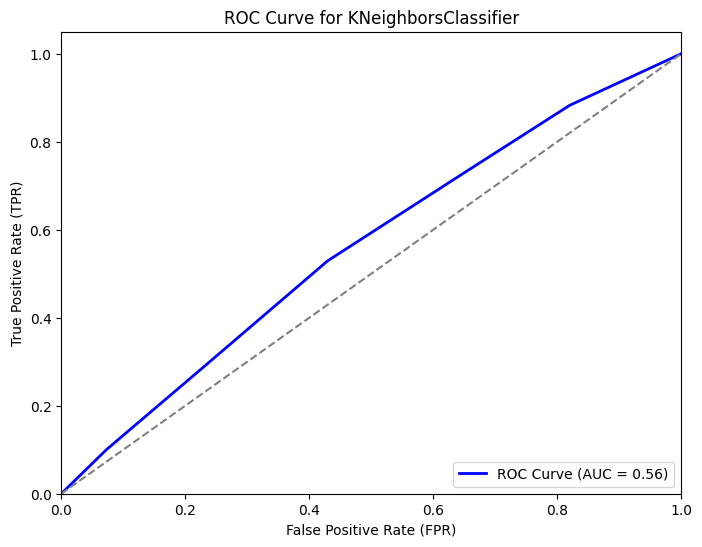

              precision    recall  f1-score   support

           0       0.77      0.59      0.67      3551
           1       0.35      0.56      0.44      1425

    accuracy                           0.58      4976
   macro avg       0.56      0.58      0.55      4976
weighted avg       0.65      0.58      0.60      4976



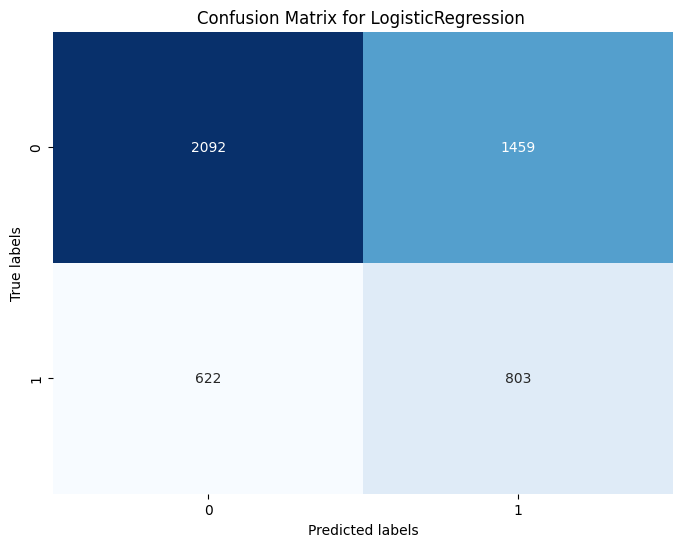

ROC AUC Score: 0.62


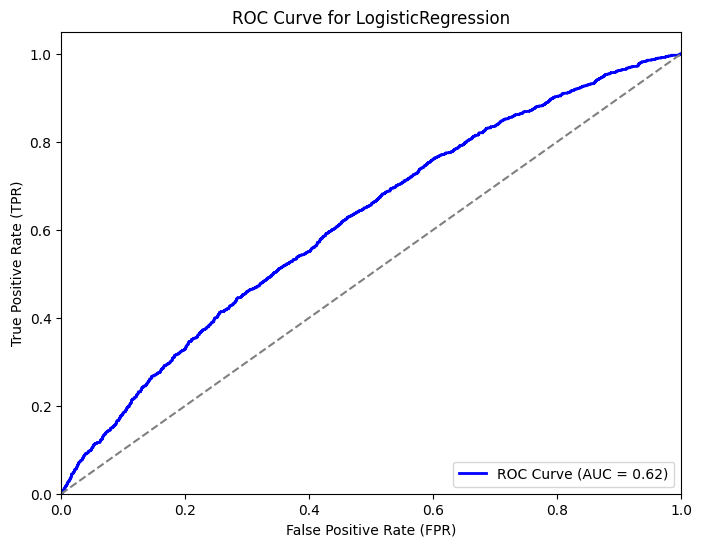

In [51]:
evaluate_model(xgb_model,X_test,y_test)
evaluate_model(rf_model,X_test,y_test)
evaluate_model(knn_model,X_test,y_test)
evaluate_model(lr_model,X_test,y_test)

#### As we can observe, often times the Recall for the positive class is often very low for resampling with SMOTE. i.e. the models are not actually good at predicting if a patient is about to churn

### Overall, the XGBoost Model Performs the best, with highest AUC and higher accuracy and recall scores

## Feature Selection 

### Using Best Model , XGB

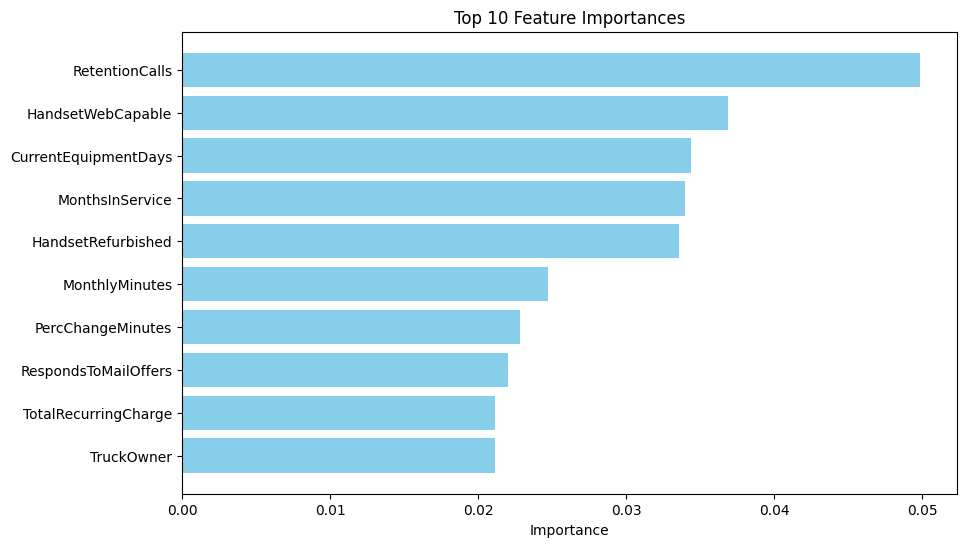

In [88]:
importances = xgb_model.feature_importances_


feature_names = xgb_model.get_booster().feature_names


feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})


feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

top_10_features = feature_importance_df.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [89]:
xgb_top_features = np.array(top_10_features['Feature'])

In [92]:
xgb_model.fit(X_train[xgb_top_features],y_train)
rf_model.fit(X_train[xgb_top_features],y_train)
knn_model.fit(X_train[xgb_top_features],y_train)
lr_model.fit(X_train[xgb_top_features],y_train)

LogisticRegression(max_iter=5000)

              precision    recall  f1-score   support

           0       0.79      0.60      0.68      3551
           1       0.38      0.60      0.46      1425

    accuracy                           0.60      4976
   macro avg       0.58      0.60      0.57      4976
weighted avg       0.67      0.60      0.62      4976



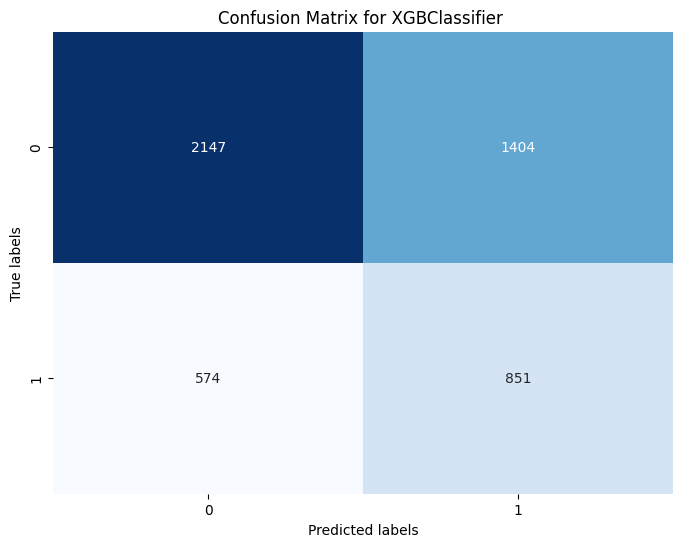

ROC AUC Score: 0.65


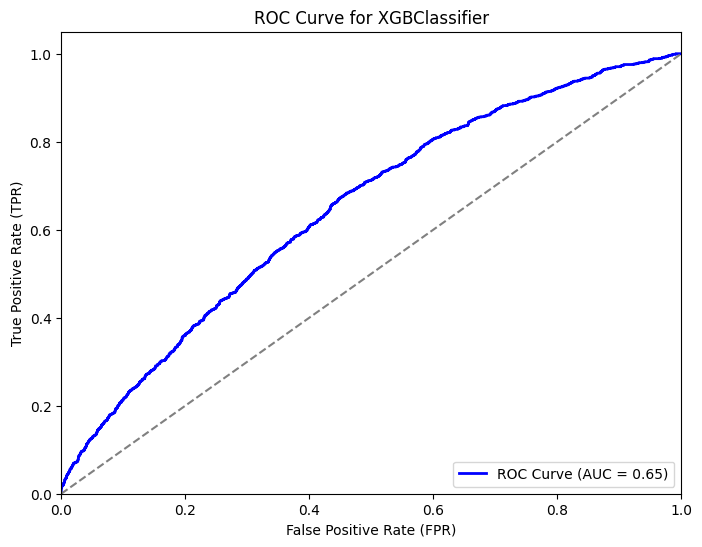

              precision    recall  f1-score   support

           0       0.78      0.61      0.68      3551
           1       0.37      0.57      0.45      1425

    accuracy                           0.60      4976
   macro avg       0.57      0.59      0.56      4976
weighted avg       0.66      0.60      0.61      4976



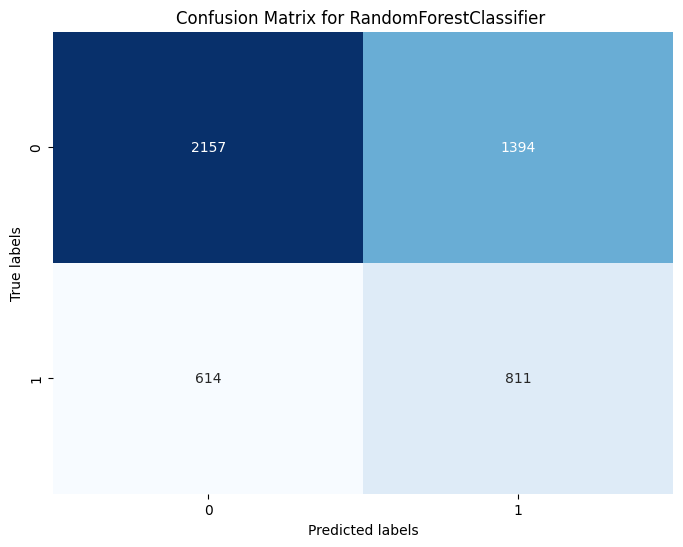

ROC AUC Score: 0.64


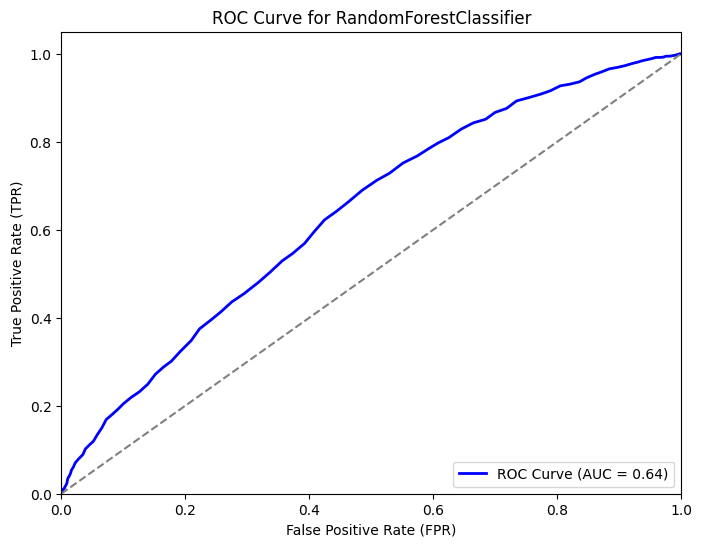

              precision    recall  f1-score   support

           0       0.76      0.56      0.65      3551
           1       0.34      0.55      0.42      1425

    accuracy                           0.56      4976
   macro avg       0.55      0.56      0.53      4976
weighted avg       0.64      0.56      0.58      4976



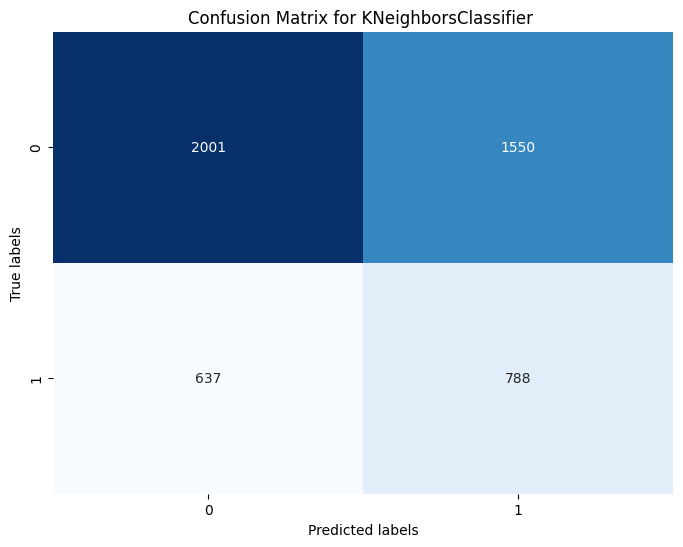

ROC AUC Score: 0.57


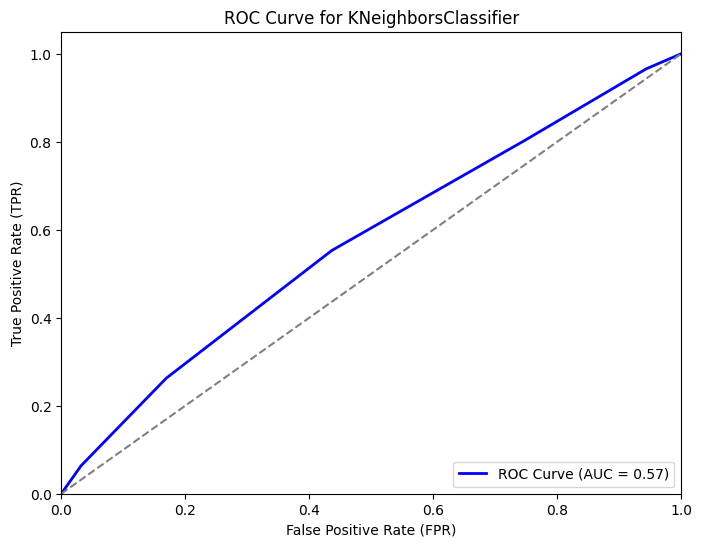

              precision    recall  f1-score   support

           0       0.76      0.59      0.66      3551
           1       0.34      0.53      0.42      1425

    accuracy                           0.57      4976
   macro avg       0.55      0.56      0.54      4976
weighted avg       0.64      0.57      0.59      4976



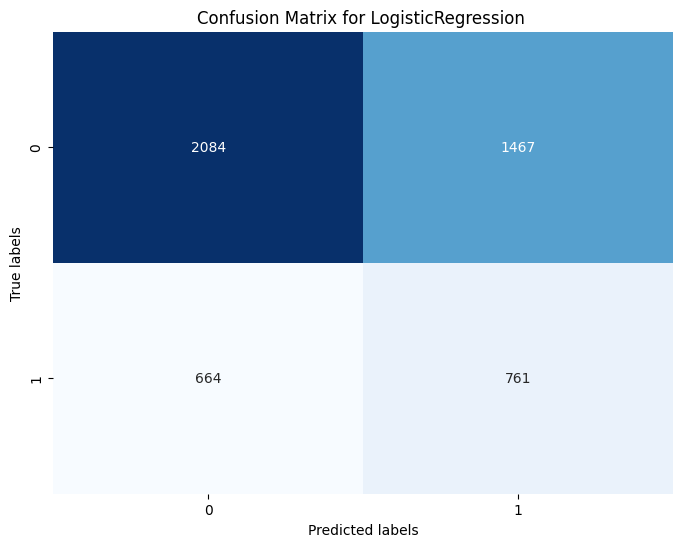

ROC AUC Score: 0.59


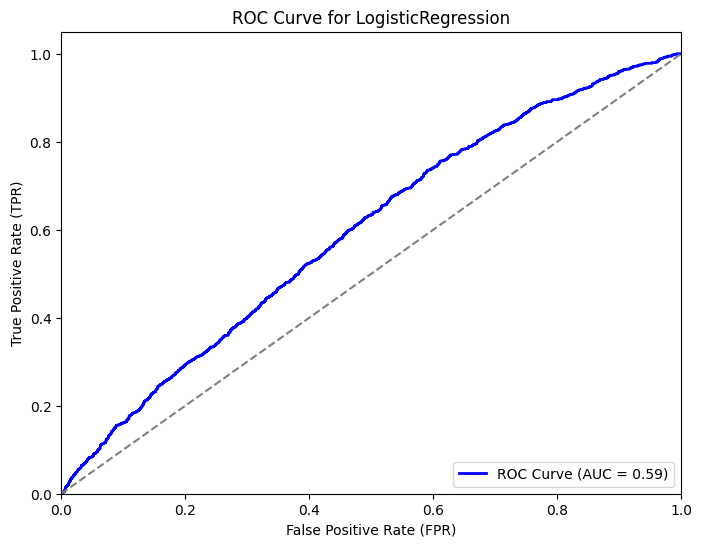

In [93]:
evaluate_model(xgb_model,X_test[xgb_top_features],y_test)
evaluate_model(rf_model,X_test[xgb_top_features],y_test)
evaluate_model(knn_model,X_test[xgb_top_features],y_test)
evaluate_model(lr_model,X_test[xgb_top_features],y_test)

### Mutual Information Gain 

In [94]:
MI=mutual_info_classif(X_train,y_train)
ranked_features=pd.Series(MI,index=X.columns)
mi_ranked_features = ranked_features.nlargest(10).index
for rank, feature in enumerate(mi_ranked_features, start=1):
    print(f"Rank {rank}: {feature}")

Rank 1: MonthsInService
Rank 2: CurrentEquipmentDays
Rank 3: CallForwardingCalls
Rank 4: HandsetWebCapable
Rank 5: BuysViaMailOrder
Rank 6: CreditRating
Rank 7: RVOwner
Rank 8: AgeHH1
Rank 9: PeakCallsInOut
Rank 10: TotalRecurringCharge


In [97]:
xgb_model.fit(X_train[mi_ranked_features],y_train)
rf_model.fit(X_train[mi_ranked_features],y_train)
knn_model.fit(X_train[mi_ranked_features],y_train)
lr_model.fit(X_train[mi_ranked_features],y_train)

LogisticRegression(max_iter=5000)

              precision    recall  f1-score   support

           0       0.79      0.56      0.66      3551
           1       0.36      0.62      0.46      1425

    accuracy                           0.58      4976
   macro avg       0.57      0.59      0.56      4976
weighted avg       0.67      0.58      0.60      4976



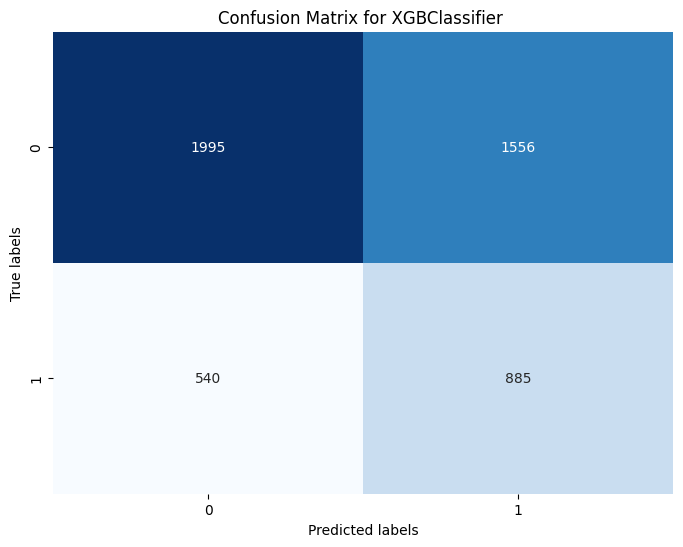

ROC AUC Score: 0.63


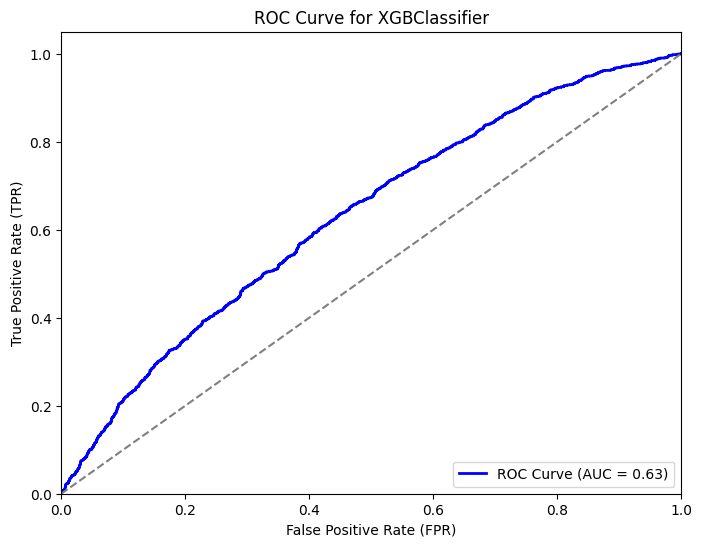

              precision    recall  f1-score   support

           0       0.77      0.60      0.68      3551
           1       0.36      0.55      0.43      1425

    accuracy                           0.59      4976
   macro avg       0.56      0.58      0.56      4976
weighted avg       0.65      0.59      0.61      4976



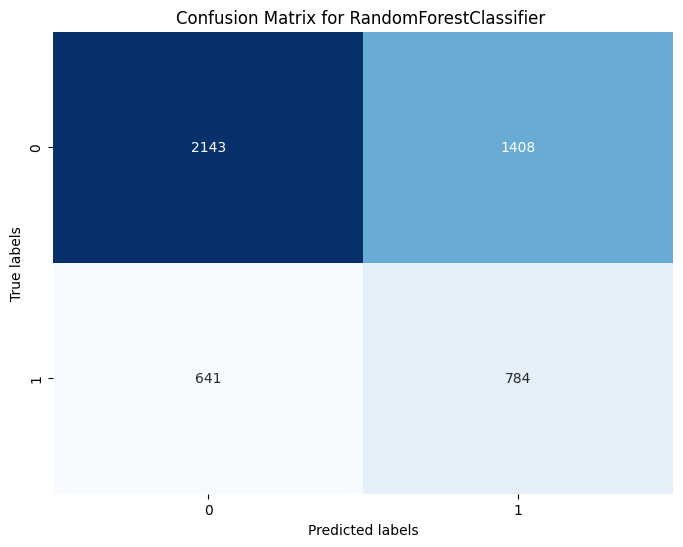

ROC AUC Score: 0.61


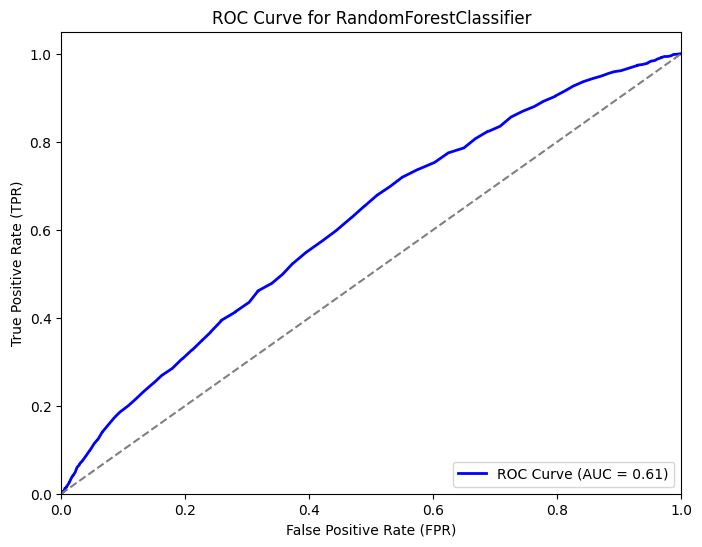

              precision    recall  f1-score   support

           0       0.75      0.54      0.63      3551
           1       0.33      0.55      0.41      1425

    accuracy                           0.55      4976
   macro avg       0.54      0.55      0.52      4976
weighted avg       0.63      0.55      0.57      4976



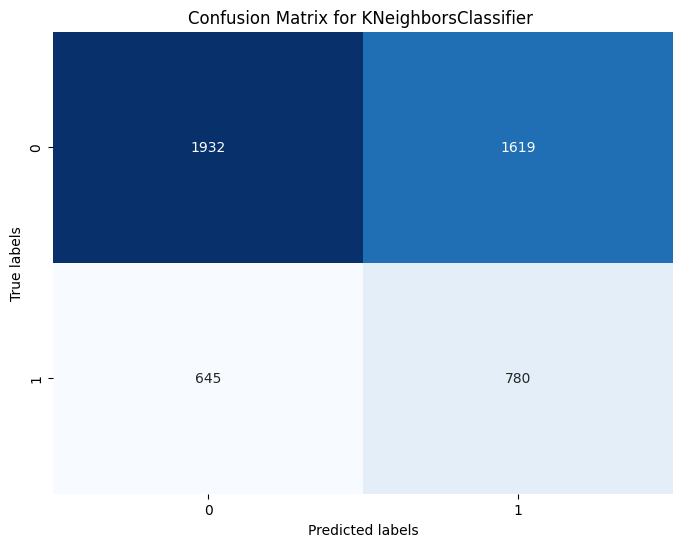

ROC AUC Score: 0.56


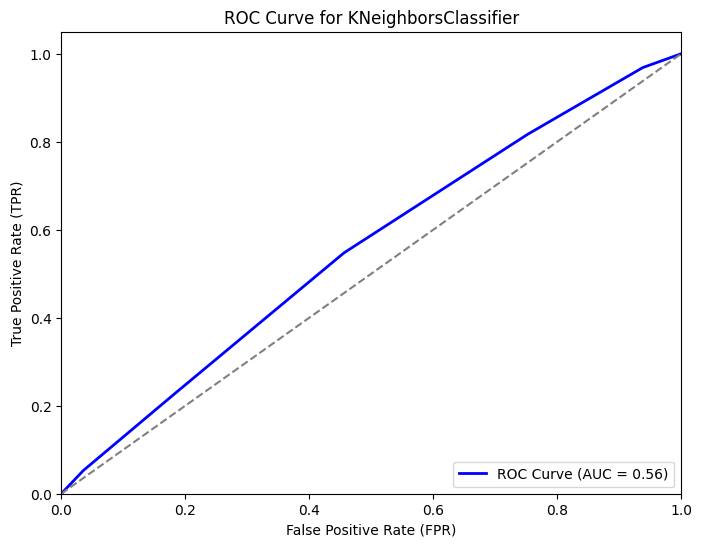

              precision    recall  f1-score   support

           0       0.76      0.58      0.66      3551
           1       0.34      0.55      0.42      1425

    accuracy                           0.57      4976
   macro avg       0.55      0.56      0.54      4976
weighted avg       0.64      0.57      0.59      4976



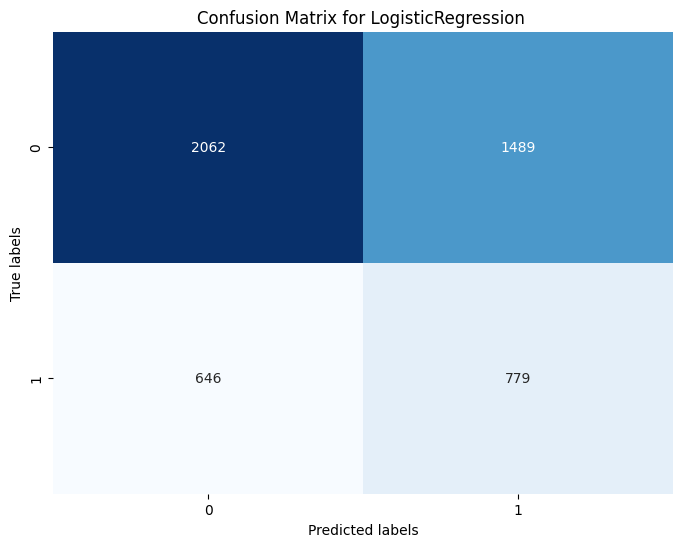

ROC AUC Score: 0.59


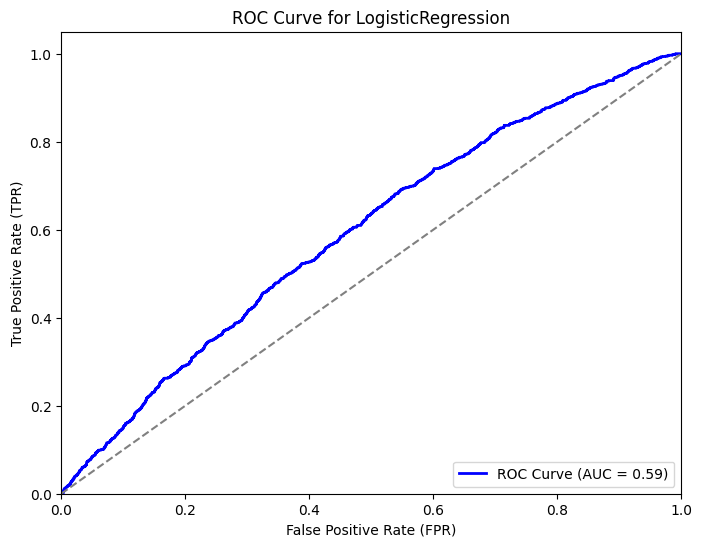

In [98]:
evaluate_model(xgb_model,X_test[mi_ranked_features],y_test)
evaluate_model(rf_model,X_test[mi_ranked_features],y_test)
evaluate_model(knn_model,X_test[mi_ranked_features],y_test)
evaluate_model(lr_model,X_test[mi_ranked_features],y_test)


## RFE Feature Selection

In [99]:
logreg_model = LogisticRegression()
selector = RFE(estimator=logreg_model, n_features_to_select=10, step=1)
X_train_selected = selector.fit_transform(X_train, y_train)
selected_indices = selector.get_support(indices=True)
rfe_top_features = [X_train.columns[idx] for idx in selected_indices]
print("Selected features:", rfe_top_features)

c:\Users\maab9\anaconda3\envs\churn\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\maab9\anaconda3\envs\churn\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Selected features: ['UniqueSubs', 'HandsetModels', 'ChildrenInHH', 'HandsetRefurbished', 'HandsetWebCapable', 'RespondsToMailOffers', 'RetentionCalls', 'ReferralsMadeBySubscriber', 'AdjustmentsToCreditRating', 'MadeCallToRetentionTeam']


              precision    recall  f1-score   support

           0       0.74      0.65      0.69      3551
           1       0.33      0.42      0.37      1425

    accuracy                           0.58      4976
   macro avg       0.53      0.54      0.53      4976
weighted avg       0.62      0.58      0.60      4976



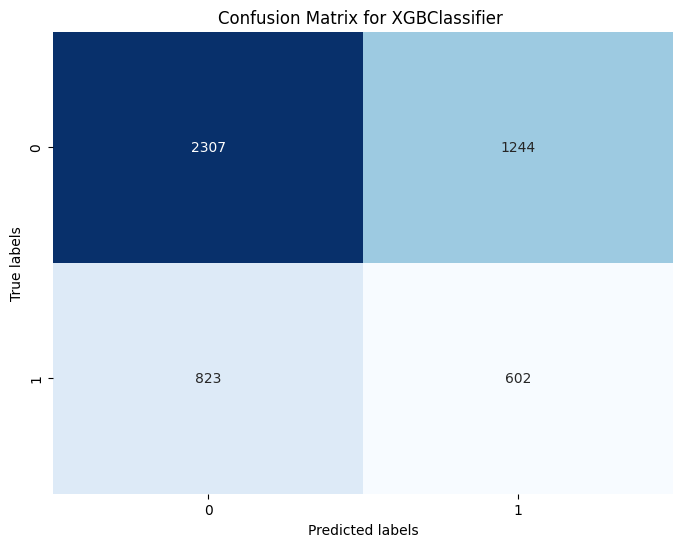

ROC AUC Score: 0.56


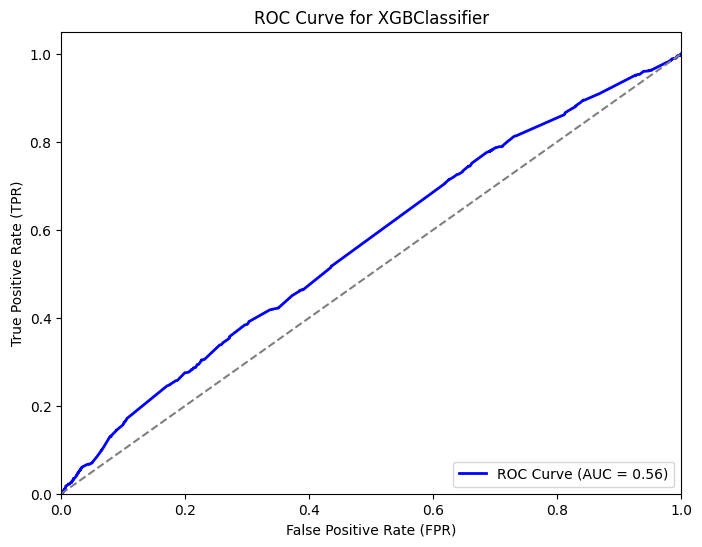

              precision    recall  f1-score   support

           0       0.73      0.61      0.67      3551
           1       0.32      0.45      0.37      1425

    accuracy                           0.57      4976
   macro avg       0.53      0.53      0.52      4976
weighted avg       0.62      0.57      0.58      4976



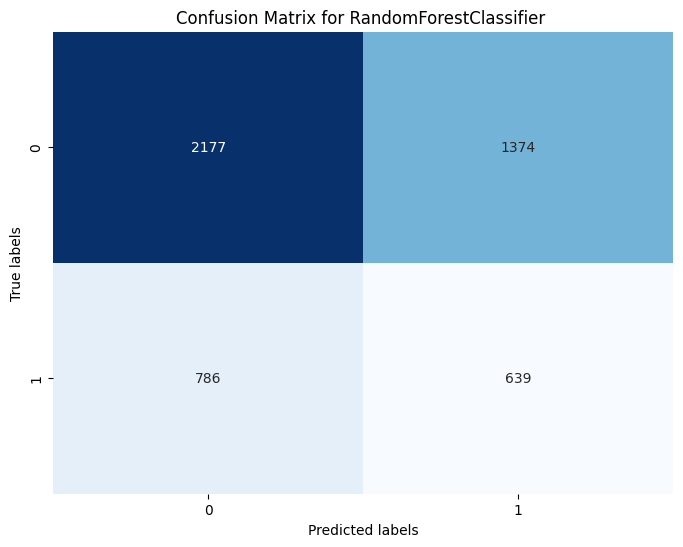

ROC AUC Score: 0.55


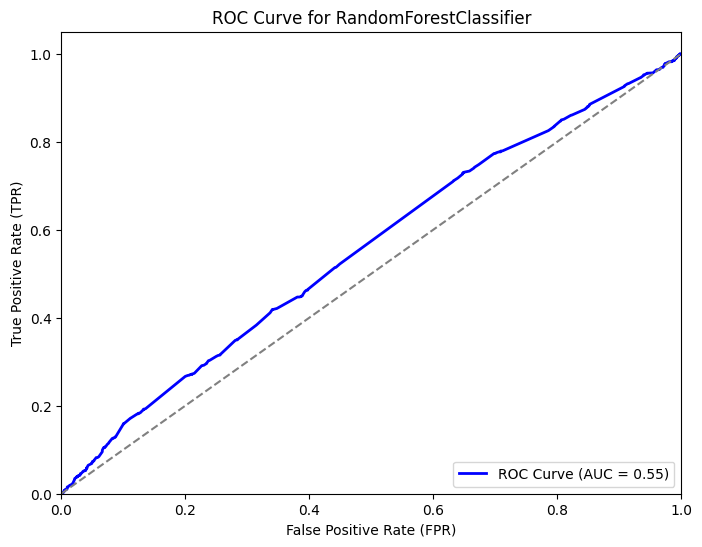

              precision    recall  f1-score   support

           0       0.72      0.98      0.83      3551
           1       0.37      0.03      0.05      1425

    accuracy                           0.71      4976
   macro avg       0.54      0.50      0.44      4976
weighted avg       0.62      0.71      0.60      4976



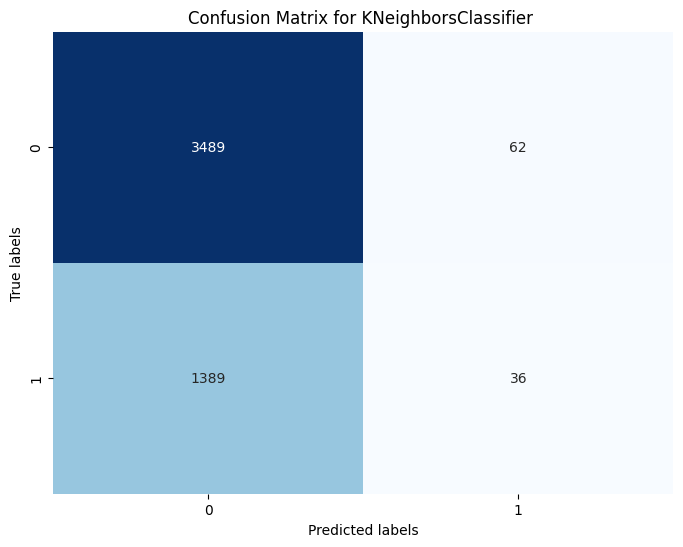

ROC AUC Score: 0.50


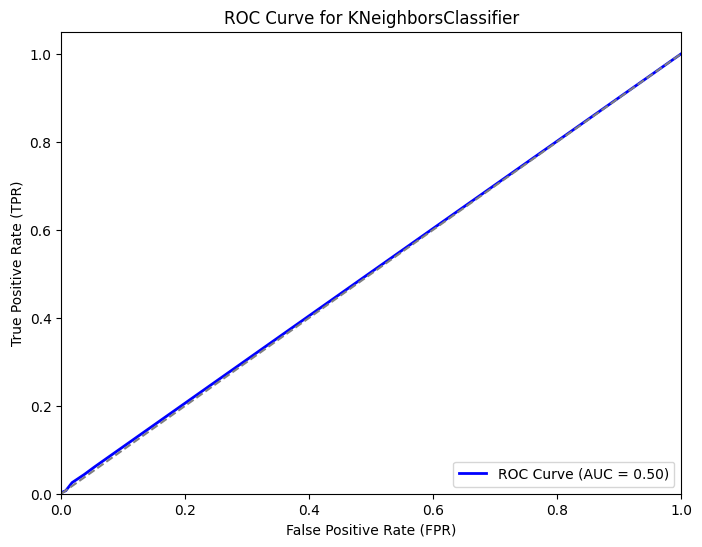

              precision    recall  f1-score   support

           0       0.74      0.69      0.71      3551
           1       0.34      0.41      0.37      1425

    accuracy                           0.61      4976
   macro avg       0.54      0.55      0.54      4976
weighted avg       0.63      0.61      0.62      4976



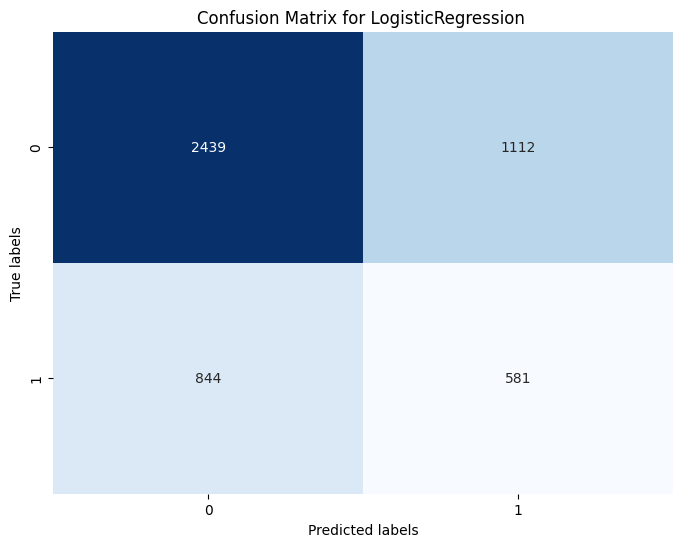

ROC AUC Score: 0.58


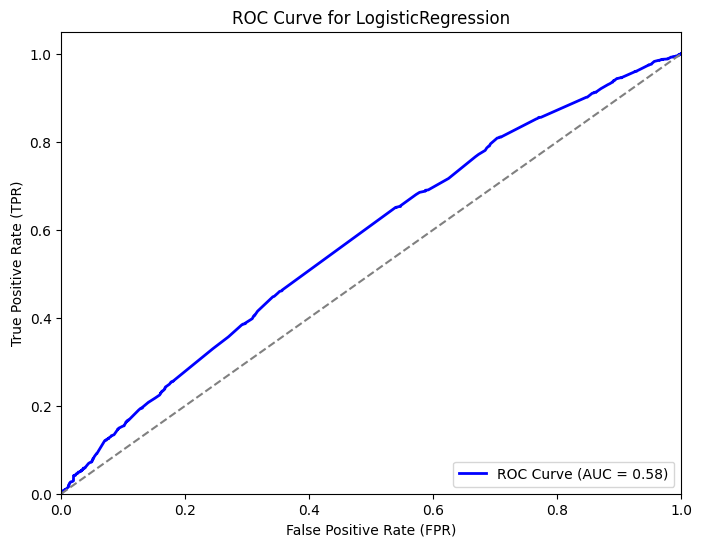

In [101]:
xgb_model.fit(X_train[rfe_top_features],y_train)
rf_model.fit(X_train[rfe_top_features],y_train)
knn_model.fit(X_train[rfe_top_features],y_train)
lr_model.fit(X_train[rfe_top_features],y_train)
evaluate_model(xgb_model,X_test[rfe_top_features],y_test)
evaluate_model(rf_model,X_test[rfe_top_features],y_test)
evaluate_model(knn_model,X_test[rfe_top_features],y_test)
evaluate_model(lr_model,X_test[rfe_top_features],y_test)

## Model Tuning & Cross Validation Testing

In [129]:
models = {
    'XGBoost': xgb_model,
    'RandomForest': rf_model,
    'LogisticRegression': lr_model,
    'KNN': knn_model
}

best_models = {}
for model_name, model_obj in models.items():
    print(f'Tuning {model_name} .....')
    param_grid = get_parameter_grid(model_name)
    best_model = get_best_model(model_obj, param_grid, X_train[xgb_top_features], y_train)
    best_models[model_name] = best_model
    print('Model tuning complete!')

Tuning XGBoost .....


Model tuning complete!
Tuning RandomForest .....
Model tuning complete!
Tuning LogisticRegression .....


c:\Users\maab9\anaconda3\envs\churn\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\maab9\anaconda3\envs\churn\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\maab9\anaconda3\envs\churn\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\maab9\anaconda3\envs\churn\lib\site-packages\sklearn\linear_model\_logistic.py", line 1172, in fit
    solver = _check_

Model tuning complete!
Tuning KNN .....
Model tuning complete!


In [133]:
svc_model = SVC(probability=True)

In [134]:
best_models['SVC'] = svc_model.fit(X_train[xgb_top_features],y_train)

In [131]:
best_models['NN'] = nn_model

In [110]:
X_train[xgb_top_features]

RetentionCalls  HandsetWebCapable  CurrentEquipmentDays  \
37288             0.0                1.0                 192.0   
7138              0.0                1.0                 822.0   
38349             0.0                1.0                 216.0   
22437             0.0                1.0                 125.0   
32609             0.0                1.0                 143.0   
...               ...                ...                   ...   
46138             0.0                1.0                 184.0   
168               0.0                1.0                 257.0   
5187              0.0                1.0                 150.0   
25012             0.0                1.0                 497.0   
33107             0.0                1.0                  94.0   

       MonthsInService  HandsetRefurbished  MonthlyMinutes  PercChangeMinutes  \
37288             14.0                 1.0          1424.0            -1424.0   
7138              27.0                 0.0           100.0               15.0   
38349              7.0                 0.0           202.0              -31.0   
22437             18.0                 0.0          1012.0                6.0   
32609              9.0                 0.0          1492.0               62.0   
...                ...                 ...             ...                ...   
46138              6.0                 0.0           384.0              -42.0   
168               50.0                 0.0           439.0              -17.0   
5187              30.0                 0.0           958.0             -170.0   
25012             17.0                 0.0           240.0               -8.0   
33107              9.0                 1.0           268.0              -42.0   

       RespondsToMailOffers  TotalRecurringCharge  TruckOwner  
37288                   0.0                  59.0         0.0  
7138                    0.0                  70.0         0.0  
38349                   1.0                  45.0         1.0  
22437                   0.0                  60.0         0.0  
32609                   0.0                  85.0         0.0  
...                     ...                   ...         ...  
46138                   0.0                  44.0         0.0  
168                     0.0                  30.0         1.0  
5187                    1.0                  85.0         1.0  
25012                   0.0                  30.0         0.0  
33107                   0.0                  40.0         0.0  

[25640 rows x 10 columns]

In [111]:
best_models['XGBoost'].predict(X_test[xgb_top_features])

array([0, 0, 1, ..., 1, 1, 1])

In [ ]:
for model in best_models.values():
    evaluate_model(model,X_test,y_test)

In [124]:
models_metrics = {}
for model_name,model in best_models.items():
    models_metrics[model_name] = {}
    
    if model_name == 'NN':
        predictions = model.predict(X_test_scaled)
        predictions=tf.nn.softmax(predictions).numpy()
        predictions = np.argmax(predictions,axis=1)
        acc = accuracy_score(y_test_scaled,predictions)
        rec = recall_score(y_test_scaled,predictions)
        f1 = f1_score(y_test_scaled,predictions)

    else :
        predictions = model.predict(X_test[rfe_top_features])
        acc = accuracy_score(y_test,predictions)
        rec = recall_score(y_test,predictions)
        f1 = f1_score(y_test,predictions)

    models_metrics[model_name]['Accuracy'] = acc
    models_metrics[model_name]['Recall'] = rec
    models_metrics[model_name]['F1'] = f1

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step


In [126]:
models_metrics

{'XGBoost': {'Accuracy': 0.6065112540192926,
  'Recall': 0.39649122807017545,
  'F1': 0.36593264248704666},
 'RandomForest': {'Accuracy': 0.6111334405144695,
  'Recall': 0.3873684210526316,
  'F1': 0.36327739387956565},
 'LogisticRegression': {'Accuracy': 0.6069131832797428,
  'Recall': 0.40771929824561404,
  'F1': 0.372674791533034},
 'KNN': {'Accuracy': 0.702572347266881,
  'Recall': 0.037894736842105266,
  'F1': 0.06801007556675064},
 'SVC': {'Accuracy': 0.6079180064308681,
  'Recall': 0.3887719298245614,
  'F1': 0.36220987250735537},
 'NN': {'Accuracy': 0.5908360128617364,
  'Recall': 0.5481586402266289,
  'F1': 0.43191964285714285}}

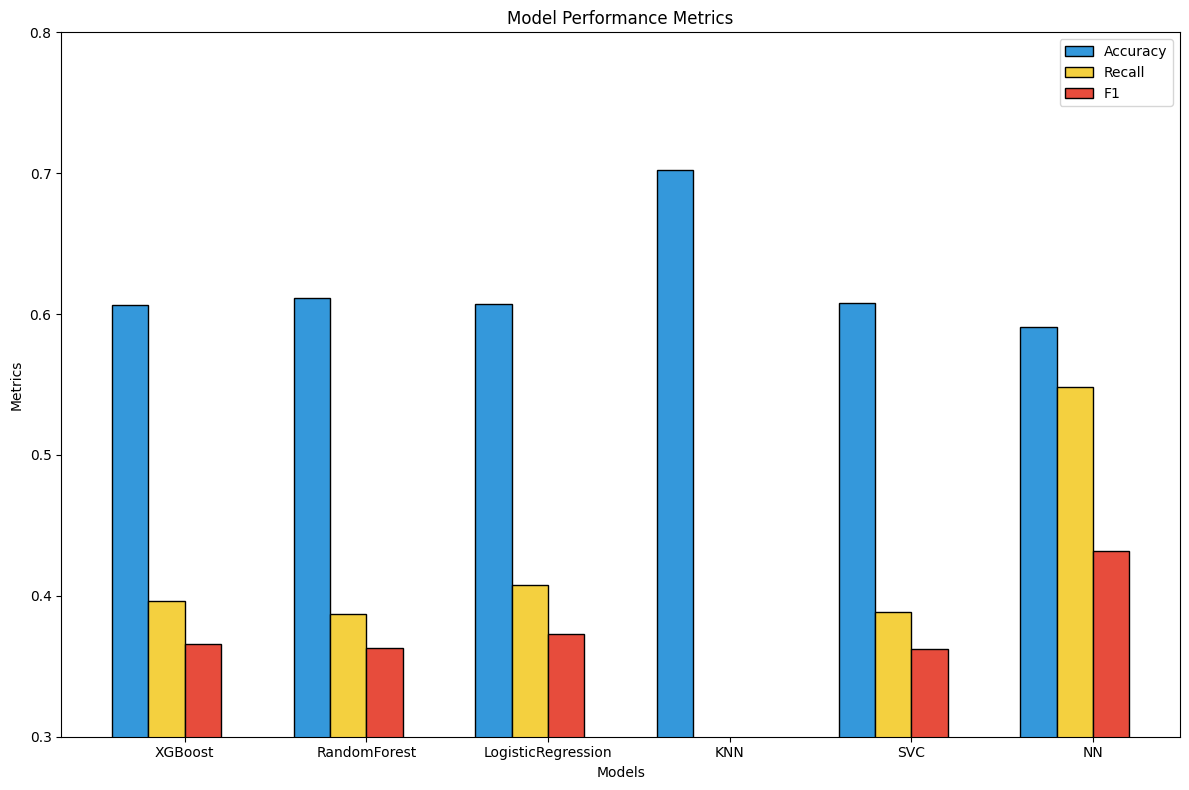

In [128]:
colors = {
    'Accuracy': '#3498DB',
    'Recall': '#F4D03F',
    'F1': '#E74C3C'
}


models = list(models_metrics.keys())
metrics = ['Accuracy', 'Recall', 'F1']
values = {metric: [models_metrics[model][metric] for model in models] for metric in metrics}

fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.2
index = range(len(models))

for i, metric in enumerate(metrics):
    ax.bar([p + i * bar_width for p in index], values[metric], width=bar_width, label=metric, edgecolor='black', color=colors[metric])

ax.set_xlabel('Models')
ax.set_ylabel('Metrics')
ax.set_title('Model Performance Metrics')
ax.set_xticks([p + 1.5 * bar_width for p in index])
ax.set_xticklabels(models)
ax.legend()

ax.set_ylim([0.3, 0.8])

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0       0.81      0.56      0.67      3551
           1       0.38      0.68      0.49      1425

    accuracy                           0.60      4976
   macro avg       0.60      0.62      0.58      4976
weighted avg       0.69      0.60      0.62      4976



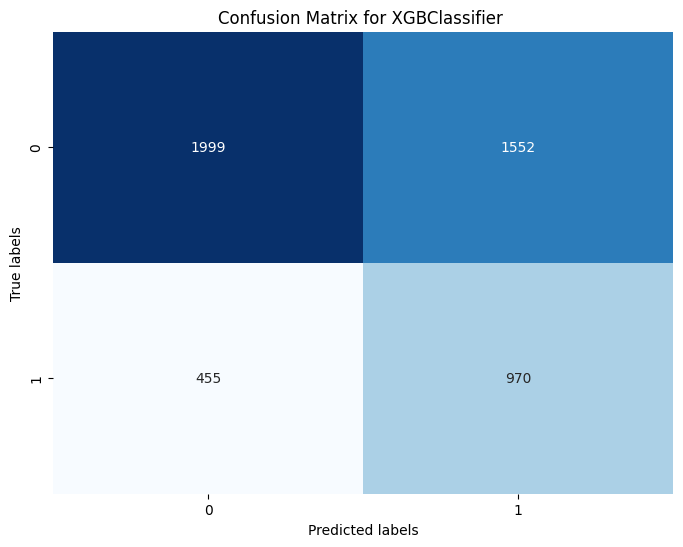

ROC AUC Score: 0.67


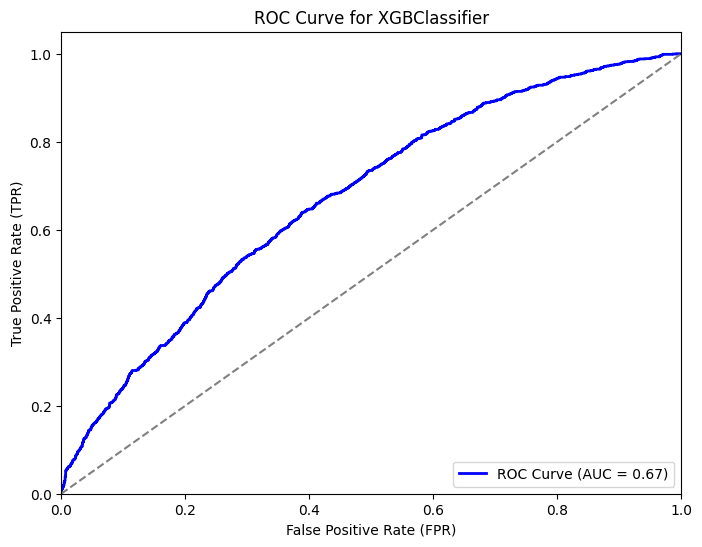

              precision    recall  f1-score   support

           0       0.81      0.55      0.65      3551
           1       0.38      0.68      0.49      1425

    accuracy                           0.59      4976
   macro avg       0.59      0.61      0.57      4976
weighted avg       0.69      0.59      0.60      4976



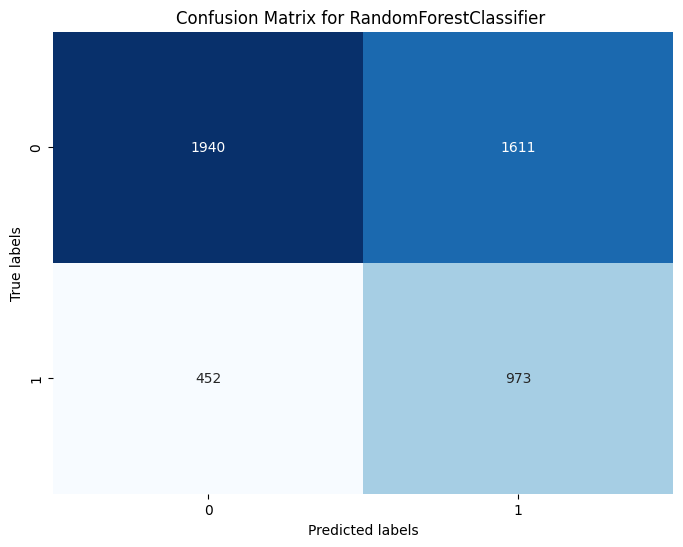

ROC AUC Score: 0.67


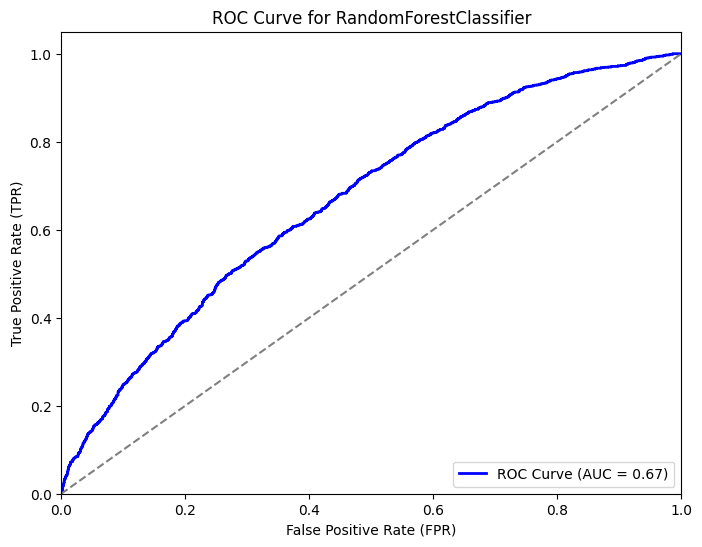

              precision    recall  f1-score   support

           0       0.76      0.59      0.66      3551
           1       0.34      0.53      0.42      1425

    accuracy                           0.57      4976
   macro avg       0.55      0.56      0.54      4976
weighted avg       0.64      0.57      0.59      4976



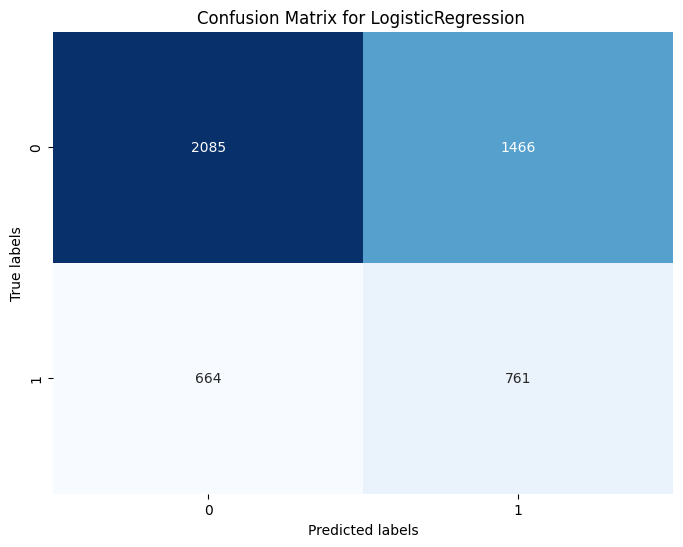

ROC AUC Score: 0.59


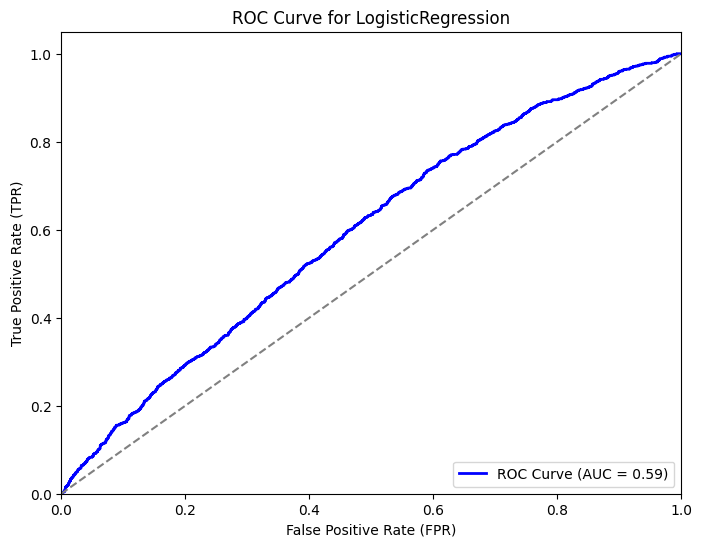

              precision    recall  f1-score   support

           0       0.77      0.57      0.66      3551
           1       0.35      0.57      0.43      1425

    accuracy                           0.57      4976
   macro avg       0.56      0.57      0.55      4976
weighted avg       0.65      0.57      0.59      4976



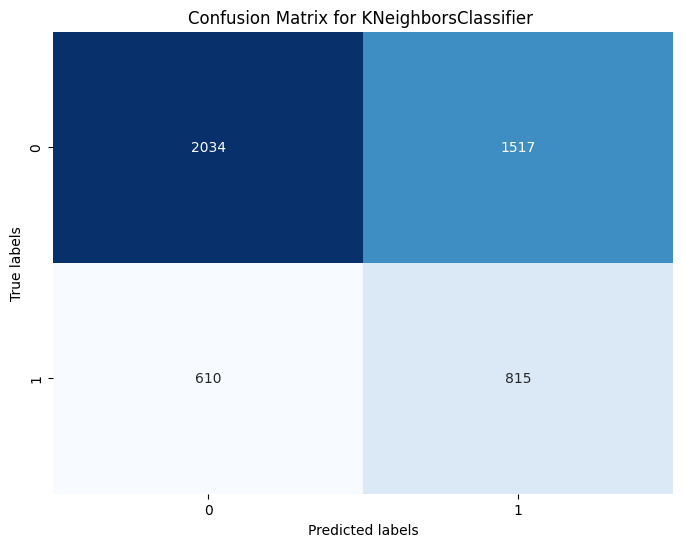

ROC AUC Score: 0.59


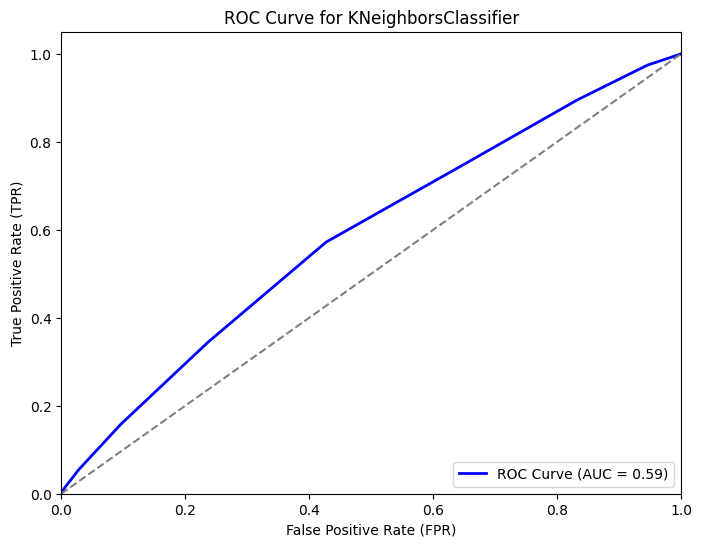

              precision    recall  f1-score   support

           0       0.77      0.57      0.65      3551
           1       0.35      0.57      0.43      1425

    accuracy                           0.57      4976
   macro avg       0.56      0.57      0.54      4976
weighted avg       0.65      0.57      0.59      4976



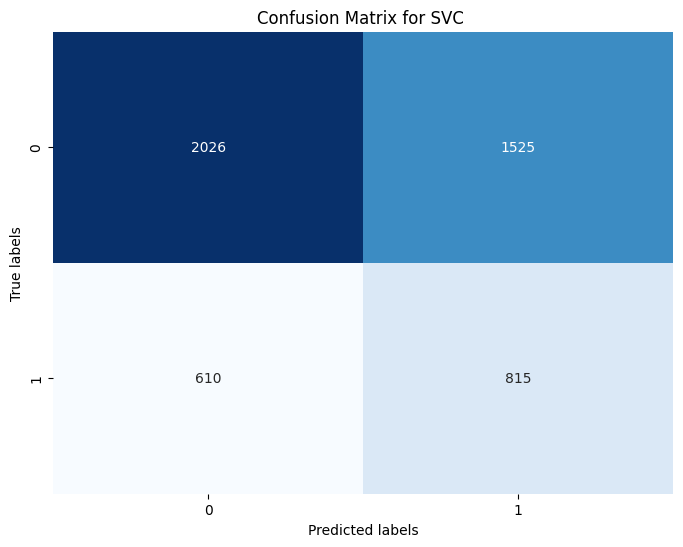

ROC AUC Score: 0.60


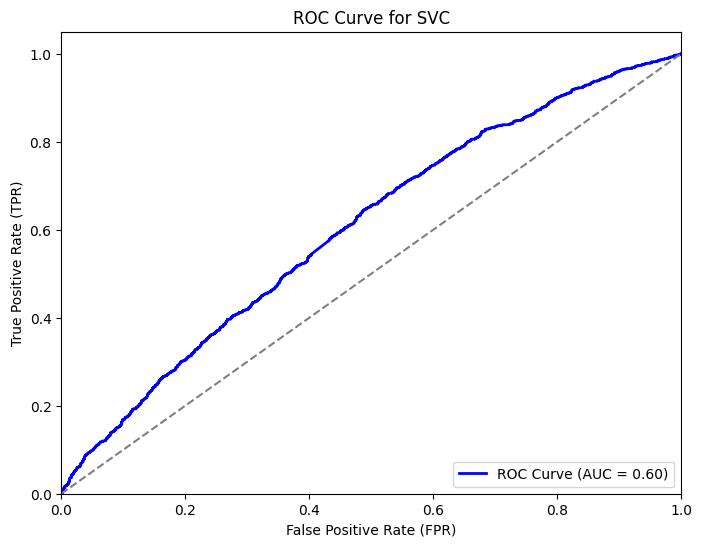

In [135]:
for model_name , model in best_models.items():
    if model_name not in ['NN']:
        evaluate_model(model,X_test[xgb_top_features],y_test)

## Cross Validation Testing for Best Model : XGBoost with Mutual Information Feature Selection

In [ ]:
print(f'Tuning XGB with MI Feature Selection .....')
param_grid = get_parameter_grid('XGBoost')
best_model = get_best_model(xgb_model ,param_grid, X_train[mi_ranked_features], y_train)
xgb_mi_model = best_model
print('Model tuning complete!')

In [ ]:
evaluate_model(xgb_mi_model,X_test[mi_ranked_features],y_test)

In [ ]:
folds = 5
cross_val_scores = {}
cross_val_scores['Accuracy'] = cross_val_score(xgb_mi_model,X_train[mi_ranked_features],y_train,scoring='accuracy',cv=folds).mean()
cross_val_scores['Recall'] = cross_val_score(xgb_mi_model,X_train[mi_ranked_features],y_train,scoring='recall',cv=folds).mean()
cross_val_scores['F1'] = cross_val_score(xgb_mi_model,X_train[mi_ranked_features],y_train,scoring='f1',cv=folds).mean()

print(f"Average Cross-Validation Accuracy for XGBoost : {cross_val_scores['Accuracy']}")
print(f"Average Cross-Validation Recall for XGBoost : {cross_val_scores['Recall']}")
print(f"Average Cross-Validation F1 for XGBoost : {cross_val_scores['F1']}")

In [ ]:
X_train[mi_ranked_features]

In [51]:
top_feats = ['CurrentEquipmentDays', 'MonthsInService', 'OffPeakCallsInOut',
       'TotalRecurringCharge', 'UnansweredCalls', 'IncomeGroup',
       'OptOutMailings', 'MonthlyMinutes', 'PercChangeMinutes',
       'RetentionCalls']

In [81]:
higher_features = ['CurrentEquipmentDays', 'RetentionCalls','UnansweredCalls','OptOutMailings' ]
lower_features = ['MonthsInService','PercChangeMinutes','MonthlyMinutes','TotalRecurringCharge','IncomeGroup','OffPeakCallsInOut']

In [51]:
sample = pd.DataFrame(np.array(X_test[top_feats].iloc[2,:]).reshape(1,-1),columns=top_feats)
sample

CurrentEquipmentDays  MonthsInService  OffPeakCallsInOut  \
0                1002.0             33.0               47.3   

   TotalRecurringCharge  UnansweredCalls  IncomeGroup  OptOutMailings  \
0                  70.0             32.0          6.0             0.0   

   MonthlyMinutes  PercChangeMinutes  RetentionCalls  
0           494.0             -332.0             0.0

In [53]:
X_test[top_feats]

CurrentEquipmentDays  MonthsInService  OffPeakCallsInOut  \
33411                  31.0             11.0              372.7   
41447                 198.0              7.0               85.7   
4509                 1002.0             33.0               47.3   
1812                   68.0             37.0              158.7   
41743                 303.0             10.0               27.7   
...                     ...              ...                ...   
17297                 610.0             20.0                0.0   
3111                  163.0             33.0              443.0   
3254                  580.0             31.0               15.0   
31616                 358.0             12.0                2.7   
15380                 678.0             23.0               53.7   

       TotalRecurringCharge  UnansweredCalls  IncomeGroup  OptOutMailings  \
33411                  85.0             19.3          0.0             0.0   
41447                  10.0             31.0          9.0             0.0   
4509                   70.0             32.0          6.0             0.0   
1812                   75.0             50.7          3.0             0.0   
41743                  40.0             13.3          4.0             0.0   
...                     ...              ...          ...             ...   
17297                  70.0              0.0          8.0             0.0   
3111                  126.0            189.7          1.0             0.0   
3254                   50.0              9.7          7.0             0.0   
31616                  30.0              2.0          6.0             0.0   
15380                  10.0             24.0          0.0             0.0   

       MonthlyMinutes  PercChangeMinutes  RetentionCalls  
33411          2072.0              223.0             0.0  
41447           289.0               53.0             0.0  
4509            494.0             -332.0             0.0  
1812           1223.0             1122.0             0.0  
41743           251.0               -3.0             0.0  
...               ...                ...             ...  
17297             0.0                0.0             0.0  
3111           1481.0             -581.0             0.0  
3254             94.0              -94.0             0.0  
31616            25.0              -15.0             0.0  
15380           296.0              -60.0             0.0  

[4976 rows x 10 columns]

In [54]:
xgb_model.fit(X_train[top_feats],y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

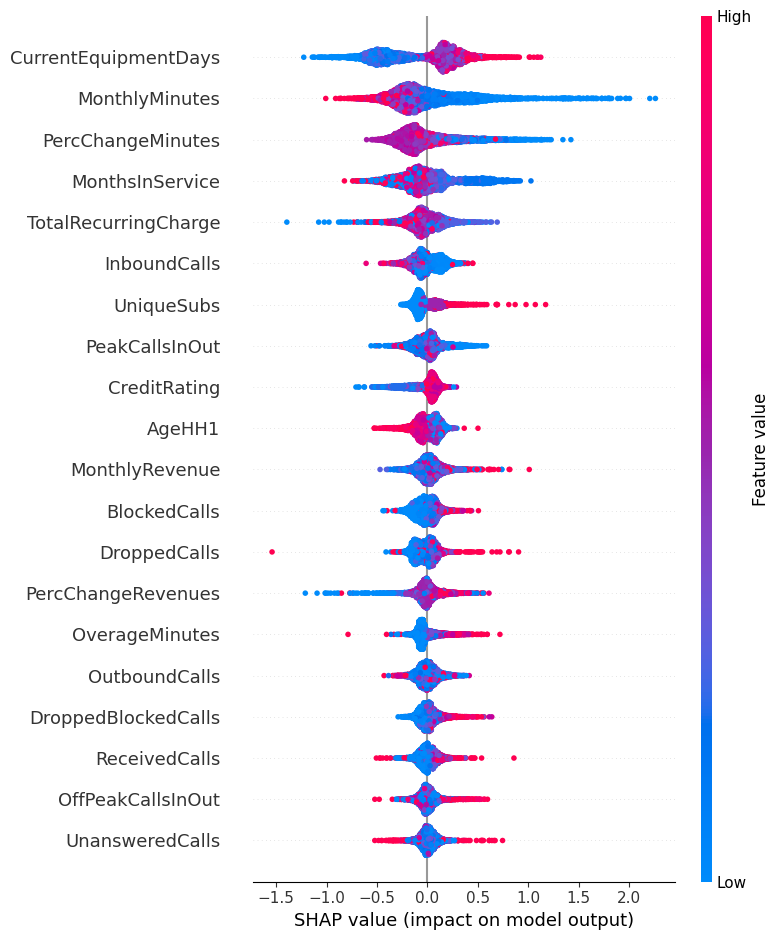

In [86]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test, check_additivity=False)


feature_names = X_test.columns 

shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type='dot')
plt.show()

In [ ]:
sample_shap_values = explainer.shap_values(sample)
shap.summary_plot(sample_shap_values, sample, feature_names=mi_ranked_features, plot_type='dot')
plt.show()

In [ ]:
sample_shap_values = explainer.shap_values(sample)

shap.initjs()
shap.force_plot(explainer.expected_value, sample_shap_values, sample, feature_names=mi_ranked_features)

In [145]:
mean_values = {}

for feature in top_feats:
    mean_values[feature] = X_train[top_feats][feature].mean()

In [ ]:
shap_dict = {}
zipped_shape = list(zip(mi_ranked_features, sample_shap_values[0]))
sorted_zipped_shape = sorted(zipped_shape, key=lambda x: abs(x[1]), reverse=True)
for feature, shap_val in sorted_zipped_shape:
    shap_dict[feature] = shap_val

In [ ]:

# with open('XGBoost-Model.pkl','wb') as file:
#     pickle.dump(xgb_mi_model,file)

In [ ]:
with open('Top-Features.pkl','wb') as file:
    pickle.dump(top_feats,file)

In [ ]:
with open('High-Features.pkl','wb') as file:
    pickle.dump(higher_features,file)

In [ ]:
with open('Low-Features.pkl','wb') as file:
    pickle.dump(lower_features,file)

In [ ]:
with open('Mean-Vals.pkl','wb') as file:
    pickle.dump(mean_values,file)

In [ ]:
# tests = dropped_samples[mi_ranked_features.insert(0, 'Churn')].dropna()
# tests['OptOutMailings'] = tests['OptOutMailings'].apply(lambda x:0 if x=='No' else 1)
# churns = tests['Churn']
# samps = tests[mi_ranked_features]

In [ ]:
# churns = churns.apply(lambda x:1 if x== 'Yes' else 0)

In [ ]:
# xgb_mi_model.predict(samps)

## Testing on Hold Out Data

### You can use this for testing the web application for confirming results

In [73]:
with open('XGBoost-Model.pkl','rb') as file:
    loaded_model = pickle.load(file)

In [74]:
test_df = pd.read_csv('testing_data.csv')

In [147]:
higher_insights = {
    'CurrentEquipmentDays': 'The customer has longer equipment usage than typical, which might suggest customer migh consider other options soon, which might lead to churn.',
    'RetentionCalls': 'The customer has a higher number of retention calls than typical, which implies efforts to keep them from leaving, indicating a higher likelihood of churn.',
    'UnansweredCalls': 'The customer has a higher than typical amount of unanswered calls, which may suggest dissatisfaction or disengagement, leading to churn.',
    'OptOutMailings': 'The customer has opted out of mailings, which could indicate a lack of interest in promotions or communication, signaling potential churn.'
}

lower_insights = {
    'MonthsInService': 'The customer has a shorter service duration than typical, which may indicate they have not established strong ties with the service, making them more likely to churn.',
    'PercChangeMinutes': 'The customer has a decrease in usage over time, which might signal dissatisfaction or a shift in needs, leading to churn.',
    'MonthlyMinutes': 'The customer has lower monthly usage than typical, which could suggest reduced engagement or dissatisfaction, increasing the likelihood of churn.',
    'TotalRecurringCharge': 'The customer has lower charges than typical, which may indicate they are seeking cheaper alternatives or are dissatisfied with the current service\'s value.',
    'IncomeGroup': 'The customer belongs to a lower income group than typical, which may make them more sensitive to pricing changes or less loyal, impacting churn rates.',
    'OffPeakCallsInOut': 'The customer has lower engagement during off-peak hours than typical, which might reflect overall reduced usage or satisfaction issues, contributing to churn predictions.'
}

# Combine higher and lower insights into a single dictionary
churn_insights = {
    'higher_features': higher_insights,
    'lower_features': lower_insights
}

In [148]:
non_churn_higher_insights = {
    'CurrentEquipmentDays': 'The customer has newer equipment, which may indicate satisfaction with the latest technology and lower churn probability.',
    'RetentionCalls': 'The customer has fewer retention calls, suggesting satisfaction and loyalty, leading to lower churn rates.',
    'UnansweredCalls': 'The customer responds to calls promptly, indicating engagement and satisfaction, which reduces churn rates.',
    'OptOutMailings': 'The customer has opted in for mailings, showing interest in promotions or updates, and reflecting lower churn likelihood.'
}

# Define insights for higher values in lower_features (non-churn predictions)
non_churn_lower_insights = {
    'MonthsInService': 'The customer has a longer service duration, indicating loyalty and satisfaction, which reduces churn probability.',
    'PercChangeMinutes': 'The customer has stable or increasing usage over time, suggesting satisfaction and loyalty, leading to lower churn rates.',
    'MonthlyMinutes': 'The customer has higher monthly usage, reflecting active engagement and satisfaction, which lowers churn risk.',
    'TotalRecurringCharge': 'The customer has higher charges, signifying value for service features, leading to lower churn rates.',
    'IncomeGroup': 'The customer belongs to a higher income group, affording premium services and exhibiting loyalty, resulting in lower churn rates.',
    'OffPeakCallsInOut': 'The customer has higher engagement during off-peak hours, indicating overall active usage and satisfaction, contributing to non-churn predictions.'
}

# Combine non-churn insights for higher and lower features into a single dictionary
non_churn_insights = {
    'higher_features': non_churn_higher_insights,
    'lower_features': non_churn_lower_insights
}


In [ ]:
with open ('Churn-Insights.pkl','wb') as file:
    pickle.dump(churn_insights,file)

with open ('NonChurn-Insights.pkl','wb') as file:
    pickle.dump(non_churn_insights,file)

In [79]:
def predict(sample):
    sample = np.array(sample).reshape(1,-1)
    sample = pd.DataFrame(sample,columns=top_feats)
    sample['OptOutMailings'] = sample['OptOutMailings'].apply(lambda x:1 if x=='Yes' else 0)
    sample = sample.astype(float)
    prediction = loaded_model.predict(sample)[0]
    explainer = shap.TreeExplainer(loaded_model)
    sample_shap_values = explainer.shap_values(sample)
    shap_dict = {}
    zipped_shape = list(zip(top_feats, sample_shap_values[0]))
    sorted_zipped_shape = sorted(zipped_shape, key=lambda x: abs(x[1]), reverse=True)
    for feature, shap_val in sorted_zipped_shape:
        shap_dict[feature] = shap_val

    if prediction == 1 :
        print('The customer is likely to churn')

    elif prediction ==0:
        print('The customer is unlikely to churn')

    for feature,sval in shap_dict.items():
        if prediction == 1 :
            if (feature in higher_features) and (sample[feature][0] > mean_values[feature]) and (sval>0):
                print(churn_insights['higher_features'][feature])
            if (feature in lower_features) and (sample[feature][0] < mean_values[feature]) and (sval>0):
                print(churn_insights['lower_features'][feature])
                

        elif prediction == 0 :
            if (feature in higher_features) and (sample[feature][0] < mean_values[feature]) and (sval<0):
                print(non_churn_insights['higher_features'][feature])
            if (feature in lower_features) and (sample[feature][0] > mean_values[feature]) and (sval<0):
                print(non_churn_insights['lower_features'][feature])

    return prediction,sample

In [150]:
test = list(test_df.iloc[1][top_feats])

In [152]:
predicton,tested_sample = predict(test)

The customer is unlikely to churn
The customer has higher charges, signifying value for service features, leading to lower churn rates.
The customer has stable or increasing usage over time, suggesting satisfaction and loyalty, leading to lower churn rates.
The customer has higher engagement during off-peak hours, indicating overall active usage and satisfaction, contributing to non-churn predictions.
The customer has fewer retention calls, suggesting satisfaction and loyalty, leading to lower churn rates.
The customer has a longer service duration, indicating loyalty and satisfaction, which reduces churn probability.
The customer belongs to a higher income group, affording premium services and exhibiting loyalty, resulting in lower churn rates.
The customer has higher monthly usage, reflecting active engagement and satisfaction, which lowers churn risk.
The customer has opted in for mailings, showing interest in promotions or updates, and reflecting lower churn likelihood.
